### _AUTHORS_: Andriolo Matteo, Borella Elisa, Gottardis Enrico, Pampagnin Ledia

# Heart Rate Estimation

Seismocardiography ([SCG](https://www.ncbi.nlm.nih.gov/pubmed/24111357)) is a very promising technique to measure the Heart Rate (HR) and Respiratory Rate (RR) with a detector positioned above the sternum. It is generally based on accelerometer and gyroscope readings or a combination of them. 

Ballistocardiography ([BCG](https://en.wikipedia.org/wiki/Ballistocardiography)) is another technique to estimate heart and respiratory rate with a combination of both an accelerometer and a gyroscope. It is an indirect evaluation of HR and RR since the contact between the device and the body of the subject is not required (e.g., the accelerometer platform can be mounted under the slats of the bed).   
  
MuSe (Multi-Sensor miniaturized, low-power, wireless [IMU](https://en.wikipedia.org/wiki/Inertial_measurement_unit)) is an Inertial Measurement Unit (IMU) provided by [221e](https://www.221e.com). In the context of this project, it allows to record the inertial data necessary for the estimation of SCG and BCG.

The goal of this assignment is to estimate the heart rate of an healthy subject, given the linear acceleration and angular velocity measurements recorded by using the aforementioned MuSe platform.

The study must be performed on two datasets: the first is the compulsory one (`center_sternum.txt`), while the second is left at the discretion of the group, among those made available for the assignment.

*Remember that normal heart rate is around [40-100] bpm.*


## Data

The data is provided in `.txt` files. During this study, two healthy subjects were involved with their informed consent. The first dataset was recorded on one subject, while all the other datasets were recorded on the second subject. 

This is the first mandatory file:

* `center_sternum.txt`: MuSe placed on the center of the sternum. The subject was lying supine on his left and right side, respectively. 


Choose one of the following files in order to complete the task.

* `1_Stave_supine_static.txt`: Sensor placed on a bed stave, under the mattress at the level of the chest. The subject was lying supine on his left and right side. 
* `2_Mattress_supine.txt`: Sensor placed on the mattress, near one corner but not under the pillow. The subject laid in the same position as above. 
* `3_Subject_sitting_chair.txt`: Sensor placed on the desk: the subject, sitting on a chair, leaned forearms and hands on the desk. 
* `4_Chest_sweater.txt`: Sensor placed on the subject chest directly on a sweater. 
* `5_Under_chair.txt`: Subject sitting on a chair, sensor placed under the seat of the chair. 

All `.txt` files have 16 columns, containing: 

* Log Freq stands for the acquisition in Hz (i.e., sampling interval is constant).
* AccX, AccY, AccZ are the measured magnitude of linear acceleration along each axis.
* GyroX, GyroY, GyroZ are the measured magnitude of angular velocity along each axis.
* MagnX, MagnY, MagnZ are the measured magnitude of magnetic field along each axis.
* qw, qi, qj, qk are the quaternion components, representing the spatial orientation of the Muse system.

Each dataset includes, in addition to the data, one file containing the adopted configuration of the MuSe(`config_1.txt` for the first measurement, and in `config_5.txt` for the other measurement).
 


## Assignment



1. Data preparation:

    1.1. Load the txt files and select only the columns you are interested in, in order to do a complete data analysis (e.g. Log Freq, AccX, ... )
    
    1.2. Plot selected data as a function of time and choose a proper time window over which to perform the analysis. Pay attention on the time representation and the measurement unit.
    
    1.3. In order to do a proper job, decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. Motivate your choice.  


    
2. Time and frequency analysis:

    2.1. Statistical analysis: provide a statistical description of the chosen dataset. Statistical descriptors includes for example mean, median, variance, standard deviation, 25th and 75th percentiles, and correlation coefficients. Investigate what could be the most interesting descriptors for this type of data, motivating the choices.
    
    2.2. Fourier Analysis: Perform a frequency analysis of the data. Look at the spectrum and explain what you see. Use the Fourier analysis to properly design the filters in the following step. 



3. Filter:
    
    Implement your own filter, trying to extrapolate the heart rate signal. Hints:
    
    (a) Directly from Fourier Analysis, look for the most interesting frequency band.
    
    (b) Choose the appropriate Lowpass/Bandpass/Highpass filter.
        
    (c) Explore another methods by yourselves.
    
    Remember to always motivate your choice.
    
    
4. Metrics:

    4.1. Heart Beat Per Minute (BPM): extrapolate BPM, make an histogram of the result. Does it follow a particular distribution? 
    
    4.2. Heart Rate Variability (HRV): extrapolate HRV, explain why this parameter is important, and plot the results.


5. **Optional**: Elaborate a simple algorithm to extrapolate the heart rate even when the filter fails (e.g. look for a particular threshold...).  



6. Conclusion: 

    Summarise the obtained results, and specifically make a comparison between the two files analysed. Highlight the limitations and the critical issues encountered during the work, motivating the most relevant contribution given by your solution.

# Data preparation by Matteo Andriolo

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
from scipy import linalg as la
from scipy import signal
from IPython.display import Image
from scipy.signal import find_peaks
from scipy.stats import norm
import scipy.stats as stats

I chose the chest sweater file for the 2nd subject.

In [2]:
file = 'center_sternum.txt'
center_sternum = pd.read_csv(file, delimiter="\t")

#file = '1_Stave_supine_static.txt'
file = '4_Chest_sweater.txt'
#file = "3_Subject_sitting_chair.txt"
chest_sweater = pd.read_csv(file, delimiter="\t")

In [3]:
# original dataset
center_sternum

Log Mode  Log Freq   Timestamp     AccX     AccY    AccZ      GyroX  \
0             5       200  1576222772  947.086  435.662  70.638  -6.824428   
1             5       200  1576222772  969.168  387.777  88.877   6.183206   
2             5       200  1576222772  989.603  380.335  78.751  11.709920   
3             5       200  1576222772  954.894  418.033  88.328  17.877860   
4             5       200  1576222772  972.096  427.732  99.857  25.221370   
...         ...       ...         ...      ...      ...     ...        ...   
16501         5       200  1576222847  958.493  291.092 -54.290   1.664122   
16502         5       200  1576222847  954.650  288.042 -49.654   1.480916   
16503         5       200  1576222847  967.338  290.482 -63.867   1.114504   
16504         5       200  1576222847  965.630  300.852 -56.242   0.702290   
16505         5       200  1576222847  959.957  298.473 -55.998   0.290076   

           GyroY     GyroZ  MagnX  MagnY  MagnZ        qw        qi        qj  \
0     -14.244280  1.404580   -454   -490   -178  0.792622  0.254952 -0.553850   
1     -12.290080 -7.969466   -454   -490   -177  0.736461  0.275124 -0.617969   
2      -4.961832 -7.450382   -454   -490   -177  0.729465  0.275246 -0.626118   
3       2.519084 -5.984733   -454   -492   -176  0.723413  0.277200 -0.632221   
4       5.404580  4.015267   -454   -492   -176  0.721948  0.280007 -0.632679   
...          ...       ...    ...    ...    ...       ...       ...       ...   
16501   2.305344 -0.671756   -494   -449   -126  0.650810  0.379162 -0.636402   
16502   2.488550 -0.702290   -494   -450   -125  0.650239  0.379803 -0.636708   
16503   3.374046 -0.900763   -494   -450   -125  0.649365  0.380627 -0.637227   
16504   3.664122 -1.587786   -495   -448   -124  0.648973  0.381329 -0.637348   
16505   4.061069 -1.343511   -495   -448   -124  0.648462  0.382336 -0.637471   

             qk  
0     -0.000031  
1      0.006806  
2      0.009827  
3      0.011383  
4      0.010193  
...         ...  
16501  0.166356  
16502  0.165960  
16503  0.165502  
16504  0.164953  
16505  0.164159  

[16506 rows x 16 columns]

In [4]:
# original dataset
chest_sweater

Log Mode  Log Freq   Timestamp     AccX     AccY     AccZ      GyroX  \
0             5       100  1555414552  687.836  380.823  580.354  -7.926829   
1             5       100  1555414552 -812.703 -108.946  726.876 -11.707320   
2             5       100  1555414552 -812.520 -108.824  733.952 -37.073170   
3             5       100  1555414552 -787.144  -45.628  616.954 -56.341460   
4             5       100  1555414552 -800.259 -137.433  411.689  -1.097561   
...         ...       ...         ...      ...      ...      ...        ...   
14933         5       100  1555415471 -890.722  -81.008  446.764  -2.682927   
14934         5       100  1555415471 -885.964  -76.006  459.025  -3.902439   
14935         5       100  1555415471 -879.681  -77.714  475.068  -3.048780   
14936         5       100  1555415471 -894.992  -76.311  502.701   0.121951   
14937         5       100  1555415471 -889.319  -90.951  471.835   3.536585   

            GyroY      GyroZ  MagnX  MagnY  MagnZ        qw        qi  \
0        8.048780   0.975610   -592    122   -113  0.788006  0.002899   
1      -81.829270   8.780488    125     60   -128  0.183978 -0.428877   
2     -145.487800  14.756100    123     59   -136  0.128994 -0.427229   
3     -174.634200  23.048780    118     58   -145  0.113618 -0.421033   
4       37.073170   1.341463    113     57   -157  0.107202 -0.424787   
...           ...        ...    ...    ...    ...       ...       ...   
14933    2.926829   0.365854    144     47    -50  0.017279  0.534410   
14934    3.292683   0.365854    146     45    -51  0.016416  0.535050   
14935    2.804878   0.365854    144     46    -54  0.015920  0.534349   
14936    1.463415   0.609756    144     45    -53  0.015192  0.531663   
14937    0.853659   0.609756    144     45    -53  0.015803  0.530137   

             qj        qk  
0     -0.432874 -0.437788  
1      0.002594  0.884426  
2      0.000702  0.894894  
3     -0.001770  0.899899  
4     -0.001251  0.898923  
...         ...       ...  
14933  0.040437 -0.844081  
14934  0.041231 -0.843654  
14935  0.041780 -0.844081  
14936  0.041749 -0.845790  
14937  0.041749 -0.846736  

[14938 rows x 16 columns]

From the site: https://www.221e.com/wp-content/uploads/2022/11/221e-Muse-datasheet-A3b1v03-A3b2v03.pdf and reading the file _config_1.txt_ and _config_5.txt_ we can see that for the 3 magnitudes we consider, specific measurement units have been used.
<br><br>
In __Center_sternum__ file measurement units:<br>
    1. linear acceleration:  2 g (g = 9.81 m/s^2)<br>
    2. angular velocity: 500 dps (degrees per second)<br>
    3. magnetic field: 12 G (Gauss)<br>
<br>
In __Cheast_sweater__ file measurement units:<br>
    1. linear acceleration:  2 g (g = 9.81 m/s^2)<br>
    2. angular velocity: 4000 dps (degrees per second)<br>
    3. magnetic field: 12 G (Gauss)<br>
<br>

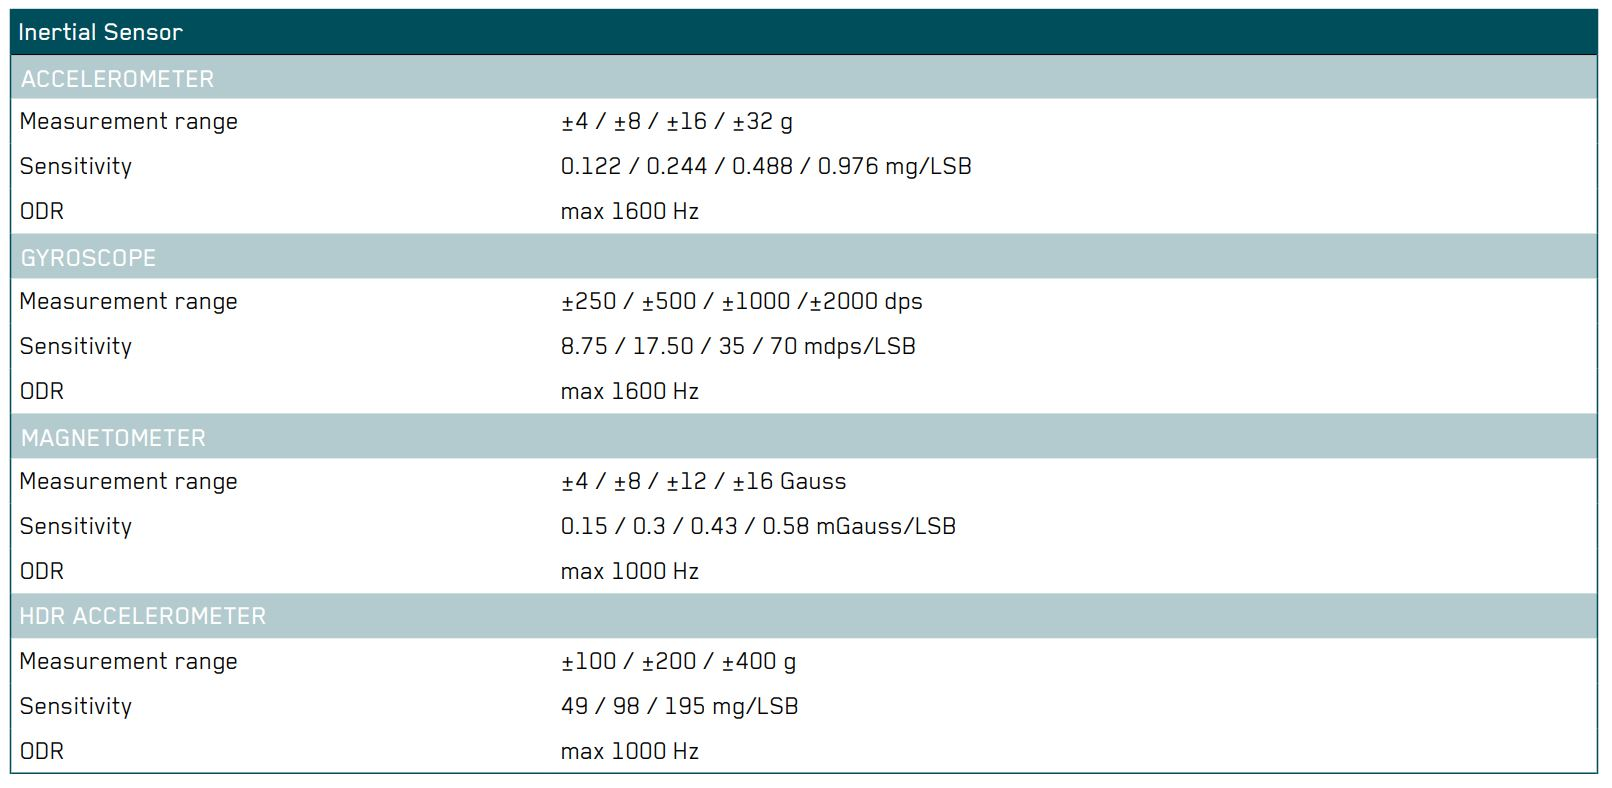

In [5]:
Image("Inertial_sensor.jpg", width = 600)

In [6]:
#!cat config_1.txt

In [7]:
#!cat config_5.txt

We have to decide whether to consider some particular axis or some combination of them as well as derived features for the next step of the task. <br>
Observing the dataset, we can see that we've:<br>
1. the measured magnitude of linear acceleration along each axis.<br>
2. the measured magnitude of angular velocity along each axis.<br>
3. the measured magnitude of magnetic field along each axis.<br><br>

The three magnitudes are described by the values along 3 axes: x , y, x --> _p_ = 3 and we want to know if it's possible to reduce the number of dimensions and keep only the principal components.<br> 
We perform the PCA by using eigendecomposition of covariance matrix.

In [8]:
def perform_PCA(df):
    #linear acceleration
    acc_lin =  df.loc[:, ["AccX","AccY","AccZ"]]
    cov_acc = np.cov(acc_lin.to_numpy(), rowvar=False)
    #angular velocity
    ang_vel =  df.loc[:, ["GyroX","GyroY","GyroZ"]]
    cov_vel = np.cov(ang_vel.to_numpy(), rowvar=False)
    #magnetic field
    mag_field =  df.loc[:, ["MagnX","MagnY","MagnZ"]]
    cov_mag = np.cov(mag_field.to_numpy(), rowvar=False)

    # now find the eigenvectors of the covariance matrices
    l1, V1 = la.eig(cov_acc)
    l2, V2 = la.eig(cov_vel)
    l3, V3 = la.eig(cov_mag)
    # take only the real component, if possible
    l1 = np.real_if_close(l1)
    l2 = np.real_if_close(l2)
    l3 = np.real_if_close(l3)
    
    #find the contribution of each component to the total variability
    Lambda_1 = np.diag(l1)
    Lambda_2 = np.diag(l2)
    Lambda_3 = np.diag(l3)
    
    s = ["LINEAR ACCELERATION", "ANGULAR VELOCITY", "MAGNETIC FIELD"]
    L = [Lambda_1, Lambda_2, Lambda_3]
    for i in range(3):
        print(s[i])
        print("By selecting the component x, we retain %.2f%% of the total variability" % (L[i][0, 0]/L[i].trace()*100))
        print("By selecting the component y, we retain %.2f%% of the total variability" % (L[i][1, 1]/L[i].trace()*100))
        print("By selecting the component z, we retain %.2f%% of the total variability\n" % (L[i][2, 2]/L[i].trace()*100))

 ##### PCA - center_sternum

In [9]:
perform_PCA(center_sternum)

LINEAR ACCELERATION
By selecting the component x, we retain 94.24% of the total variability
By selecting the component y, we retain 3.88% of the total variability
By selecting the component z, we retain 1.88% of the total variability

ANGULAR VELOCITY
By selecting the component x, we retain 60.34% of the total variability
By selecting the component y, we retain 20.76% of the total variability
By selecting the component z, we retain 18.90% of the total variability

MAGNETIC FIELD
By selecting the component x, we retain 97.86% of the total variability
By selecting the component y, we retain 1.29% of the total variability
By selecting the component z, we retain 0.85% of the total variability



__Observations__:<br>
Data are recorded with sensor placed on the center of the sternum and the subject lying supine on his left and right side, respectively. <br>
As regards the linear acceleration and the magnetic field,  the highest % of the total variability is due to the component X. For the angular velocity, if we keep only the x component we retain 60% of total variability: it's better to consider its measure along each axis.

 ##### PCA - cheast_sweater

In [10]:
perform_PCA(chest_sweater)

LINEAR ACCELERATION
By selecting the component x, we retain 75.30% of the total variability
By selecting the component y, we retain 15.63% of the total variability
By selecting the component z, we retain 9.07% of the total variability

ANGULAR VELOCITY
By selecting the component x, we retain 82.12% of the total variability
By selecting the component y, we retain 17.44% of the total variability
By selecting the component z, we retain 0.44% of the total variability

MAGNETIC FIELD
By selecting the component x, we retain 73.63% of the total variability
By selecting the component y, we retain 17.23% of the total variability
By selecting the component z, we retain 9.14% of the total variability



__Observations__:<br>
Data are recorded with a sensor placed on the subject chest directly on a sweater. <br>
For each of the 3 magnitudes, the highest % of the total variability is due to component X and Y (around 90% for linear acceleration and magnetic field, 99% for the angular velocity). 

The __goal__ of this project is __to estimate the heart rate of an healthy subject, given the linear acceleration and angular velocity measurements__. <br>
Data have been collected by using the MuSe, an inertial measurement unit (IMU). IMU is a device that integrates a 3-axis gyroscope, a 3-axis accelerometer, and a 3-axis magnetometer to provide estimation of an objects orientation in space. <br>
In this case, it allows to  detect __the mechanical vibration of chest due to heart beating__ and to record this data. 
__The signal acquired is called the ballistocardiogram (BCG)__. 
<br>

__Observations__: <br>
Since we can also consider a particolar combination of axis, we've decided to compute the magnitude of the norm of the three vectors "linear acceleration", "angular velocity", "magnetic field", in order to simplify the analysis of separated components. 

To take only columns we're interested in.

In [70]:
def process_dataframe(df):
    frequency = df["Log Freq"].iloc[0]
    columns_to_delete = ["Log Mode", "Log Freq", "Timestamp"]
    df = df.drop(columns=columns_to_delete)
    df.insert(0, 'Time', None)
    df.insert(1, 'Acc', None)
    df.insert(2, 'Gyro', None)
    df.insert(3, 'Magn', None)
    
    # rewrite time values
    time_offset = 1 / frequency # time unit = 1 / frequency
    
    previous_value = 0
    
    for i, value in enumerate(df["Time"]):
        if i == 0:
            # first time value set to 0
            df.at[i, "Time"] = 0
        else:
            df.at[i, "Time"] = previous_value + time_offset
    
        previous_value = df.at[i, "Time"]
    
    #perform data --> we compute the magnitudes of the vectors  
    for i, row in df.iterrows():
        acc_value = np.sqrt(row["AccX"]**2 + row["AccY"]**2 + row["AccZ"]**2)
        acc_value_rounded = round(acc_value, 2)
        df.at[i, 'Acc'] = acc_value_rounded
    
    columns_to_delete = ["AccX", "AccY", "AccZ"]
    df = df.drop(columns=columns_to_delete)
    
    for i, row in df.iterrows():
        g_value = np.sqrt(row["GyroX"]**2 + row["GyroY"]**2 + row["GyroZ"]**2)
        g_value_rounded = round(g_value, 2)
        df.at[i, 'Gyro'] = g_value_rounded
    
    columns_to_delete = ["GyroX", "GyroY", "GyroZ"]
    df = df.drop(columns=columns_to_delete)
    
    for i, row in df.iterrows():
        m_value = np.sqrt(row["MagnX"]**2 + row["MagnY"]**2 + row["MagnZ"]**2)
        m_value_rounded = round(m_value, 2)
        df.at[i, 'Magn'] = m_value_rounded
    
    columns_to_delete = ["MagnX", "MagnY", "MagnZ"]
    df = df.drop(columns=columns_to_delete)
    
    columns_to_delete = ["qw", "qi", "qj", "qk"]
    df = df.drop(columns=columns_to_delete)
    
    return df

To plot the magnitude of linear acceleration, angular velocity and magnetic field vectors.

In [12]:
def plot_magnitude_vectors(df, name_data_file):
    fig, axes = plt.subplots(3, 1, figsize=(18, 15))
    # Plot linear acceleration
    axes[0].plot(df["Time"], df["Acc"], color="green", linestyle="-")
    axes[0].set_xlabel("Time [s]")
    axes[0].set_ylabel("Magnitude of linear acceleration")
    axes[0].grid(True)
    axes[0].set_title("%s - linear acceleration" % name_data_file)
    axes[0].xaxis.set_major_locator(plt.MultipleLocator(5))

    # Plot angular velocity
    axes[1].plot(df["Time"], df["Gyro"], color="blue", linestyle="-")
    axes[1].set_xlabel("Time [s]")
    axes[1].set_ylabel("Magnitude of angular velocity")
    axes[1].grid(True)
    axes[1].set_title("%s- angular velocity" % name_data_file)
    axes[1].xaxis.set_major_locator(plt.MultipleLocator(5))
    
    # Plot magnetic field
    axes[2].plot(df["Time"], df["Magn"], color="red", linestyle="-")
    axes[2].set_xlabel("Time [s]")
    axes[2].set_ylabel("Magnitude of magnetic field")
    axes[2].grid(True)
    axes[2].set_title("%s - magnetic field" % name_data_file)
    axes[2].xaxis.set_major_locator(plt.MultipleLocator(5))

We try to plot the magnitudes of the 3 vectors (acceleration, velocity and magnitude field) in order to understand if there's a specific time window that we must select to perform tha analysis.

In [13]:
center_sternum = process_dataframe(center_sternum)
chest_sweater = process_dataframe(chest_sweater)

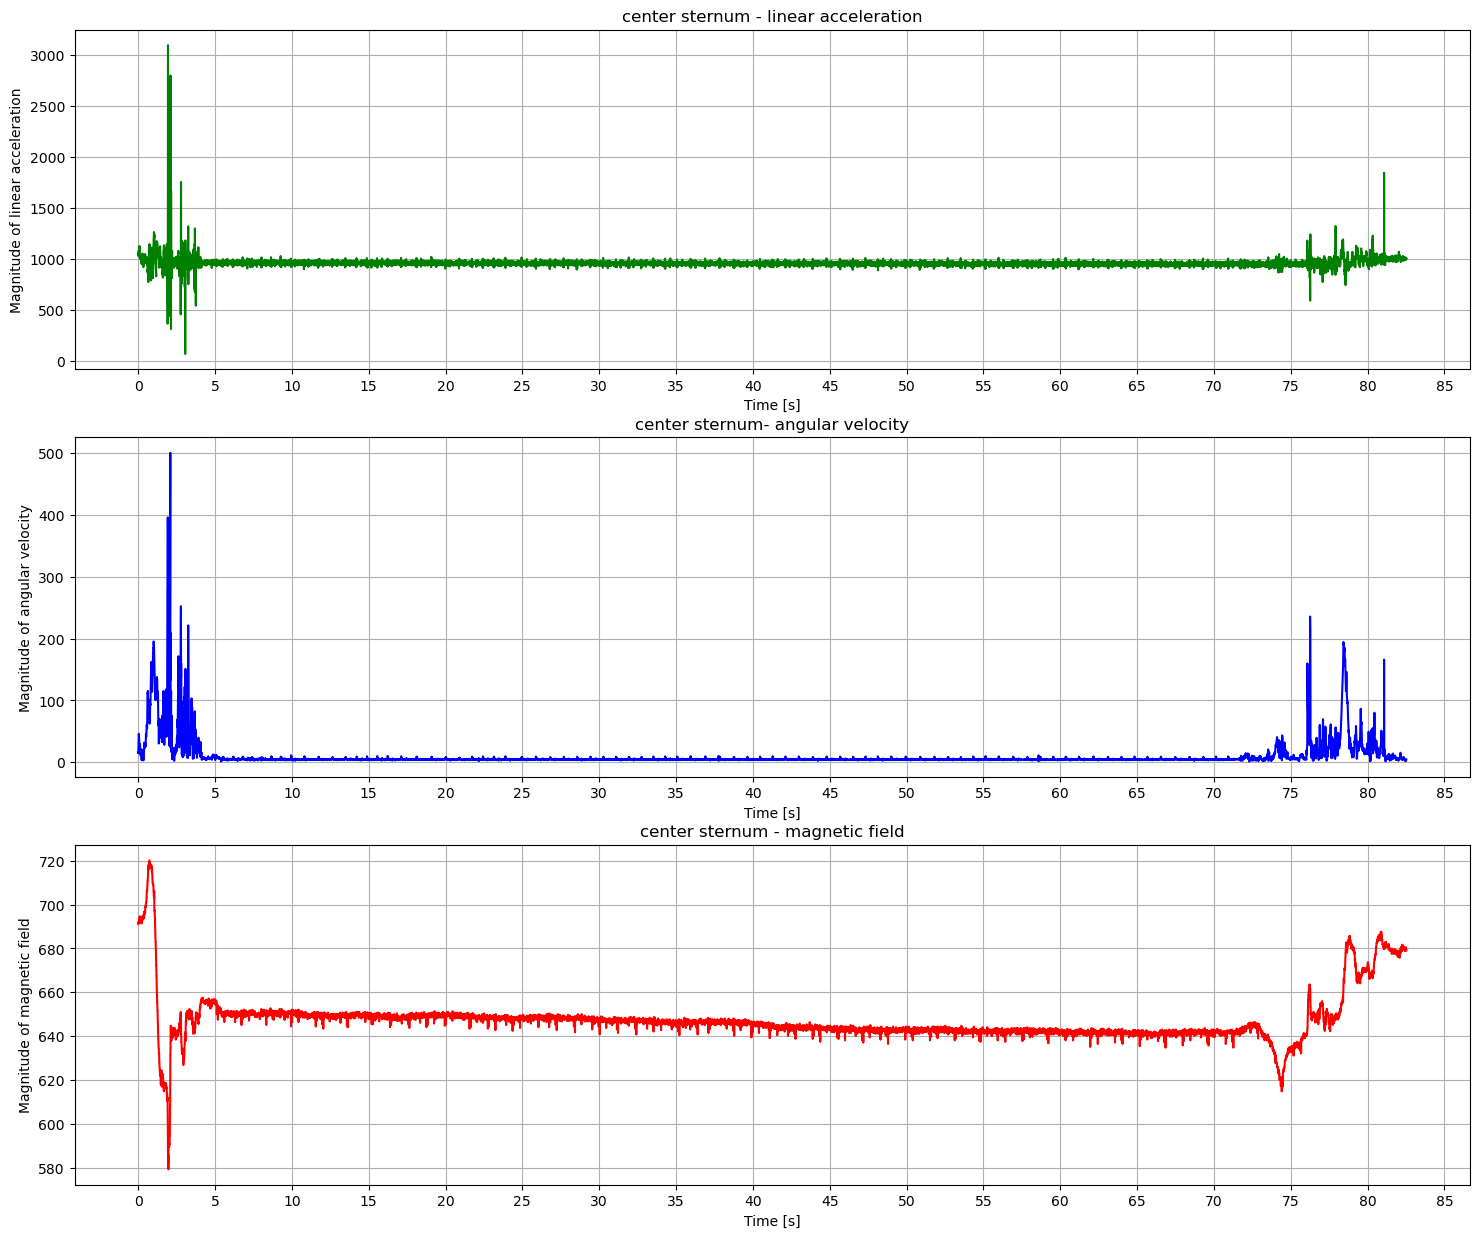

In [14]:
plot_magnitude_vectors(center_sternum, "center sternum")

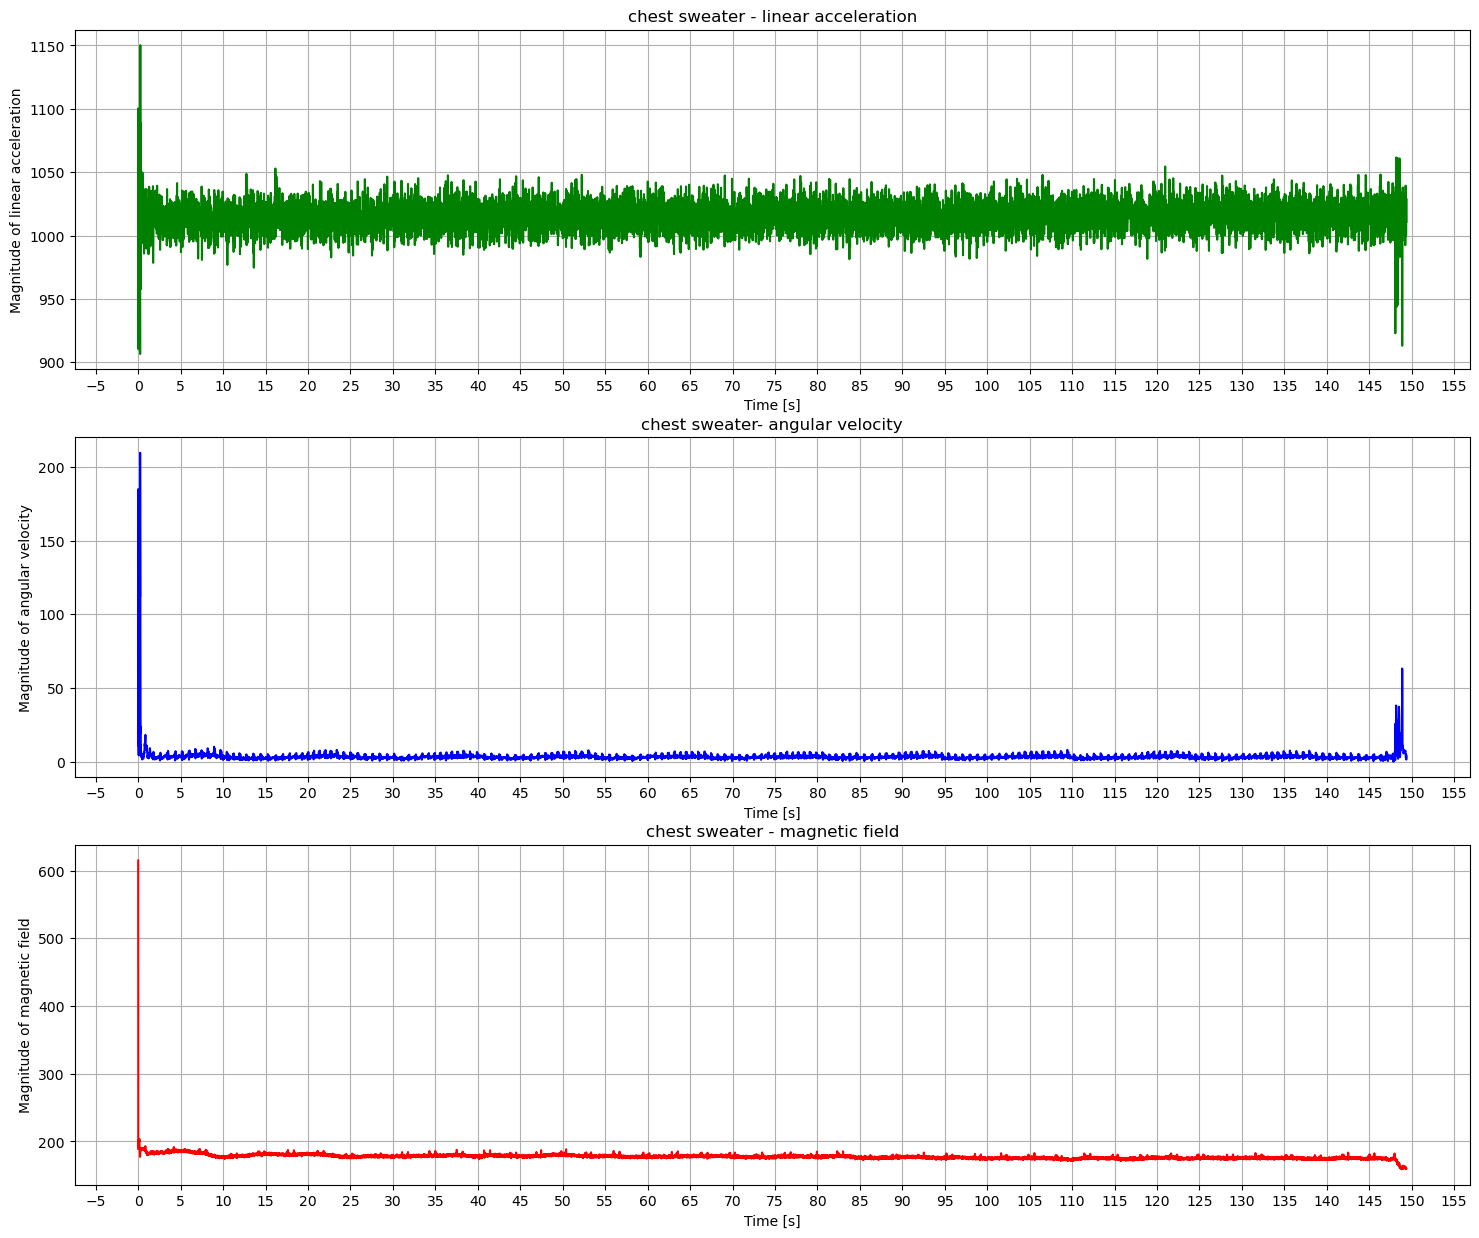

In [15]:
plot_magnitude_vectors(chest_sweater, "chest sweater")

From the plots  above we can see that there is a regular pattern in the central part of the signal. We suppose that at the beginning and at the end of inertial data's recording, there's noise the noise due to the application and removal of sensor. 
We can apply a window to select only the central time range.

To select a proper time window and keep only a specific range of data.

In [16]:
def select_time_wnd(df,start_time_to_analyze, end_time_to_analyze):
    # filter to analyze data in a time period of time_to_analyze seconds
    if start_time_to_analyze >= end_time_to_analyze:
        print("The period of time inserted is not examinable: please input a period with starting time littler than the end time.\
        The dataframe is returned not modified.")
    else:
        df = df.loc[df["Time"] > start_time_to_analyze]
        df = df.loc[df["Time"] <= end_time_to_analyze]
    return df

In [17]:
center_sternum = select_time_wnd(center_sternum, 7, 70)
chest_sweater = select_time_wnd(chest_sweater, 5, 145)

#### Dataset with only interesting features and window-time-selection perfomed

In [18]:
center_sternum

Time     Acc  Gyro    Magn
1401    7.005  981.78  4.14  650.35
1402     7.01  959.28  4.37  650.35
1403    7.015  965.85  4.54  650.67
1404     7.02  965.63  4.68  650.67
1405    7.025  956.79  3.89  649.01
...       ...     ...   ...     ...
13995  69.975  944.34  4.72  642.35
13996   69.98  949.07  4.69  641.35
13997  69.985  950.11  4.77  641.35
13998   69.99  955.25  4.88  643.02
13999  69.995  945.55  4.54  643.02

[12599 rows x 4 columns]

In [19]:
chest_sweater

Time      Acc  Gyro    Magn
501      5.01  1015.88  3.68  185.94
502      5.02  1015.09  3.47  185.11
503      5.03  1021.06  4.33  186.47
504      5.04   986.95  4.25  184.88
505      5.05  1007.89  3.53   184.1
...       ...      ...   ...     ...
14495  144.95   1021.8  2.66  173.12
14496  144.96  1022.06  3.05  172.74
14497  144.97  1015.85  2.97  176.52
14498  144.98  1013.02  2.69  175.35
14499  144.99  1015.39  2.61  172.59

[13999 rows x 4 columns]

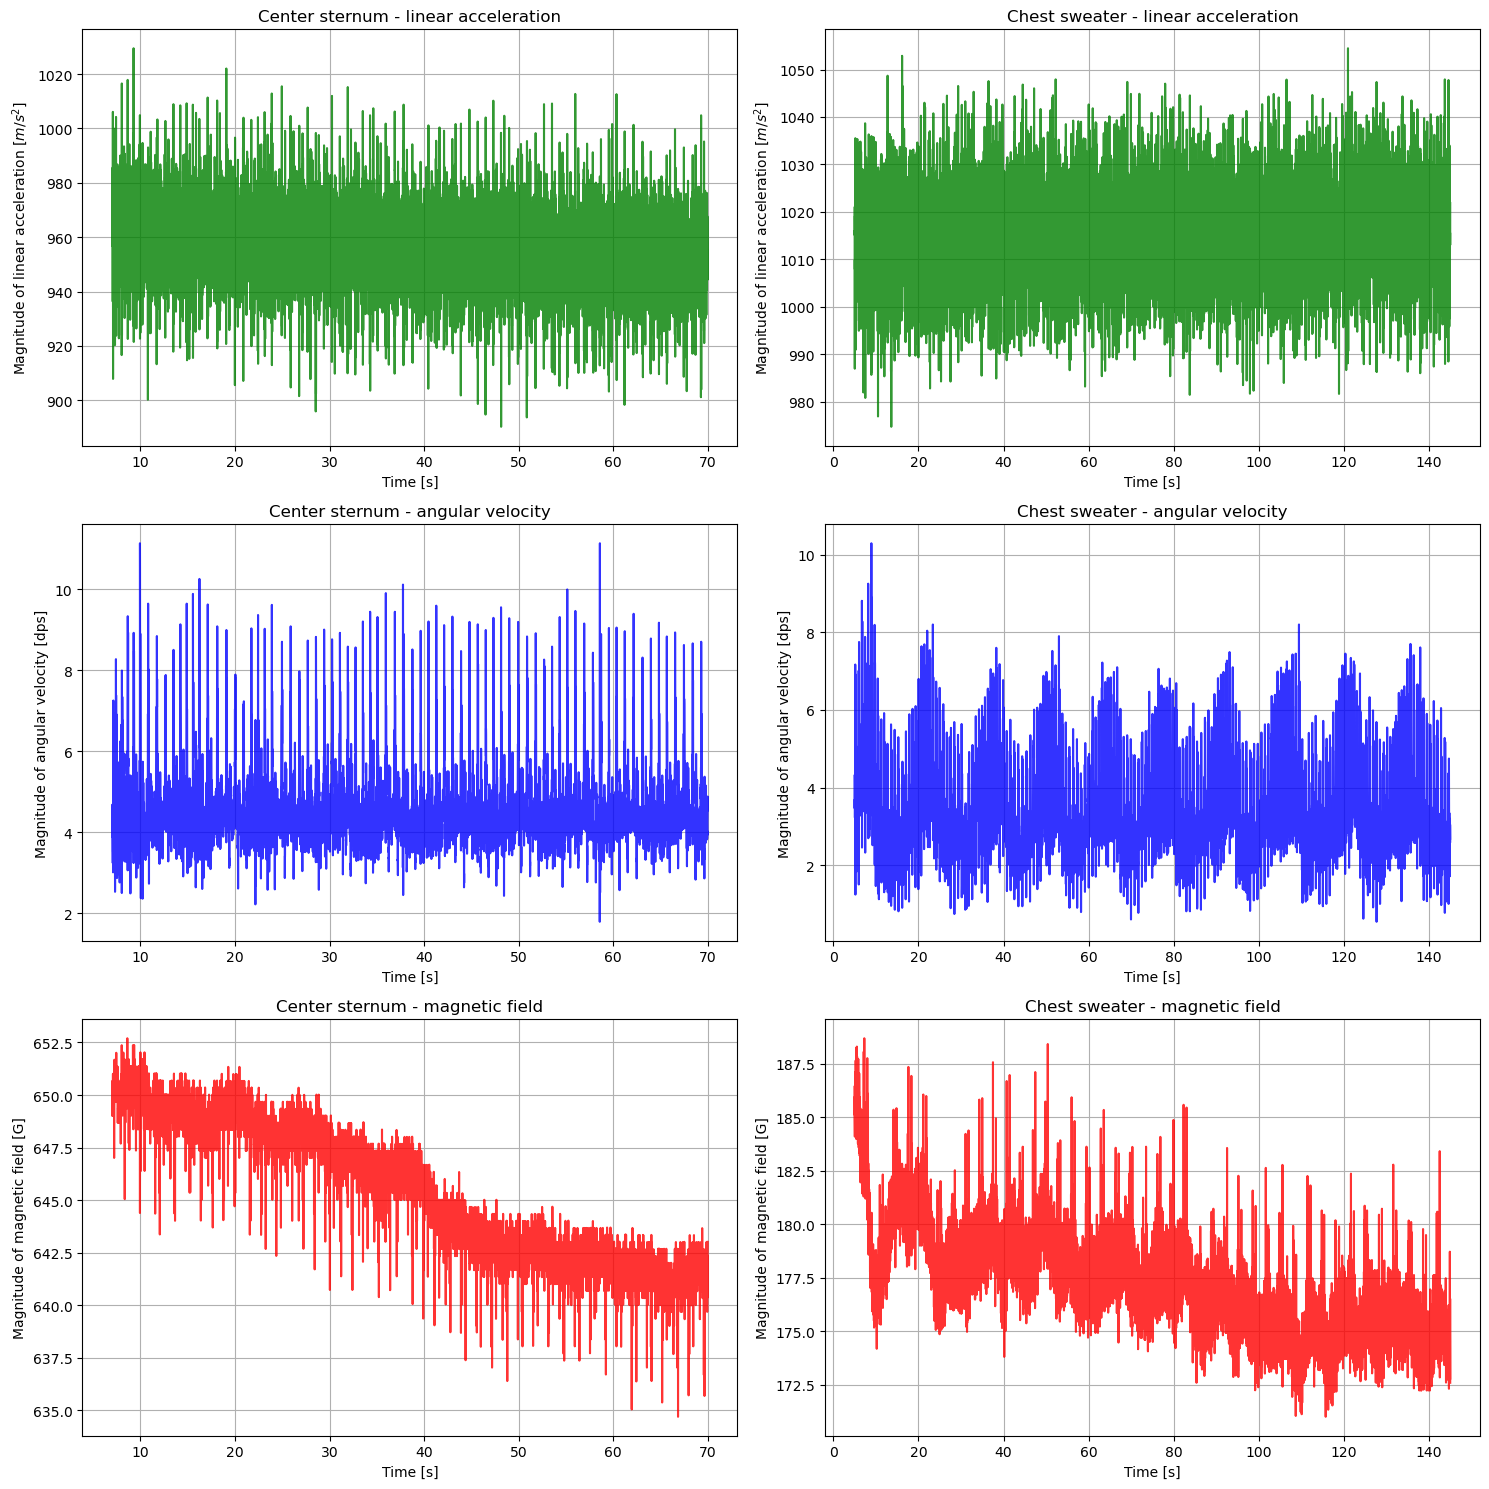

In [20]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot linear acceleration
axes[0, 0].plot(center_sternum["Time"], center_sternum["Acc"], color="green", linestyle="-", alpha=0.8)
axes[0, 0].set_xlabel("Time [s]")
axes[0, 0].set_ylabel("Magnitude of linear acceleration [$m/s^2$]")
axes[0, 0].grid(True)
axes[0, 0].set_title("Center sternum - linear acceleration")

# Plot linear acceleration
axes[0, 1].plot(chest_sweater["Time"], chest_sweater["Acc"], color="green", linestyle="-", alpha=0.8)
axes[0, 1].set_xlabel("Time [s]")
axes[0, 1].set_ylabel("Magnitude of linear acceleration [$m/s^2$]")
axes[0, 1].grid(True)
axes[0, 1].set_title("Chest sweater - linear acceleration")

# Plot angular velocity
axes[1, 0].plot(center_sternum["Time"], center_sternum["Gyro"], color="blue", linestyle="-", alpha=0.8)
axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_ylabel("Magnitude of angular velocity [dps]") # dps: degree per second (equal to omega/second)
axes[1, 0].grid(True)
axes[1, 0].set_title("Center sternum - angular velocity")

# Plot angular velocity
axes[1, 1].plot(chest_sweater["Time"], chest_sweater["Gyro"], color="blue", linestyle="-", alpha=0.8)
axes[1, 1].set_xlabel("Time [s]")
axes[1, 1].set_ylabel("Magnitude of angular velocity [dps]")
axes[1, 1].grid(True)
axes[1, 1].set_title("Chest sweater - angular velocity")

# Plot magnetic field
axes[2, 0].plot(center_sternum["Time"], center_sternum["Magn"], color="red", linestyle="-", alpha=0.8)
axes[2, 0].set_xlabel("Time [s]")
axes[2, 0].set_ylabel("Magnitude of magnetic field [G]")
axes[2, 0].grid(True)
axes[2, 0].set_title("Center sternum - magnetic field")

# Plot magnetic field 
axes[2, 1].plot(chest_sweater["Time"], chest_sweater["Magn"], color="red", linestyle="-", alpha=0.8)
axes[2, 1].set_xlabel("Time [s]")
axes[2, 1].set_ylabel("Magnitude of magnetic field [G]")
axes[2, 1].grid(True)
axes[2, 1].set_title("Chest sweater - magnetic field")

plt.tight_layout()

plt.show()

# Time and frequency analysis by Enrico Gottardis

In [21]:
import scipy.stats as stats
from scipy.fftpack import ifft, ifftshift, fftfreq, rfftfreq, rfft
from scipy import fftpack
import seaborn as sns

### Time analysis

In [22]:
def statistical_analysis(df_input):
    '''
    This method will be used to retrieve the statistical description of a given dataframe in input. The ouput is given in the format of another 
    dataframe, containing the values for the mean, median, variance, standard deviation, 25th, 50th and 75th percentiles. Moreover, it computes the 
    correlation coefficients using the pearson and the spearman method, which are also shown later in order to visually understand if there are any 
    correlation between the features.
    '''
    df = df_input.copy()
    col = df.columns[1:]
    if len(col) < 1: 
        return 'The dataframe given in input has a different format than the one expected. Please retry with a dataframe with one or more columns'
    means = [np.mean(df.loc[:,i]) for i in col]
    medians = [np.median(df.loc[:,i]) for i in col]
    variances = [np.var(df.loc[:,i]) for i in col]
    stds = [np.std(df.loc[:,i]) for i in col]
    q_25 = [np.quantile(df.loc[:,i], 0.25) for i in col]
    q_50 = [np.quantile(df.loc[:,i], 0.50) for i in col]
    q_75 = [np.quantile(df.loc[:,i], 0.75) for i in col]
    corr_coeff1 = [stats.pearsonr(df.loc[:,col[i]], df.loc[:,col[i+1]]) for i in range(len(col)-1)] # This is a list
    corr_coeff1.append(stats.pearsonr(df.loc[:,col[0]], df.loc[:,col[len(col)-1]]))
    stat_p = [corr_coeff1[i][0] for i in range(len(corr_coeff1))]
    p_val_p = [corr_coeff1[i][1] for i in range(len(corr_coeff1))]
    corr_coeff2 = [stats.spearmanr(df.loc[:,col[i]], df.loc[:,col[i+1]]) for i in range(len(col)-1)] # This is a list
    corr_coeff2.append(stats.spearmanr(df.loc[:,col[len(col)-1]], df.loc[:,col[0]]))
    stat_s = [corr_coeff2[i][0] for i in range(len(corr_coeff2))]
    p_val_s = [corr_coeff2[i][1] for i in range(len(corr_coeff2))]
    rms = [np.sqrt(np.mean(df.loc[:,i]**2)) for i in col] # Root Mean Square
    stat_row = ['Mean', 'Median', 'Variance', 'Std', '25% quantile', '50% quantile', '75% quantile', 'Stat_P', 'p_value_P', 'Stat_S', 'p_value_S', 'RMS']
    stat_df = pd.DataFrame(data=[means, medians, variances, stds, q_25, q_50, q_75, stat_p, p_val_p, stat_s, p_val_s, rms], index=stat_row, columns=col)
    return stat_df

The above method is computed to retrieve important statistical information regarding our data. Not only does it include the usual metrics, like the mean, median, standard deviations and from first up to the third quantile, but it also includes the Root Mean Square and the correlation coefficients, which are later described in a more formal manner.

In [23]:
stat_sternum = statistical_analysis(center_sternum)
stat_chest = statistical_analysis(chest_sweater)

In [24]:
center_sternum.iloc[:,1:].describe() # This cell is computed to show the difference between the information retrived with the method describe() of pandas
                                     # and the method implemented to show interesting statistical features of the data

Acc      Gyro      Magn
count   12599.00  12599.00  12599.00
unique   4992.00    620.00    225.00
top       959.87      4.43    642.01
freq       15.00    124.00    372.00

In [25]:
stat_sternum

Acc          Gyro           Magn
Mean          9.569692e+02  4.550660e+00   6.454256e+02
Median        9.573400e+02  4.400000e+00   6.456800e+02
Variance      2.034578e+02  7.516202e-01   1.079045e+01
Std           1.426386e+01  8.669603e-01   3.284881e+00
25% quantile  9.492200e+02  4.090000e+00   6.423500e+02
50% quantile  9.573400e+02  4.400000e+00   6.456800e+02
75% quantile  9.653100e+02  4.750000e+00   6.483600e+02
Stat_P       -1.320815e-01  5.316892e-02   2.316690e-01
p_value_P     3.866759e-50  2.349497e-09  3.883481e-153
Stat_S       -4.490640e-02  5.336221e-02   2.568551e-01
p_value_S     4.593095e-07  2.055853e-09  5.571506e-189
RMS           9.570755e+02  4.632508e+00   6.454340e+02

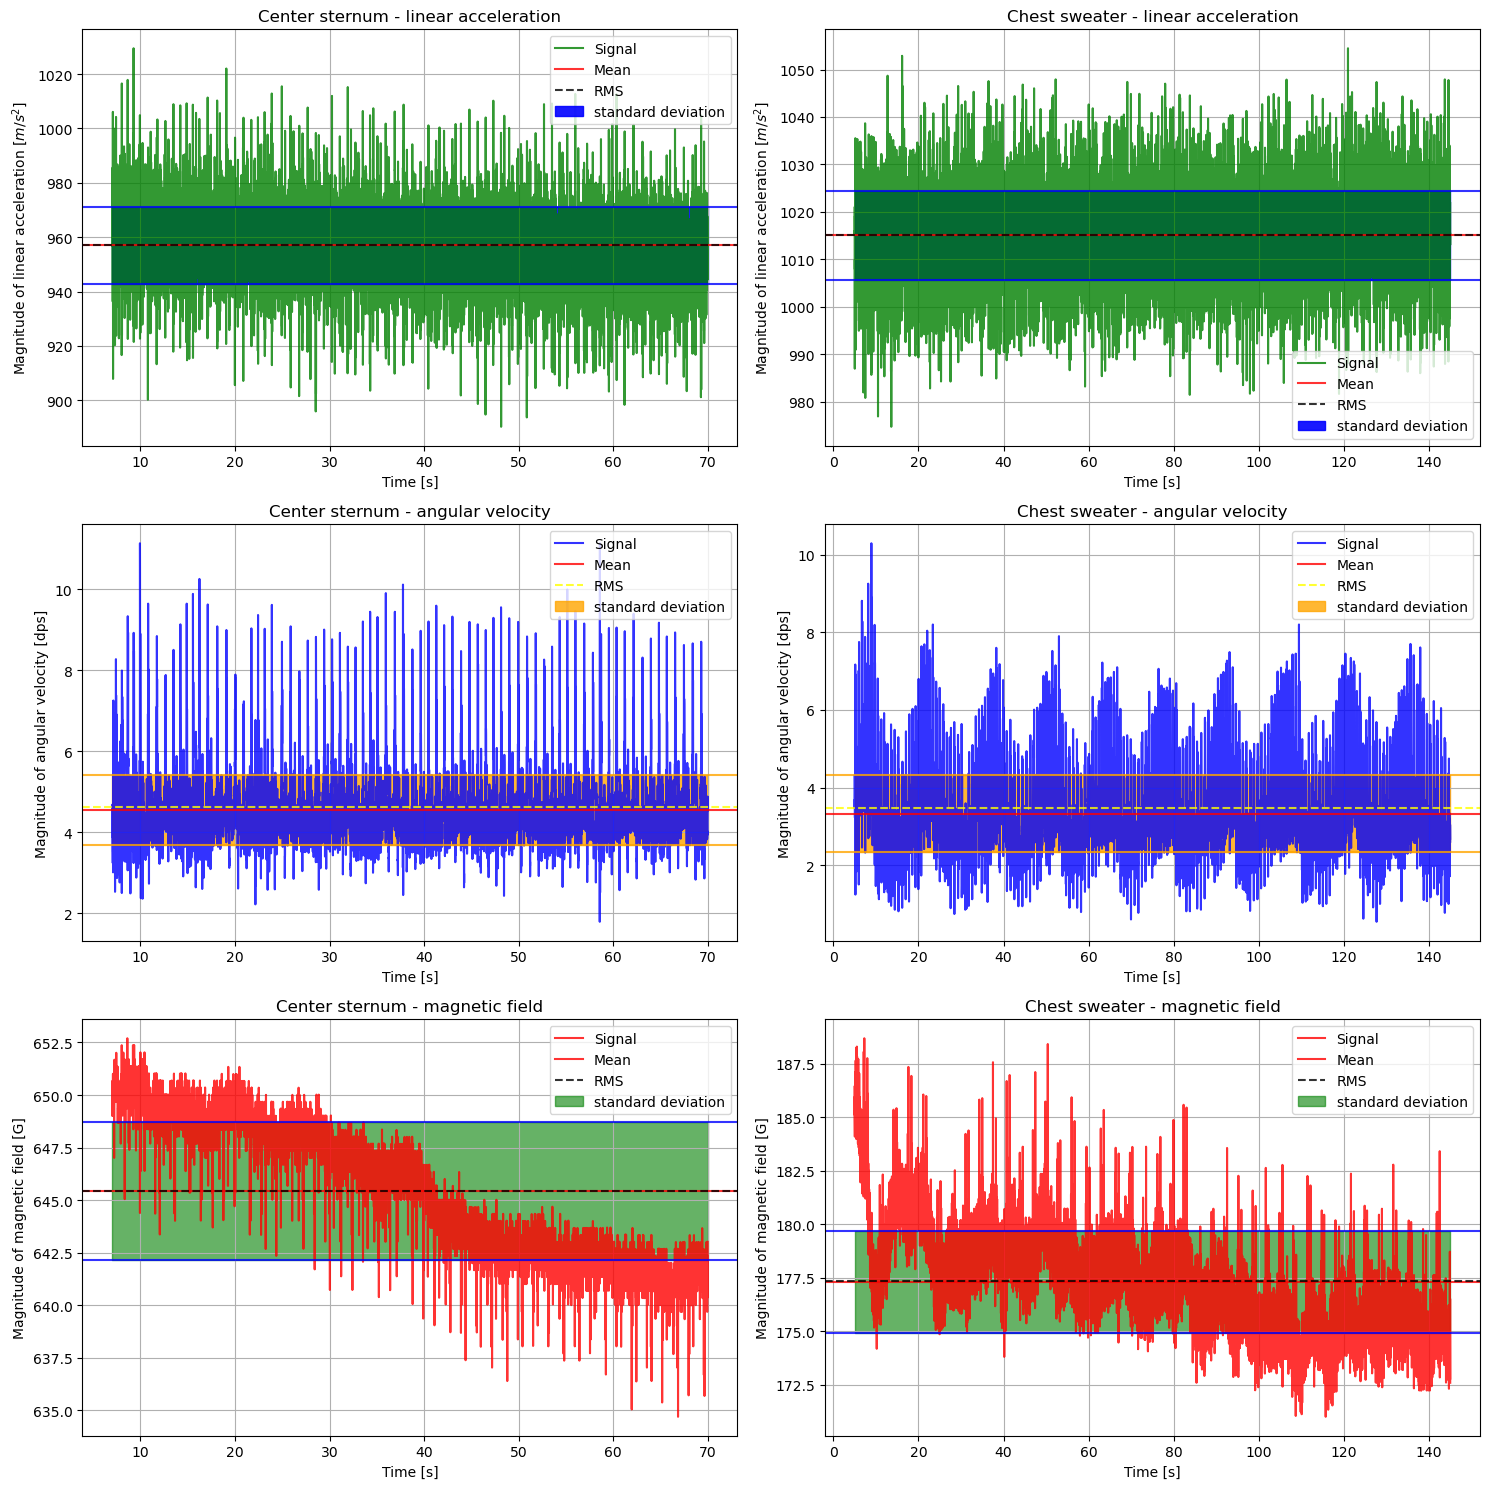

In [27]:
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot linear acceleration
axes[0, 0].plot(center_sternum["Time"], center_sternum["Acc"], color="green", linestyle="-", alpha=0.8, label='Signal')
axes[0, 0].axhline(stat_sternum.iloc[0,0], color="red", linestyle="-", alpha=0.8, label='Mean')
axes[0, 0].axhline(stat_sternum.iloc[11,0], color="black", linestyle="dashed", alpha=0.8, label='RMS')
axes[0, 0].fill_betweenx(y = [stat_sternum.iloc[0,0]-stat_sternum.iloc[3,0], stat_sternum.iloc[0,0]+stat_sternum.iloc[3,0]], 
                         x1 = min(center_sternum.iloc[:,0]), x2 = max(center_sternum.iloc[:,0]), color = 'blue', alpha = 0.9, label = 'standard deviation')
axes[0, 0].axhline(stat_sternum.iloc[0,0]-stat_sternum.iloc[3,0], color="blue", linestyle="-", alpha=0.8)
axes[0, 0].axhline(stat_sternum.iloc[0,0]+stat_sternum.iloc[3,0], color="blue", linestyle="-", alpha=0.8)
axes[0, 0].legend()
axes[0, 0].set_xlabel("Time [s]")
axes[0, 0].set_ylabel("Magnitude of linear acceleration [$m/s^2$]")
axes[0, 0].grid(True)
axes[0, 0].set_title("Center sternum - linear acceleration")

# Plot linear acceleration
axes[0, 1].plot(chest_sweater["Time"], chest_sweater["Acc"], color="green", linestyle="-", alpha=0.8, label='Signal')
axes[0, 1].axhline(stat_chest.iloc[0,0], color="red", linestyle="-", alpha=0.8, label='Mean')
axes[0, 1].axhline(stat_chest.iloc[11,0], color="black", linestyle="dashed", alpha=0.8, label='RMS')
axes[0, 1].fill_betweenx(y = [stat_chest.iloc[0,0]-stat_chest.iloc[3,0], stat_chest.iloc[0,0]+stat_chest.iloc[3,0]], 
                         x1 = min(chest_sweater.iloc[:,0]), x2 = max(chest_sweater.iloc[:,0]), color = 'blue', alpha = 0.9, label = 'standard deviation')
axes[0, 1].axhline(stat_chest.iloc[0,0]-stat_chest.iloc[3,0], color="blue", linestyle="-", alpha=0.8)
axes[0, 1].axhline(stat_chest.iloc[0,0]+stat_chest.iloc[3,0], color="blue", linestyle="-", alpha=0.8)
axes[0, 1].legend()
axes[0, 1].set_xlabel("Time [s]")
axes[0, 1].set_ylabel("Magnitude of linear acceleration [$m/s^2$]")
axes[0, 1].grid(True)
axes[0, 1].set_title("Chest sweater - linear acceleration")

# Plot angular velocity
axes[1, 0].plot(center_sternum["Time"], center_sternum["Gyro"], color="blue", linestyle="-", alpha=0.8, label='Signal')
axes[1, 0].axhline(stat_sternum.iloc[0,1], color="red", linestyle="-", alpha=0.8, label='Mean')
axes[1, 0].axhline(stat_sternum.iloc[11,1], color="yellow", linestyle="dashed", alpha=0.8, label='RMS')
axes[1, 0].fill_betweenx(y = [stat_sternum.iloc[0,1]-stat_sternum.iloc[3,1], stat_sternum.iloc[0,1]+stat_sternum.iloc[3,1]], 
                         x1 = min(center_sternum.iloc[:,0]), x2 = max(center_sternum.iloc[:,0]), color = 'orange', alpha = 0.8, label = 'standard deviation')
axes[1, 0].axhline(stat_sternum.iloc[0,1]-stat_sternum.iloc[3,1], color="orange", linestyle="-", alpha=0.8)
axes[1, 0].axhline(stat_sternum.iloc[0,1]+stat_sternum.iloc[3,1], color="orange", linestyle="-", alpha=0.8)
axes[1, 0].legend()
axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_ylabel("Magnitude of angular velocity [dps]") # dps: degree per second (equal to omega/second)
axes[1, 0].grid(True)
axes[1, 0].set_title("Center sternum - angular velocity")

# Plot angular velocity
axes[1, 1].plot(chest_sweater["Time"], chest_sweater["Gyro"], color="blue", linestyle="-", alpha=0.8, label='Signal')
axes[1, 1].axhline(stat_chest.iloc[0,1], color="red", linestyle="-", alpha=0.8, label='Mean')
axes[1, 1].axhline(stat_chest.iloc[11,1], color="yellow", linestyle="dashed", alpha=0.8, label='RMS')
axes[1, 1].fill_betweenx(y = [stat_chest.iloc[0,1]-stat_chest.iloc[3,1], stat_chest.iloc[0,1]+stat_chest.iloc[3,1]], 
                         x1 = min(chest_sweater.iloc[:,0]), x2 = max(chest_sweater.iloc[:,0]), color = 'orange', alpha = 0.8, label = 'standard deviation')
axes[1, 1].axhline(stat_chest.iloc[0,1]-stat_chest.iloc[3,1], color="orange", linestyle="-", alpha=0.8)
axes[1, 1].axhline(stat_chest.iloc[0,1]+stat_chest.iloc[3,1], color="orange", linestyle="-", alpha=0.8)
axes[1, 1].legend()
axes[1, 1].set_xlabel("Time [s]")
axes[1, 1].set_ylabel("Magnitude of angular velocity [dps]")
axes[1, 1].grid(True)
axes[1, 1].set_title("Chest sweater - angular velocity")

# Plot magnetic field
axes[2, 0].plot(center_sternum["Time"], center_sternum["Magn"], color="red", linestyle="-", alpha=0.8, label='Signal')
axes[2, 0].axhline(stat_sternum.iloc[0,2], color="red", linestyle="-", alpha=0.8, label='Mean')
axes[2, 0].axhline(stat_sternum.iloc[11,2], color="black", linestyle="dashed", alpha=0.8, label='RMS')
axes[2, 0].fill_betweenx(y = [stat_sternum.iloc[0,2]-stat_sternum.iloc[3,2], stat_sternum.iloc[0,2]+stat_sternum.iloc[3,2]], 
                         x1 = min(center_sternum.iloc[:,0]), x2 = max(center_sternum.iloc[:,0]), color = 'green', alpha = 0.6, label = 'standard deviation')
axes[2, 0].axhline(stat_sternum.iloc[0,2]-stat_sternum.iloc[3,2], color="blue", linestyle="-", alpha=0.8)
axes[2, 0].axhline(stat_sternum.iloc[0,2]+stat_sternum.iloc[3,2], color="blue", linestyle="-", alpha=0.8)
axes[2, 0].legend()
axes[2, 0].set_xlabel("Time [s]")
axes[2, 0].set_ylabel("Magnitude of magnetic field [G]")
axes[2, 0].grid(True)
axes[2, 0].set_title("Center sternum - magnetic field")

# Plot magnetic field 
axes[2, 1].plot(chest_sweater["Time"], chest_sweater["Magn"], color="red", linestyle="-", alpha=0.8, label='Signal')
axes[2, 1].axhline(stat_chest.iloc[0,2], color="red", linestyle="-", alpha=0.8, label='Mean')
axes[2, 1].axhline(stat_chest.iloc[11,2], color="black", linestyle="dashed", alpha=0.8, label='RMS')
axes[2, 1].fill_betweenx(y = [stat_chest.iloc[0,2]-stat_chest.iloc[3,2], stat_chest.iloc[0,2]+stat_chest.iloc[3,2]], 
                         x1 = min(chest_sweater.iloc[:,0]), x2 = max(chest_sweater.iloc[:,0]), color = 'green', alpha = 0.6, label = 'standard deviation')
axes[2, 1].axhline(stat_chest.iloc[0,2]-stat_chest.iloc[3,2], color="blue", linestyle="-", alpha=0.8)
axes[2, 1].axhline(stat_chest.iloc[0,2]+stat_chest.iloc[3,2], color="blue", linestyle="-", alpha=0.8)
axes[2, 1].legend()
axes[2, 1].set_xlabel("Time [s]")
axes[2, 1].set_ylabel("Magnitude of magnetic field [G]")
axes[2, 1].grid(True)
axes[2, 1].set_title("Chest sweater - magnetic field")

plt.tight_layout()

plt.show()

__Observations__:

As will be discussed later, some metrics have been drawn on the above graphs. These are helpful in understanding the general trend of the signal. By projecting the mean and the standard deviation, we are able to visually retrieve information as to the expected value of the data and how much it spreads from this line. Obviously, these metrics change according to the time window chosen: as we opted to take a central interval for the signals, we have that the signals do not change drastically within the window and therefore the standard deviation, which represents the spread of the data, is not extremely large even though the presence of noise is noticeable.

### Pearson correlation coefficient
The Pearson correlation coefficient is a method to calculate the correlation coefficient between two random variables $X$ and $Y$. It is one of the most commonly used methods to retrieve the correlation coefficient between to variables and it is actually the default computation implemented by _pandas_ when using the *corr* method, which is a method that returns the correlation matrix of a DataFrame.
It is calculated as follows:
$$\rho_{X,Y} = \frac{cov(X,Y)}{\sigma_X \sigma_Y} $$
where $cov(X,Y)$ is the covariance of the two random variables $X$ and $Y$ and $\sigma$ represents the standard deviation of the corresponding random variable. 
The Pearson correlation coefficients have been computed as part of the statistical analysis of the data in order to determine whether there was any correlation among the (normalized) features of the datasets. By exploiting scipy, we can directly apply the method which then returns two values (visible in the description of *stat_sternum*): 
+ statistic, *float*, which is the Pearson product-moment correlation coefficient.
+ p_value, *float*, which represents the p-value associated with the statistic. We recall that the p-value is the probability that a particular statistical measure will be greater than or equal to observed results.

The Pearson correlation coefficients can be also seen in the heatmap below, which is useful to rapidly state if there are any correlation among the features analyzed.

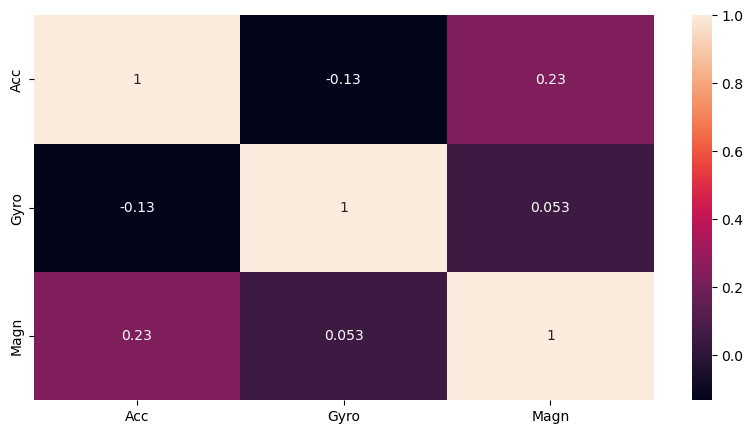

In [28]:
plt.subplots(figsize=(10, 5))
corr_matrix = center_sternum.iloc[:,1:].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)
plt.plot()
plt.show()

### Spearman correlation coefficient
The Spearman correlation coefficient is another useful method to calculate the correlation coefficient between two random variables. In particular, it assesses how well the relationship between two variables can be described using a monotonic function.
The Spearman rank correlation coefficient, denoted by $r_s$, between two variables $X$ and $Y$, is mathematically equivalent to the Pearson correlation coefficient, denoted by $\rho_{X,Y}$, calculated on the ranks of those variables ($R_X$ and $R_Y$, respectively). In simpler terms, the Spearman correlation quantifies the strength and direction of the monotonic relationship between X and Y, regardless of its linearity, by analyzing the relationship between their corresponding rank values. Conversely, the Pearson correlation only measures the strength and direction of a linear relationship.

It is calculated as follows:
$$ r_s = \rho_{R_X,R_Y} = \frac{cov(R(X),R(Y))}{\sigma_{R(X)} \sigma_{R(Y)}} $$
where $R(X)$ and $R(Y)$ represent the *rank* of the corresponding random variable. 
The rank of a variable  refers to its ordinal position within a group of observations, sorted according to its values The other quantities are the same as those in the Pearson correlation coefficient, with the difference that instead of having the random variable there is the rank of the random variable.

Also the Spearman correlation coefficient has been used as a metric in the statistical analysis of the datasets: in particular it has been used to confirm the results given by the Pearson correlation coefficient, thus making the results more robusts. Just like with Pearson, Spearman correlation coefficient can be directly applied with scipy, returning two values:
+ statistic, *float* or *ndarray*, which is the Pearson product-moment correlation coefficient.
+ p_value, *float*, which represents the p-value associated with the statistic.

Again, the values of the correlation coefficients (with the Spearman method in this case) can be seen in the heatmap below, obtained using the *corr* method of pandas and passing the method 'spearman'.

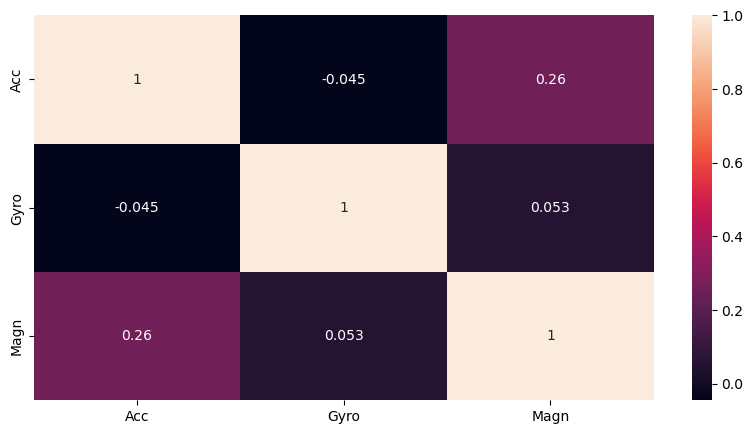

In [29]:
plt.subplots(figsize=(10, 5))
corr_matrix = center_sternum.iloc[:,1:].corr(method='spearman')
sns.heatmap(corr_matrix, annot=True)
plt.plot()
plt.show()

In [30]:
stat_chest

Acc          Gyro        Magn
Mean          1.015057e+03  3.336205e+00  177.313367
Median        1.015070e+03  3.210000e+00  177.140000
Variance      8.663154e+01  9.869383e-01    5.727614
Std           9.307607e+00  9.934477e-01    2.393243
25% quantile  1.009355e+03  2.690000e+00  175.570000
50% quantile  1.015070e+03  3.210000e+00  177.140000
75% quantile  1.020805e+03  3.820000e+00  178.710000
Stat_P       -4.511204e-02  7.288081e-02   -0.029639
p_value_P     9.305969e-08  5.935796e-18    0.000453
Stat_S       -2.943251e-02  3.303690e-02   -0.035206
p_value_S     4.961606e-04  9.246554e-05    0.000031
RMS           1.015099e+03  3.480978e+00  177.329517

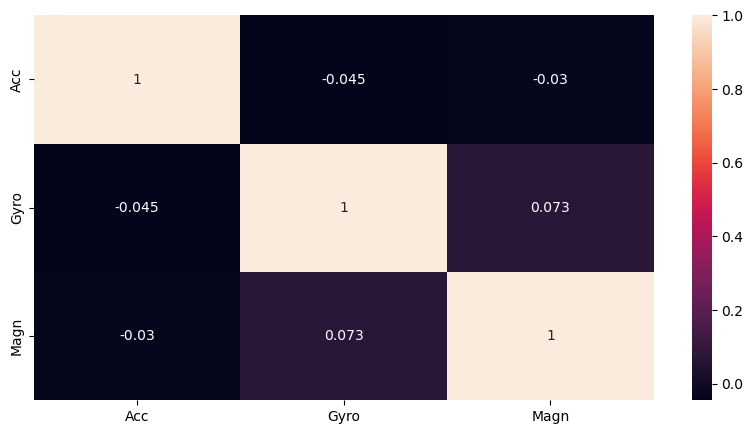

In [31]:
plt.subplots(figsize=(10,5))
corr_matrix = chest_sweater.iloc[:,1:].corr(method='pearson')
sns.heatmap(corr_matrix, annot=True)
plt.plot()
plt.show()

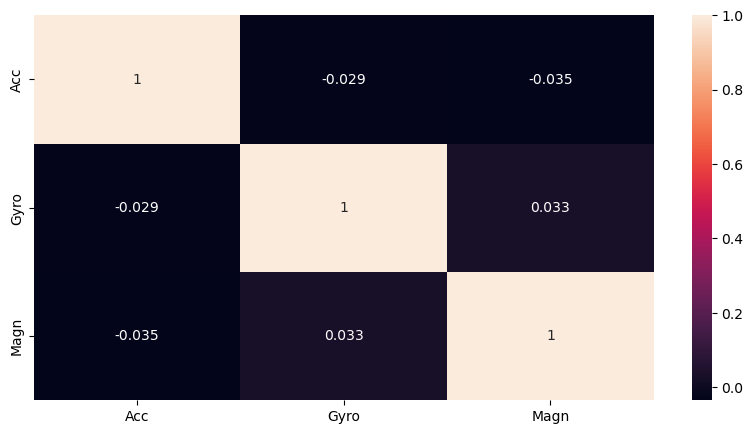

In [32]:
plt.subplots(figsize=(10,5))
corr_matrix = chest_sweater.iloc[:,1:].corr(method='spearman')
sns.heatmap(corr_matrix, annot=True)
plt.plot()
plt.show()

### Observations on statistical analysis of the data
Mean and Standard deviation could deliver useful information regarding the data: these metrics can capture the central tendency and the spread of each 
feature, which could reflect noticeable behaviour to determine a healthy heart rate.
By looking at the 25% and 75% quantile we are able to identify where most of the data relies, thus obtaining information about outliers.
Instead, median and variance are less interesting: this is due to the former not being descriptive of the data and the latter being sensitive to 
outliers. 

RMS, or Root Mean Square, is another metric that can be interesting to be delved into, as it is more robust than the mean previously calculated.
The mean, the standard deviation and the RMS have also been implemented in the graphs, so that it is easier to see how well they can capture the trend of the data: even though there is much noise, we are able to see how data behaves and get a more complete understanding of the data.

By inspecting both of the correlation matrix we are able to determine that the three features (Acceleration, Gyroscope and Magnitude) have very little correlation among each other, meaning that we cannot consider just one feature or a combination of features if we want to be exhaustive: we need to keep all the features and study their behaviour during the experiment. In order to be more sure about these conclusions, the correlation coefficients have been computed using the Pearson and the Spearman method, both returning the same results: the correlation coefficients are very little and therefore there is no correlation among the features.

### Frequency analysis

In [72]:
def compute_and_plot_FFT(data, sampling_freq):
    '''
    This method computes the FFT of the array given in input and returns the DFT of it with the corresponding frequencies and peaks, while also plotting it.
    Extended version: the input can be a multidimensional array and the DFT is computed for every cell in it. The plots are shown next to each other.
    Moreover, for each plot the maximum of the spectrum is found and a dashed vertical line is plotted on that position.
    '''
    graphs = data.shape[1]
    dfts = []
    frequencies = []
    peaks = []
    fSamp = sampling_freq
    time_step = 1/fSamp
    fig, ax = plt.subplots(graphs, 1, figsize=(5*graphs,5*graphs))  # len(data) rows, one column
    for i in range(graphs):
        x = data.iloc[:,i]
        n = len(x)
        X = np.fft.fft(x) 
        freq = np.fft.fftfreq(X.size, 1/fSamp)
        power = np.abs(X) 
        sample_freq = fftpack.fftfreq(X.size, d=time_step)
        pos_mask = np.where(sample_freq > 0)
        freqs = sample_freq[pos_mask]
        powes = power[pos_mask]
        peak_freq = freqs[powes.argmax()]
        X = np.fft.fftshift(X)
        freq = np.fft.fftshift(freq)
        dfts.append(X)
        frequencies.append(freq)
        peaks.append(peak_freq)
        print("The peak of the spectrum of the FFT", data.columns[i], "can be found in the frequency:", peak_freq)
        # Plot data on the i-th subplot
        ax[i].grid(True)
        ax[i].vlines(x=peak_freq, ymin=min(10*np.log(np.abs(dfts[i]))), ymax=max(10*np.log(np.abs(dfts[i]))), color='orange', alpha=0.8, linestyle='dashed', label='Highest magnitude (positive freq)')
        ax[i].vlines(x=-peak_freq, ymin=min(10*np.log(np.abs(dfts[i]))), ymax=max(10*np.log(np.abs(dfts[i]))), color='brown', alpha=0.8, linestyle='dashed', label='Highest magnitude (negative freq)')
        if i==0:
            ax[i].plot(freq, 10*np.log(np.abs(dfts[i])), alpha = 0.7, label='Spectrum of the FFT', color='green')
            ax[i].set_title('Spectrum of the linear acceleration')
        if i==1:
            ax[i].plot(freq, 10*np.log(np.abs(dfts[i])), alpha = 0.7, label='Spectrum of the FFT', color='blue')
            ax[i].set_title('Spectrum of the angular acceleration')
        if i==2: 
            ax[i].plot(freq, 10*np.log(np.abs(dfts[i])), alpha = 0.7, label='Spectrum of the FFT', color='red')
            ax[i].set_title('Spectrum of the magnitude of the magnetic field')
        ax[i].set_ylabel('Magnitude of the FFT (in Db)')
        ax[i].set_xlabel('Frequency (in Hz)')
        ax[i].legend()
    plt.show()
    return dfts, frequencies, peaks

The peak of the spectrum of the FFT Acc can be found in the frequency: 0.015874275736169535
The peak of the spectrum of the FFT Gyro can be found in the frequency: 1.1588221287403762
The peak of the spectrum of the FFT Magn can be found in the frequency: 0.015874275736169535


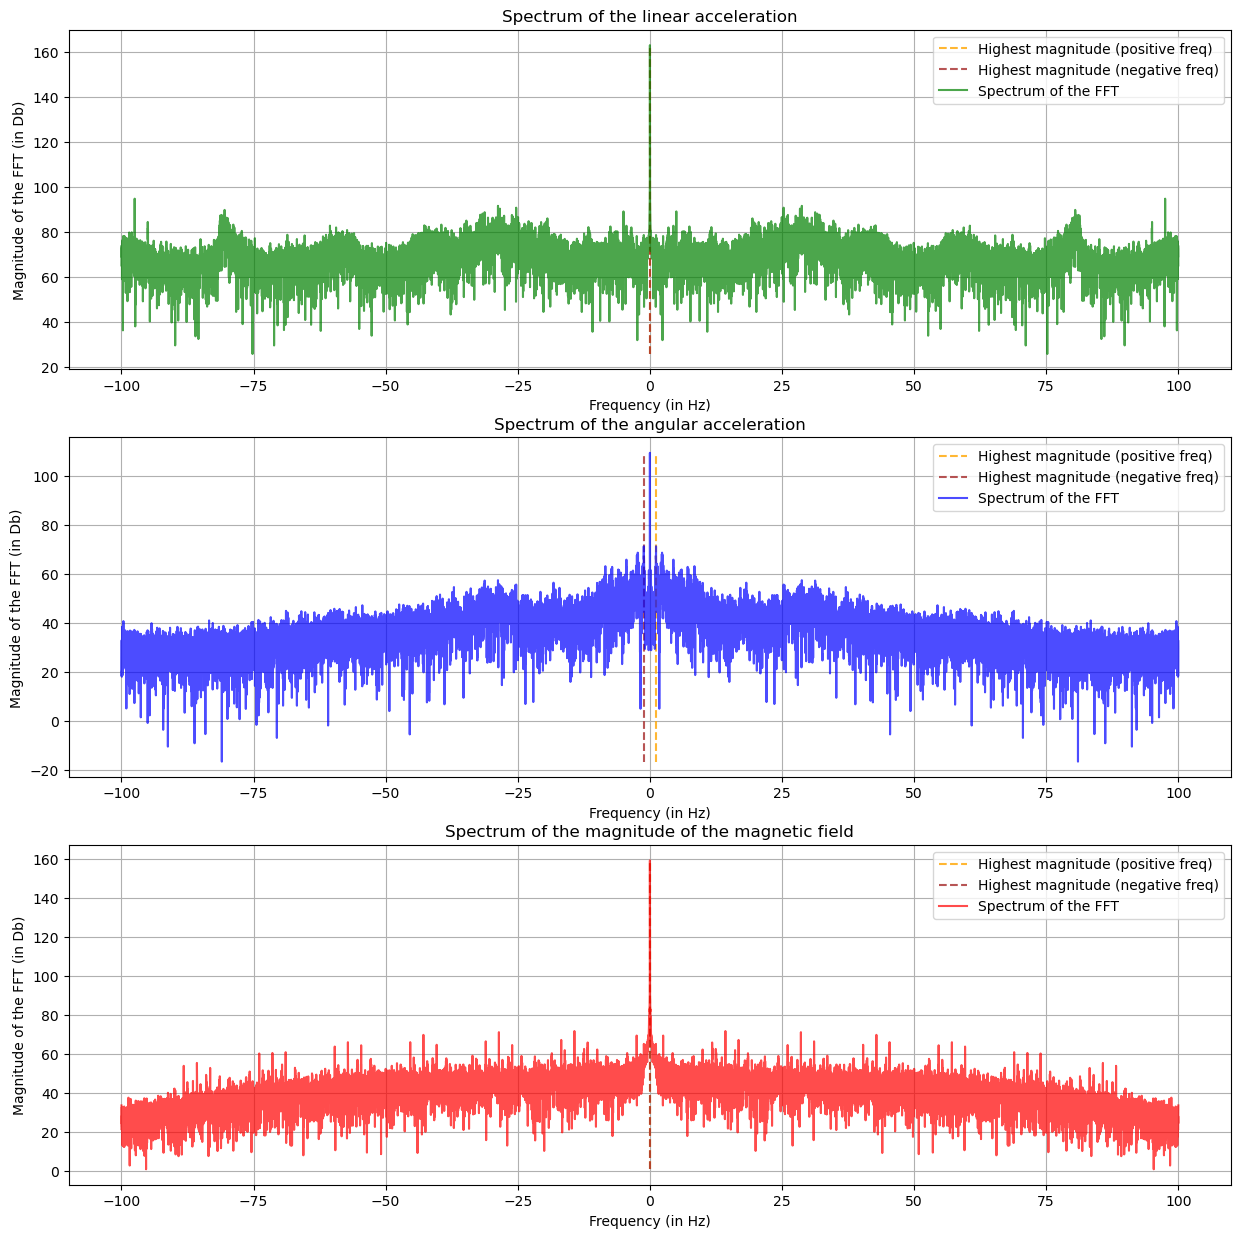

In [34]:
fSamp_sternum = 200
dft_sternum, freq_sternum, peak_sternum = compute_and_plot_FFT(center_sternum.iloc[:, 1:4], fSamp_sternum)

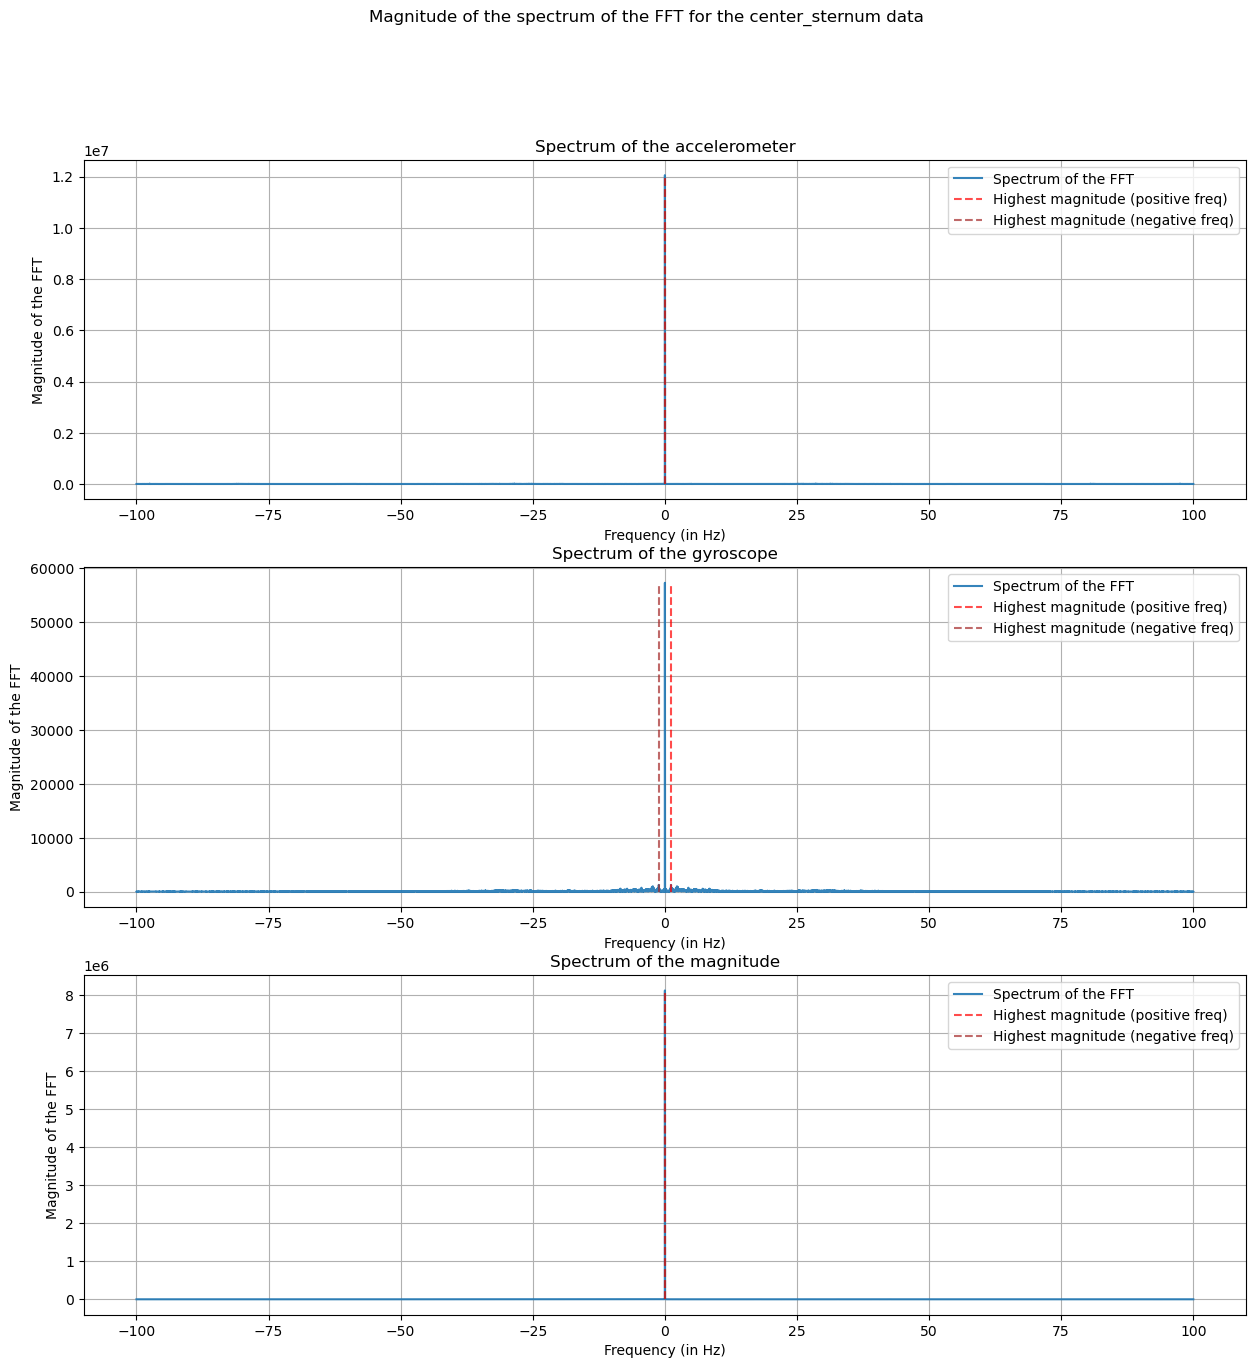

In [35]:
fig, ax = plt.subplots(3, 1, figsize=(15,15))
plt.suptitle('Magnitude of the spectrum of the FFT for the center_sternum data')
for i in range(len(dft_sternum)):
    ax[i].plot(freq_sternum[i], np.abs(dft_sternum[i]), alpha = 0.9, label='Spectrum of the FFT')
    ax[i].vlines(peak_sternum[i], ymin=min(np.abs(dft_sternum[i])), ymax=max(np.abs(dft_sternum[i])), alpha=0.7, color='r', linestyle='dashed', label='Highest magnitude (positive freq)')
    ax[i].vlines(-peak_sternum[i], ymin=min(np.abs(dft_sternum[i])), ymax=max(np.abs(dft_sternum[i])), alpha=0.7, color='brown', linestyle='dashed', label='Highest magnitude (negative freq)')
    ax[i].legend()
    ax[i].grid()
    if i==0:
        ax[i].set_title('Spectrum of the accelerometer')
    if i==1: 
        ax[i].set_title('Spectrum of the gyroscope')
    if i==2: 
        ax[i].set_title('Spectrum of the magnitude')
    ax[i].set_ylabel('Magnitude of the FFT')
    ax[i].set_xlabel('Frequency (in Hz)')

The following graphs show the behaviour of the FFT near the 0Hz frequency and where is the real maximum of the magnitude of the spectrum of the FFT instead. This shows that the value of the spike shown on the 0Hz frequency is due to noise and artifacts and it is not a value found by the instruments.


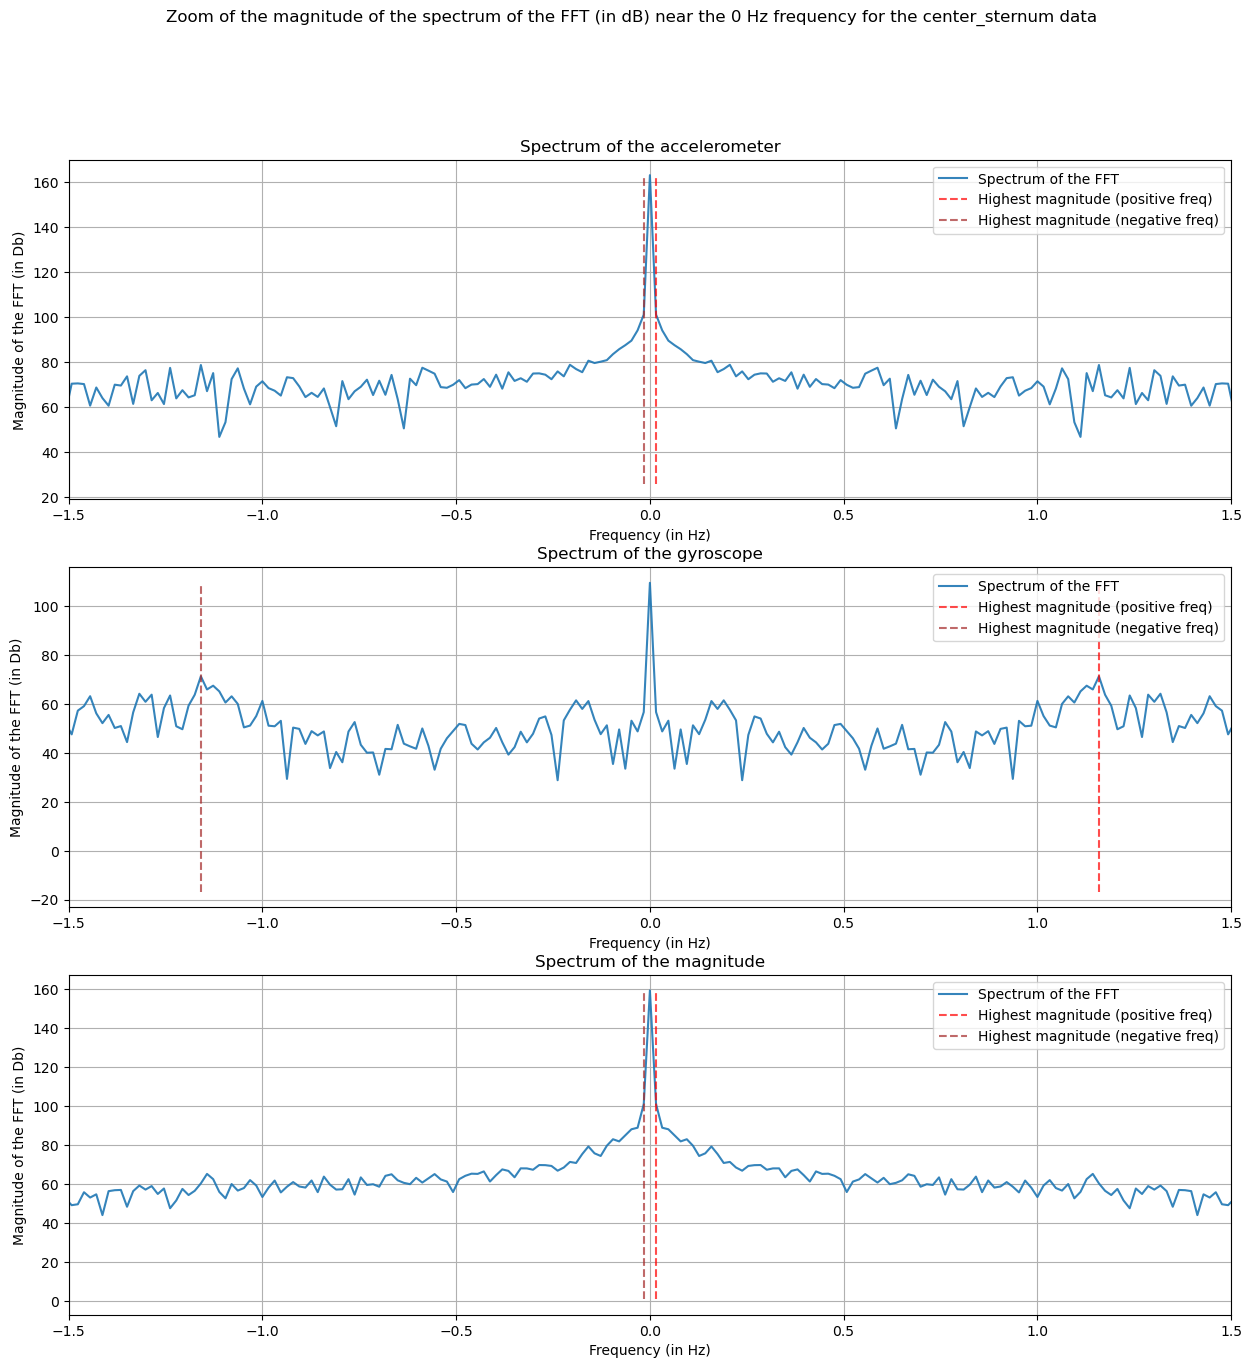

In [36]:
print('The following graphs show the behaviour of the FFT near the 0Hz frequency and where is the real maximum of the magnitude of the spectrum of the \
FFT instead. This shows that the value of the spike shown on the 0Hz frequency is due to noise and artifacts and it is not a value found by the instruments.')
fig, ax = plt.subplots(3, 1, figsize=(15,15))
plt.suptitle('Zoom of the magnitude of the spectrum of the FFT (in dB) near the 0 Hz frequency for the center_sternum data')
for i in range(len(dft_sternum)):
    ax[i].plot(freq_sternum[i], 10*np.log(np.abs(dft_sternum[i])), alpha = 0.9, label='Spectrum of the FFT')
    ax[i].vlines(peak_sternum[i], ymin=min(10*np.log(np.abs(dft_sternum[i]))), ymax=max(10*np.log(np.abs(dft_sternum[i]))), alpha=0.7, color='r', linestyle='dashed', label='Highest magnitude (positive freq)')
    ax[i].vlines(-peak_sternum[i], ymin=min(10*np.log(np.abs(dft_sternum[i]))), ymax=max(10*np.log(np.abs(dft_sternum[i]))), alpha=0.7, color='brown', linestyle='dashed', label='Highest magnitude (negative freq)')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_xlim(-1.5,1.5)
    if i==0:
        ax[i].set_title('Spectrum of the accelerometer')
    if i==1: 
        ax[i].set_title('Spectrum of the gyroscope')
    if i==2: 
        ax[i].set_title('Spectrum of the magnitude')
    ax[i].set_ylabel('Magnitude of the FFT (in Db)')
    ax[i].set_xlabel('Frequency (in Hz)')

### Comments on the frequency analysis of the first dataset (center_sternum.txt)
The spike located in the 0Hz frequency is due to artifacts and it is not an actual signal component. The cause of these could be many, including:
- a DC offset, so a bias in the data
- numerical issues
- leakage, caused by the choice of the window function.
#### Analysis of the spectra
In the graph we can observe the spike in the 0Hz frequency, but most importantly we are also able to determine the peak frequencies that represent the principal component of the signal: this correspond to the value(s) that have the highest impact on the signal.

The peak of the spectrum of the FFT Acc can be found in the frequency: 0.30716479748553466
The peak of the spectrum of the FFT Gyro can be found in the frequency: 0.07143367383384527
The peak of the spectrum of the FFT Magn can be found in the frequency: 0.007143367383384527


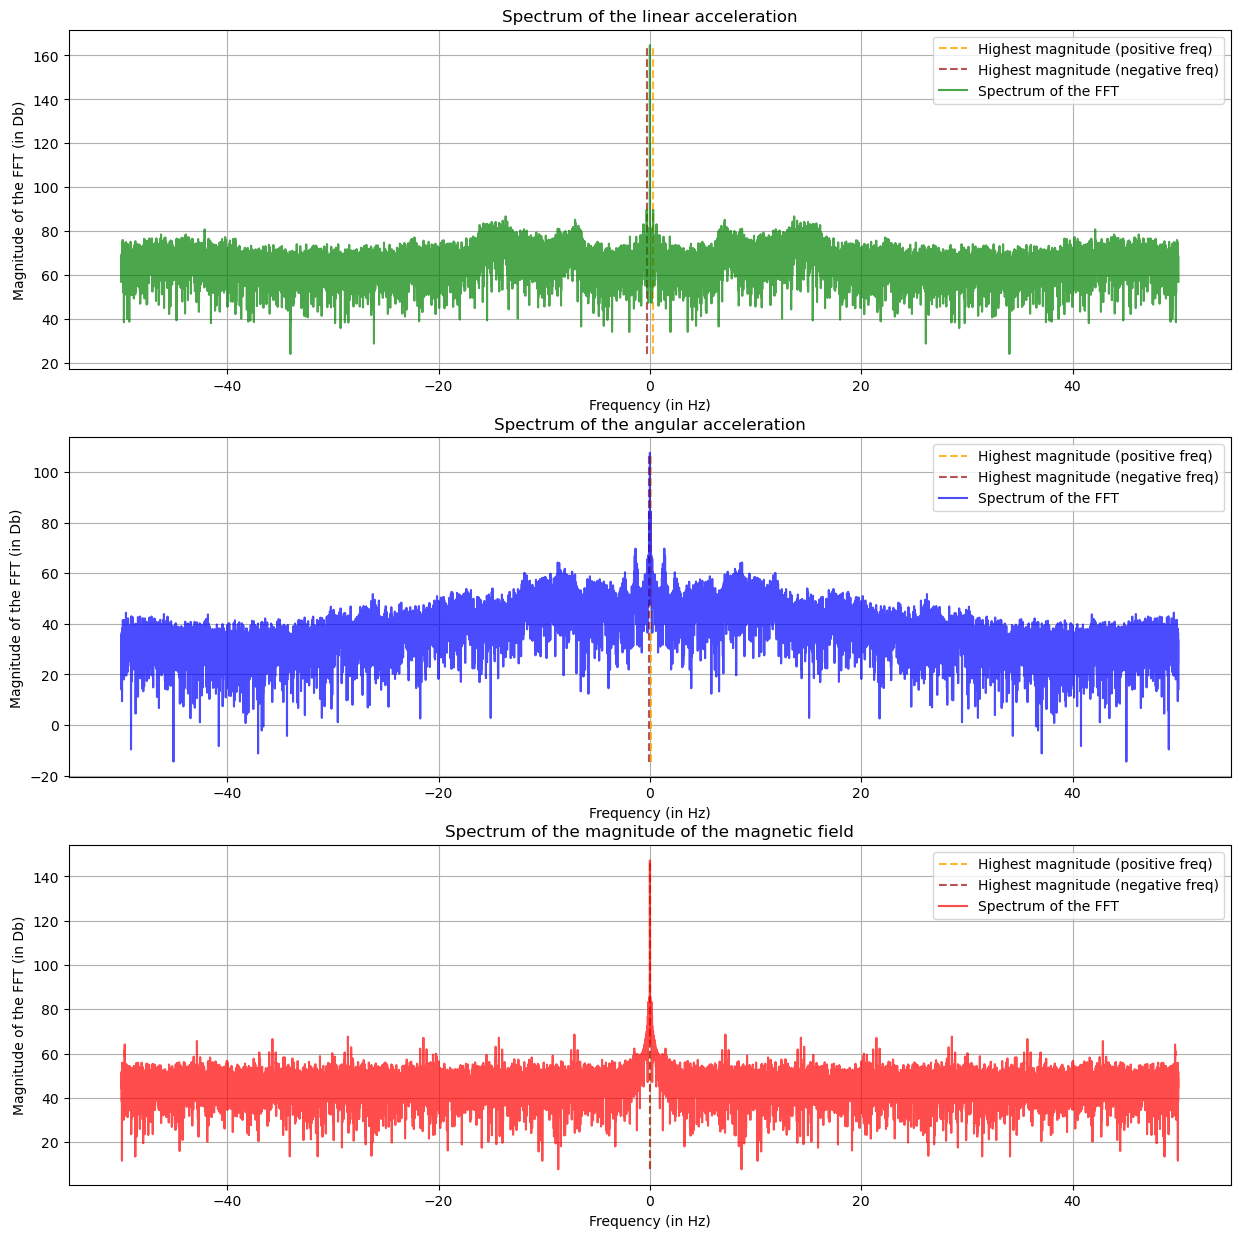

In [37]:
fSamp_chest = 100
dft_chest, freq_chest, peak_chest = compute_and_plot_FFT(chest_sweater.iloc[:, 1:4], fSamp_chest)

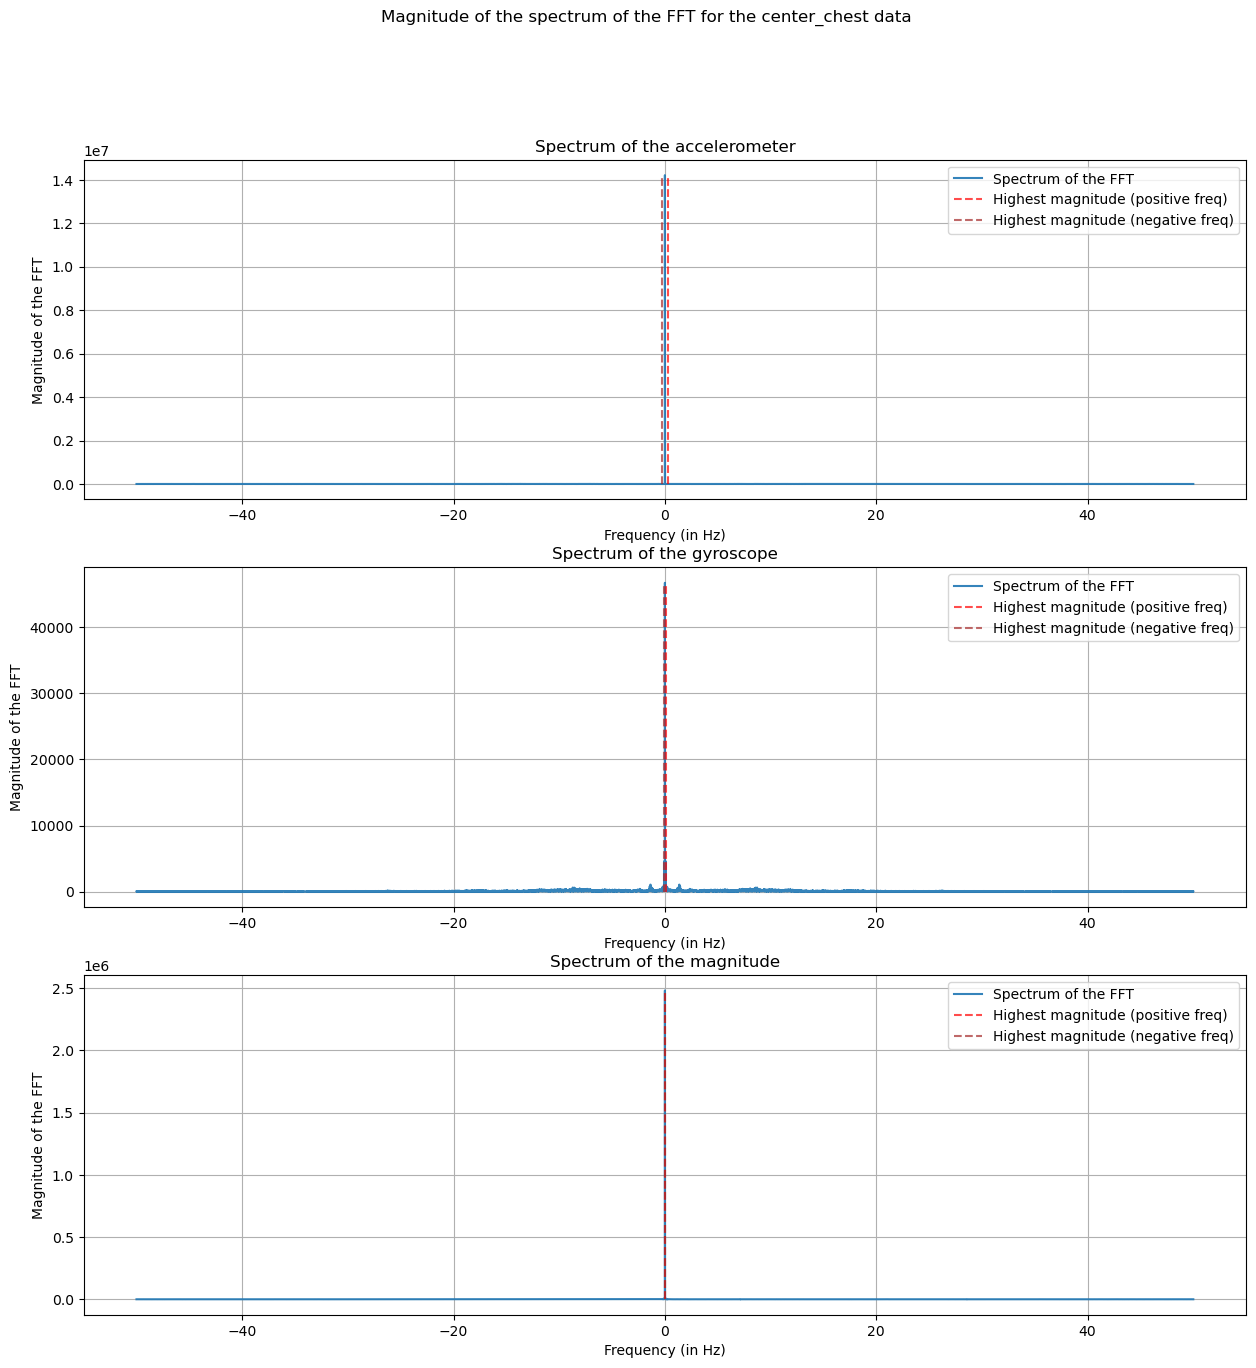

In [38]:
fig, ax = plt.subplots(3, 1, figsize=(15,15))
plt.suptitle('Magnitude of the spectrum of the FFT for the center_chest data')
for i in range(len(dft_chest)):
    ax[i].plot(freq_chest[i], np.abs(dft_chest[i]), alpha = 0.9, label='Spectrum of the FFT')
    ax[i].vlines(peak_chest[i], ymin=min(np.abs(dft_chest[i])), ymax=max(np.abs(dft_chest[i])), alpha=0.7, color='r', linestyle='dashed', label='Highest magnitude (positive freq)')
    ax[i].vlines(-peak_chest[i], ymin=min(np.abs(dft_chest[i])), ymax=max(np.abs(dft_chest[i])), alpha=0.7, color='brown', linestyle='dashed', label='Highest magnitude (negative freq)')
    ax[i].legend()
    ax[i].grid()
    if i==0:
        ax[i].set_title('Spectrum of the accelerometer')
    if i==1: 
        ax[i].set_title('Spectrum of the gyroscope')
    if i==2: 
        ax[i].set_title('Spectrum of the magnitude')
    ax[i].set_ylabel('Magnitude of the FFT')
    ax[i].set_xlabel('Frequency (in Hz)')

The following graphs show the behaviour of the FFT near the 0Hz frequency and where is the real maximum of the magnitude of the spectrum of the FFT instead. This shows that the value of the spike shown on the 0Hz frequency is due to noise and artifacts and it is not a value found by the instruments.


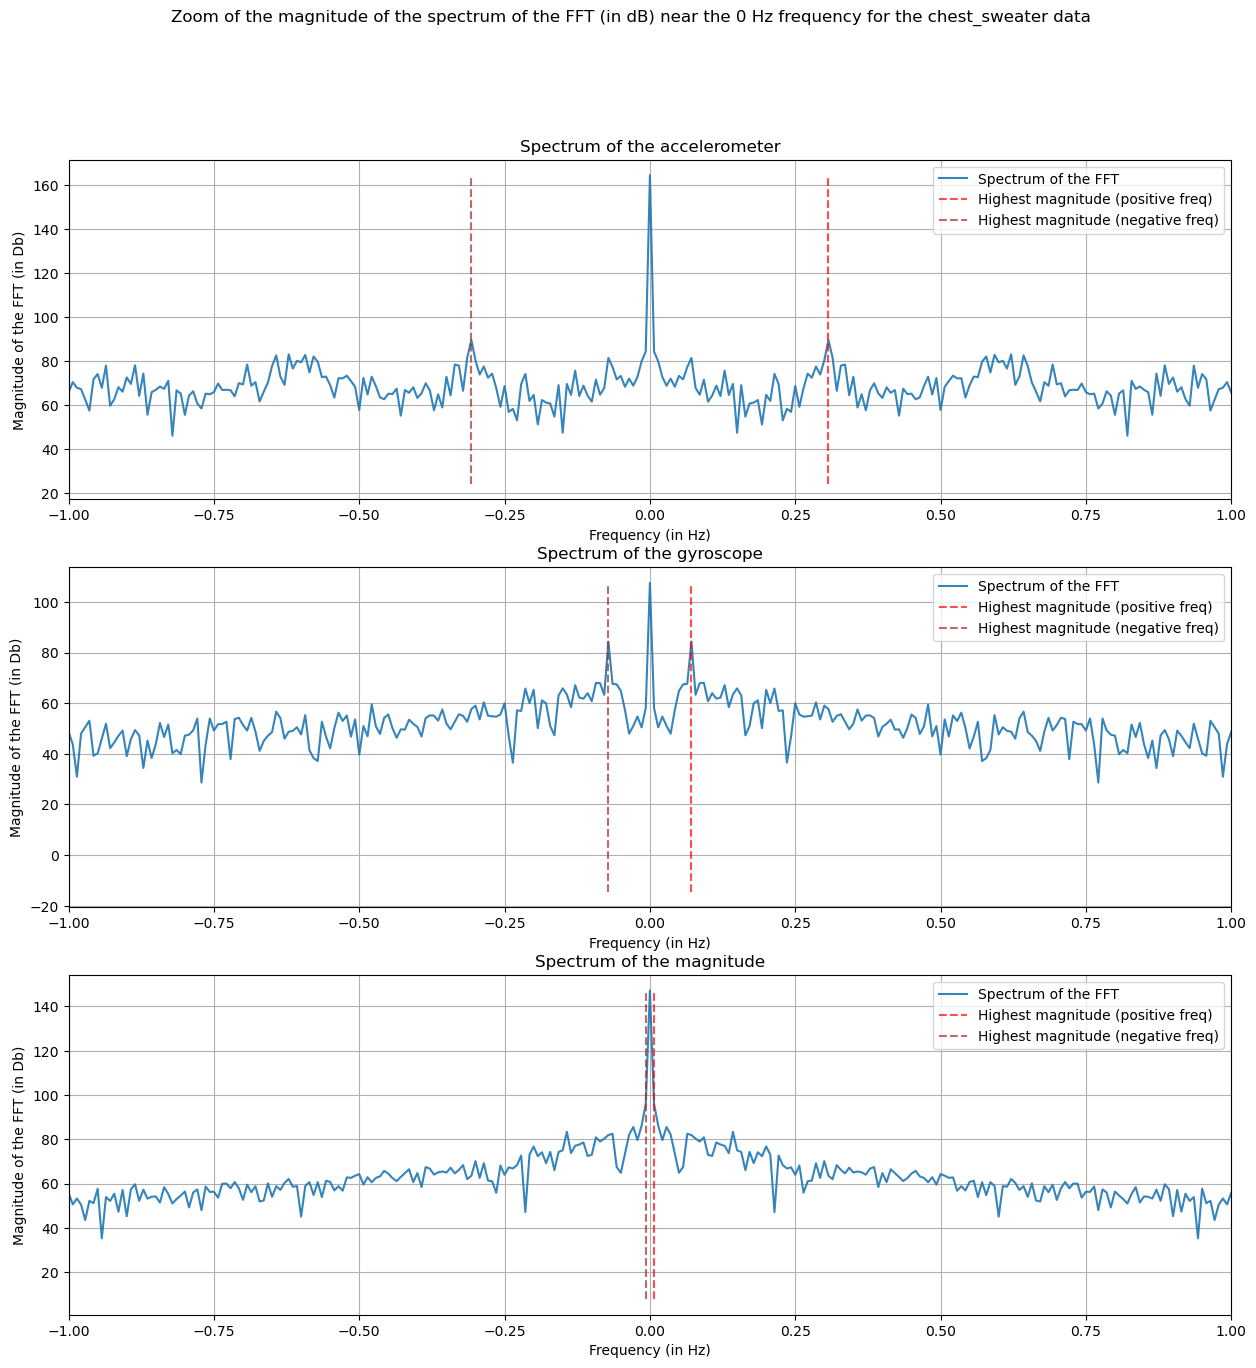

In [39]:
print('The following graphs show the behaviour of the FFT near the 0Hz frequency and where is the real maximum of the magnitude of the spectrum of the \
FFT instead. This shows that the value of the spike shown on the 0Hz frequency is due to noise and artifacts and it is not a value found by the instruments.')
fig, ax = plt.subplots(3, 1, figsize=(15,15))
plt.suptitle('Zoom of the magnitude of the spectrum of the FFT (in dB) near the 0 Hz frequency for the chest_sweater data')
for i in range(len(dft_chest)):
    ax[i].plot(freq_chest[i], 10*np.log(np.abs(dft_chest[i])), alpha = 0.9, label='Spectrum of the FFT')
    ax[i].vlines(peak_chest[i], ymin=min(10*np.log(np.abs(dft_chest[i]))), ymax=max(10*np.log(np.abs(dft_chest[i]))), alpha=0.7, color='r', linestyle='dashed', label='Highest magnitude (positive freq)')
    ax[i].vlines(-peak_chest[i], ymin=min(10*np.log(np.abs(dft_chest[i]))), ymax=max(10*np.log(np.abs(dft_chest[i]))), alpha=0.7, color='brown', linestyle='dashed', label='Highest magnitude (negative freq)')
    ax[i].legend()
    ax[i].grid()
    ax[i].set_xlim(-1,1)
    if i==0:
        ax[i].set_title('Spectrum of the accelerometer')
    if i==1: 
        ax[i].set_title('Spectrum of the gyroscope')
    if i==2: 
        ax[i].set_title('Spectrum of the magnitude')
    ax[i].set_ylabel('Magnitude of the FFT (in Db)')
    ax[i].set_xlabel('Frequency (in Hz)')

### Comments on the frequency analysis of the second dataset (4_Chest_sweater.txt)
Also in this case we can notice a spike located in the 0Hz frequency, which is again due to artifacts and it is not an actual signal component. The cause of these could be many, including as said before:
- a DC offset, so a bias in the data
- numerical issues
- leakage, caused by the choice of the window function.
#### Analysis of the spectra
The are met with the same situation as the case of the first dataset. In the graph we can observe the spike in the 0Hz frequency, but most importantly we are also able to determine the peak frequencies that represent the principal component of the signal: this correspond to the value(s) that have the highest impact on the signal.

__Observations__:

Analyzing the spectra of the FFT of the components in both linear and logarithmic (decibel) scale enabled us to understand how the signal behaves: by inspecting the linear scale we are not able to retrieve much information, as the graph is almost composed by just an horizontal line and a spike in the middle. By inspecting the FFT in decibel we are instead able to see how the spectra behave, thus making it possible to look also for repeating patterns or other useful insights. Finally, the zoom around the 0 Hz frequency is of great help in visually seeing the peak frequency in the spectra.


For the next part I suggest to implement a low-pass filter for both datasets: in this way we will be able to retrieve the principal components of the signal while also removing noise from the data. The result will show a much smoother signal with respect to the original signal.

# Filter by Ledia Pampagnin

"In the figure below we show a typical (that means of a healthy subject)  BCG acceleration signal in the longitudinal axis (y). Its components for the different peaks represent the different phases of one full cardiac cycle: in fact, waves can be classified as pre-systolic (F, G), systolic (H, I, J, K), and diastolic (L, M, N). The most characteristic J-wave describes the acceleration of blood in the descending and abdominal aorta, and the deceleration of blood in the ascending aorta."<br>

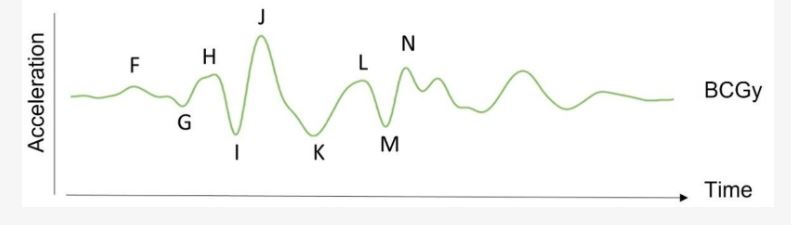

In [40]:
Image("BGC_waveform_y.jpg", width = 600)

ECG and BGC signals are affected by __noise__;  the __sensors’ joint to the chest or sternum and motion artifacts__ are the primary causes of their contamination. <br>
Artifacts can be also caused by chest movement during the __respiration__ and they could be used to get information about the respiratory rate and amplitude; despite this, our goal is extrapolating the heart rate signal from data recorded, so we have to remove them. <br>
The artifacts are often removed using __band-pass filters__: directly from Fourier Analysis, we look for the most interesting frequency band. From the spectrum of the BCG signal it's possible to understand which are the frequency components that correspond to the peaks in the BCG signal and contain the information we need. <br> <br>

_Sources_: <br>
- _2012 International Workshop on Information and Electronics Engineering (IWIEE) - Ballistocardiogram Insusceptibility Detection and Analysis System on FPGA_<br>
- _Sensors 2022, 22(23), 9565; https://doi.org/10.3390/s22239565_

## 1st method: Bandpass filter

The main problem is that the components of breath and heart rate have overlapping spectra in the frequency domain.
To completely remove the respiratory component we can use a very selective cutoff frequency.

A good solution could be applying a FIR bandpass filter which retains only frequencies that  that deviate from the peak frequency within a certain threshold: the others are considered "noise" and for this reason are set to zero. <br><br>
Observing the BGC signal spectrum we see that there're main peaks at low frequencies (reported in the paragraph _Analysis of the spectra_). 

The following function takes in input the FFT transform of the signal and the corresponded sampled frequencies. <br>Moreover, we can specify a threshold: it represents "how much can a frequency value differs from the peak frequency in order to not be considered noise". <br>
As first and brute approach we want to show what happens if we keep only the information contained in that peak-frequency. We set the threshold to zero and the filter keeps only the peak frequency and nulls all the others.<br>

In [41]:
def filter(fft_signal, fft_freqs, fSamp,peak_f, threshold=0):
    fft_filtered = np.copy(fft_signal)
    #take the sampling frequencies -> they're the positive frequencies passed as input 
    freq = np.copy(fft_freqs)
    #create the mask of the bandpass filter
    put_to_zero = np.where(abs(freq) - peak_f > threshold)
    fft_filtered[put_to_zero] = 0
    return fft_filtered

Function to compare the original and filtered signals

In [42]:
def plot_filtered_and_original(df, filtered_signals, name_data_file):
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))

    # Plot linear acceleration
    axes[0].plot(df["Time"], df["Acc"], color="orange", linestyle="-", alpha=0.5, label="original_signal")
    axes[0].plot(df["Time"], filtered_signals[0], color="black", linestyle="-", linewidth=1, alpha=1, label = "filtered_signal")
    axes[0].set_xlabel("Time [s]")
    axes[0].set_ylabel("Magnitude of linear acceleration [$m/s^2$]")
    axes[0].grid(True)
    axes[0].set_title("%s - linear acceleration" % name_data_file)
    axes[0].legend()

    # Plot angular velocity
    axes[1].plot(df["Time"], df["Gyro"], color="cyan", linestyle="-", alpha=0.5, label="original_signal")
    axes[1].plot(df["Time"], filtered_signals[1], color="black", linestyle="-", linewidth=1, alpha=1, label = "filtered_signal")
    axes[1].set_xlabel("Time [s]")
    axes[1].set_ylabel("Magnitude of angular velocity [dps]") # dps: degree per second (equal to omega/second)
    axes[1].grid(True)
    axes[1].set_title("%s- angular velocity" % name_data_file)
    axes[1].legend()
    
    # Plot magnetic field 
    axes[2].plot(df["Time"], df["Magn"], color="red", linestyle="-", alpha=0.5, label="original_signal")
    axes[2].plot(df["Time"], filtered_signals[2], color="black", linestyle="-", linewidth=1, alpha=1, label = "filtered_signal")
    axes[2].set_xlabel("Time [s]")
    axes[2].set_ylabel("Magnitude of magnetic field [G]")
    axes[2].grid(True)
    axes[2].set_title("%s - magnetic field" % name_data_file)
    axes[2].legend()

To plot data with zoom in time range = [30,40] seconds 

In [43]:
def plot_filtered_and_original_zoom(df, filtered_signals, name_data_file, ylimits):
    fig, axes = plt.subplots(3, 1, figsize=(15, 15))

    # Plot linear acceleration
    axes[0].plot(df["Time"], df["Acc"], color="orange", linestyle="-", alpha=0.5, label="original_signal")
    axes[0].plot(df["Time"], filtered_signals[0], color="black", linestyle="-", linewidth=1, alpha=1, label = "filtered_signal")
    axes[0].set_xlabel("Time [s]")
    axes[0].set_ylabel("Magnitude of linear acceleration [$m/s^2$]")
    axes[0].set_xlim(30,40)
    axes[0].set_ylim(ylimits[0][0],ylimits[0][1])
    axes[0].grid(True)
    axes[0].set_title("%s - linear acceleration" % name_data_file)
    axes[0].legend()

    # Plot angular velocity
    axes[1].plot(df["Time"], df["Gyro"], color="cyan", linestyle="-", alpha=0.5, label="original_signal")
    axes[1].plot(df["Time"], filtered_signals[1], color="black", linestyle="-", linewidth=1, alpha=1, label = "filtered_signal")
    axes[1].set_xlabel("Time [s]")
    axes[1].set_xlim(30,40)
    axes[1].set_ylim(ylimits[1][0],ylimits[1][1])
    axes[1].set_ylabel("Magnitude of angular velocity [dps]") # dps: degree per second (equal to omega/second)
    axes[1].grid(True)
    axes[1].set_title("%s- angular velocity" % name_data_file)
    axes[1].legend()
    
    # Plot magnetic field 
    axes[2].plot(df["Time"], df["Magn"], color="red", linestyle="-", alpha=0.5, label="original_signal")
    axes[2].plot(df["Time"], filtered_signals[2], color="black", linestyle="-", linewidth=1, alpha=1, label = "filtered_signal")
    axes[2].set_xlabel("Time [s]")
    axes[2].set_ylabel("Magnitude of magnetic field [G]")
    axes[2].set_xlim(30,40)
    axes[2].set_ylim(ylimits[2][0],ylimits[2][1])
    axes[2].grid(True)
    axes[2].set_title("%s - magnetic field" % name_data_file)
    axes[2].legend()

## Bandpass filter application

__Center_sternum__

In [44]:
#j = 0: acceleration, j = 1 gyroscope, j = 2 magnetic field
#Acceleration
sternum_acc_fft_filtered = filter(dft_sternum[0],freq_sternum[0], fSamp_sternum, peak_sternum[0])
#Velocity
sternum_vel_fft_filtered = filter(dft_sternum[1],freq_sternum[1], fSamp_sternum, peak_sternum[1])
#Magnetic field
sternum_magn_fft_filtered = filter(dft_sternum[2],freq_sternum[2], fSamp_sternum, peak_sternum[2])

filtered_fft_sternum = [sternum_acc_fft_filtered,sternum_vel_fft_filtered,sternum_magn_fft_filtered]

__Chest_sweater__

In [45]:
#Acceleration
chest_acc_fft_filtered = filter(dft_chest[0], freq_chest[0], fSamp_chest, peak_chest[0])
#Velocity
chest_vel_fft_filtered = filter(dft_chest[1], freq_chest[1], fSamp_chest, peak_chest[1])
#Magnetic field
chest_magn_fft_filtered = filter(dft_chest[2], freq_chest[2], fSamp_chest, peak_chest[2])

filtered_fft_chest = [chest_acc_fft_filtered, chest_vel_fft_filtered, chest_magn_fft_filtered]

In [46]:
# calculate the Inverse Fast Fourier Transform to get the filtered signals in time domain
filtered_signals_sternum = []
for i in range(len(filtered_fft_sternum)):
    filtered_signals_sternum.append(fftpack.ifft(np.fft.ifftshift(filtered_fft_sternum[i])))
filtered_signals_chest = []
for i in range(len(filtered_fft_chest)):
    filtered_signals_chest.append(fftpack.ifft(np.fft.ifftshift(filtered_fft_chest[i])))

Plot the original and filtered signals

C:\Users\enric\anaconda3\lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


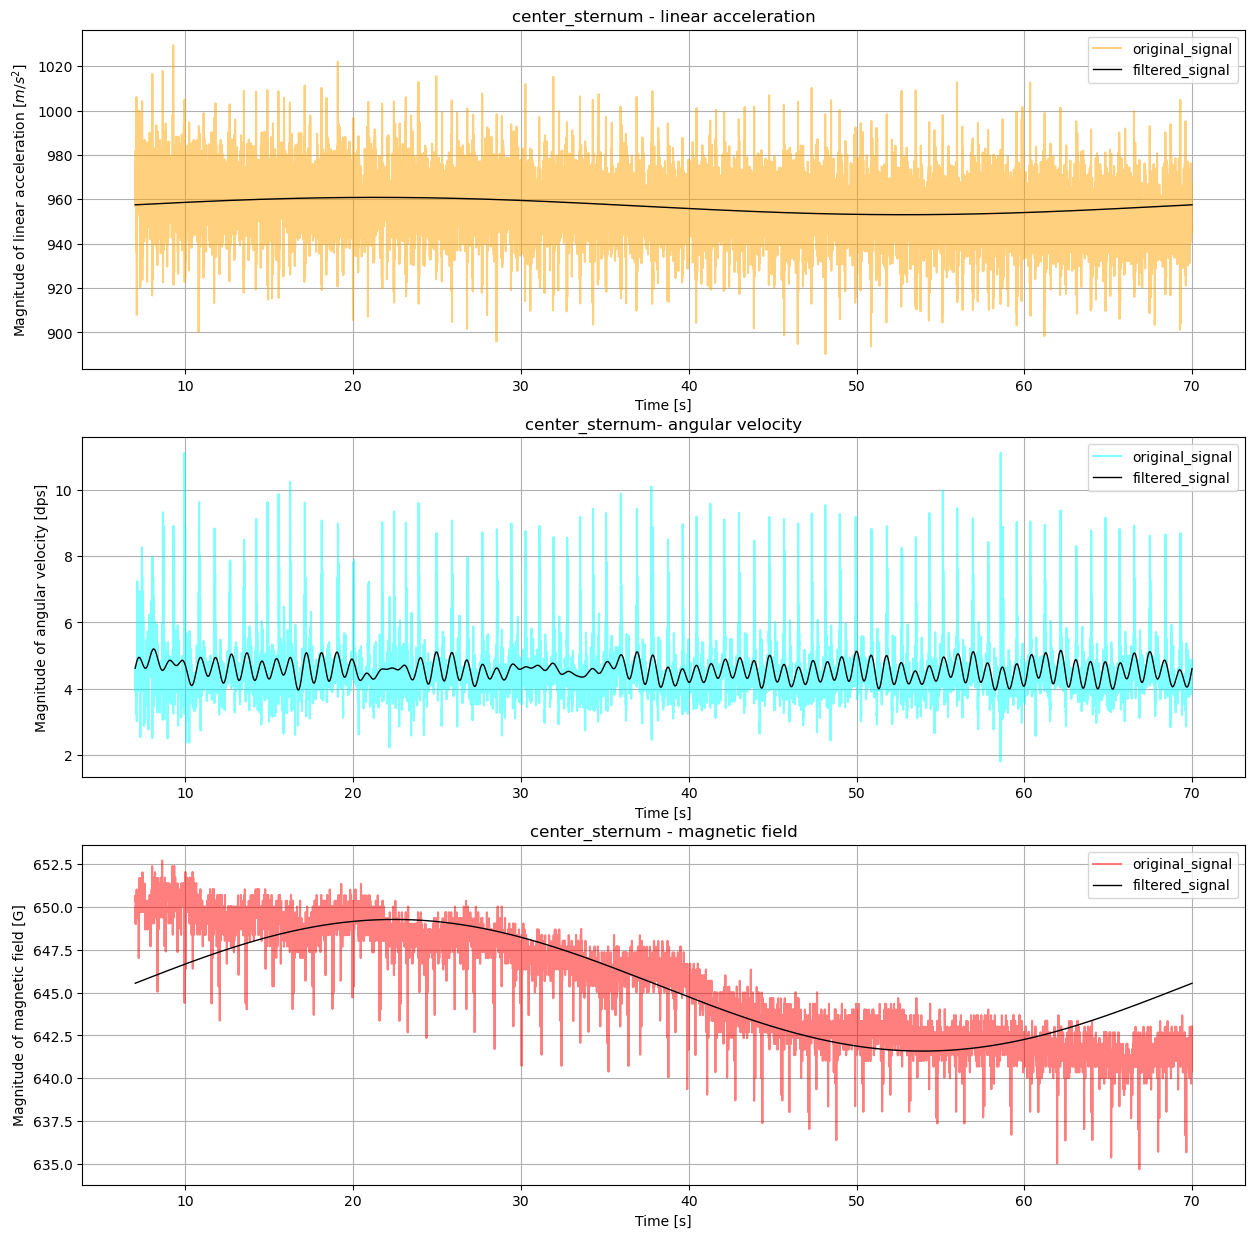

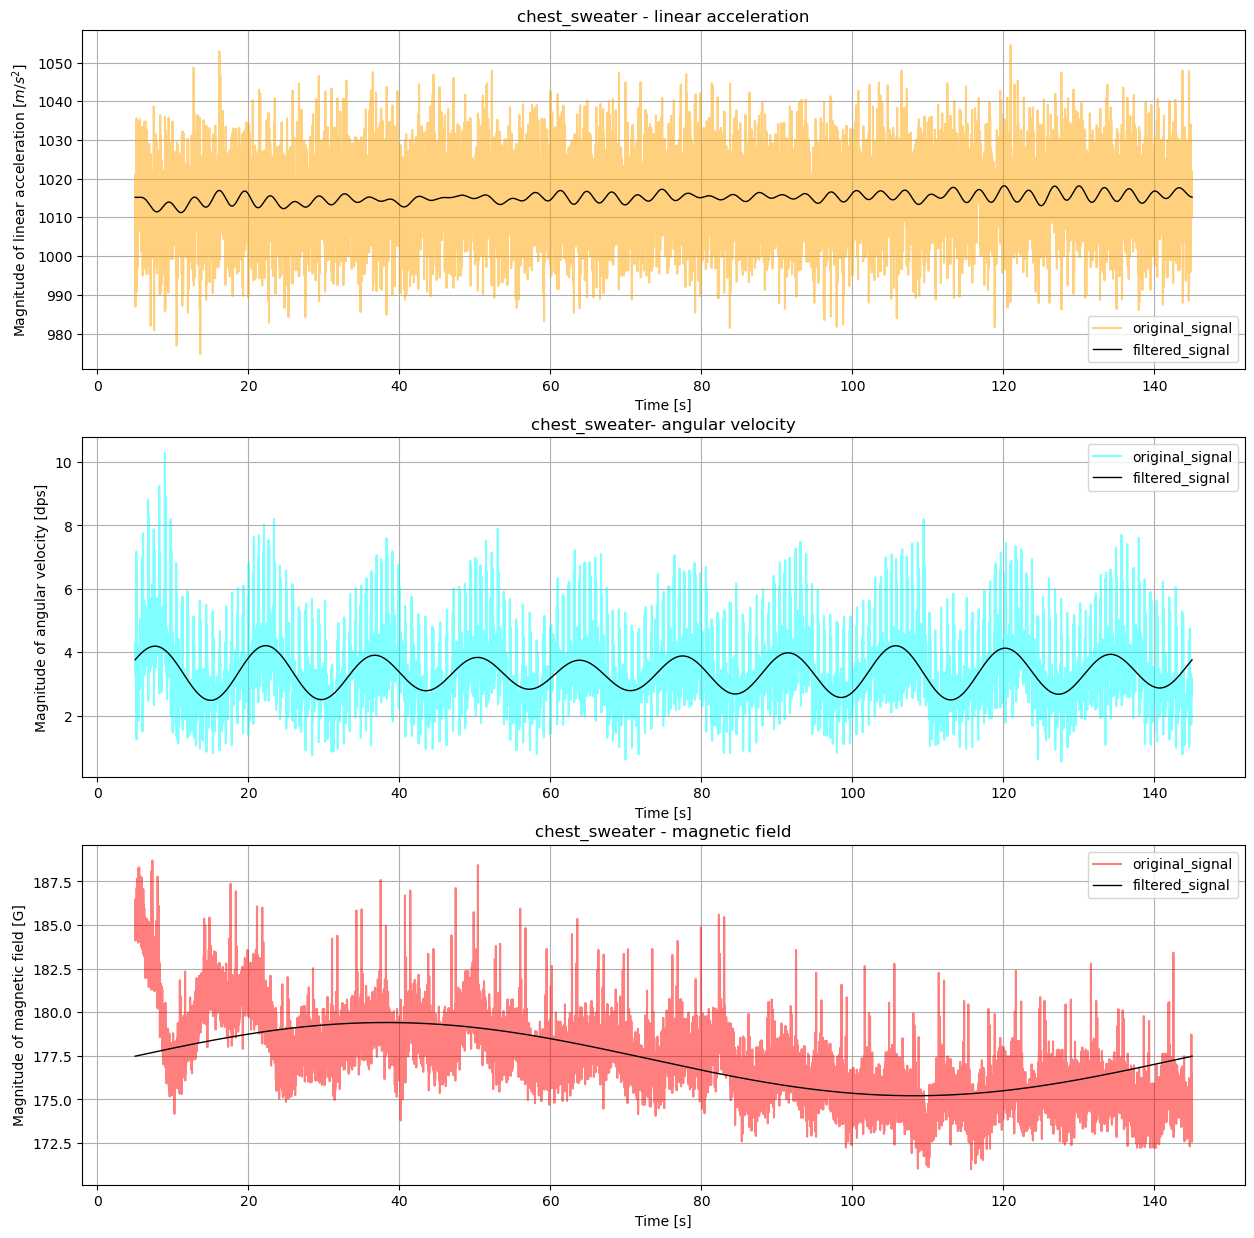

In [47]:
plot_filtered_and_original(center_sternum, filtered_signals_sternum, "center_sternum")
plot_filtered_and_original(chest_sweater, filtered_signals_chest, "chest_sweater")

Even if we haven't applied the zoom on a specific time range to better observe what happens, we can see from these plots that the filter is too much selective and we loose too much information: this happens in particular in the magnitude of linear acceleration signal of center_sternum dataset and in the signals that represent the magnitude of magnetic field.

We try to extend the range of frequencies that aren't considered noise: we increase the threshold and now we specify different values for each signal to get the best trade off between noise removal and preserving heart rate's information. To do this, we perform a zoom on the plot.<br>

### Perform ZOOM in [30,40] seconds to  choose the thresholds

In [48]:
#CENTER_STERNUM
#Acceleration
sternum_acc_fft_filtered = filter(dft_sternum[0],freq_sternum[0], fSamp_sternum, peak_sternum[0], 8.1)
#Velocity
sternum_vel_fft_filtered = filter(dft_sternum[1],freq_sternum[1], fSamp_sternum, peak_sternum[1],3)
#Magnetic field
sternum_magn_fft_filtered = filter(dft_sternum[2],freq_sternum[2], fSamp_sternum, peak_sternum[2],3.2)

filtered_fft_sternum = [sternum_acc_fft_filtered,sternum_vel_fft_filtered,sternum_magn_fft_filtered]

#CHEST_SWEATER
#Acceleration
chest_acc_fft_filtered = filter(dft_chest[0], freq_chest[0], fSamp_chest, peak_chest[0],6.5)
#Velocity
chest_vel_fft_filtered = filter(dft_chest[1], freq_chest[1], fSamp_chest, peak_chest[1],3.3)
#Magnetic field
chest_magn_fft_filtered = filter(dft_chest[2], freq_chest[2], fSamp_chest, peak_chest[2],5.9)

filtered_fft_chest = [chest_acc_fft_filtered, chest_vel_fft_filtered, chest_magn_fft_filtered]

# calculate the Inverse Fast Fourier Transform to get the filtered signals in time domain
filtered_signals_sternum = []
for i in range(len(filtered_fft_sternum)):
    filtered_signals_sternum.append(fftpack.ifft(np.fft.ifftshift(filtered_fft_sternum[i])))
filtered_signals_chest = []
for i in range(len(filtered_fft_chest)):
    filtered_signals_chest.append(fftpack.ifft(np.fft.ifftshift(filtered_fft_chest[i])))

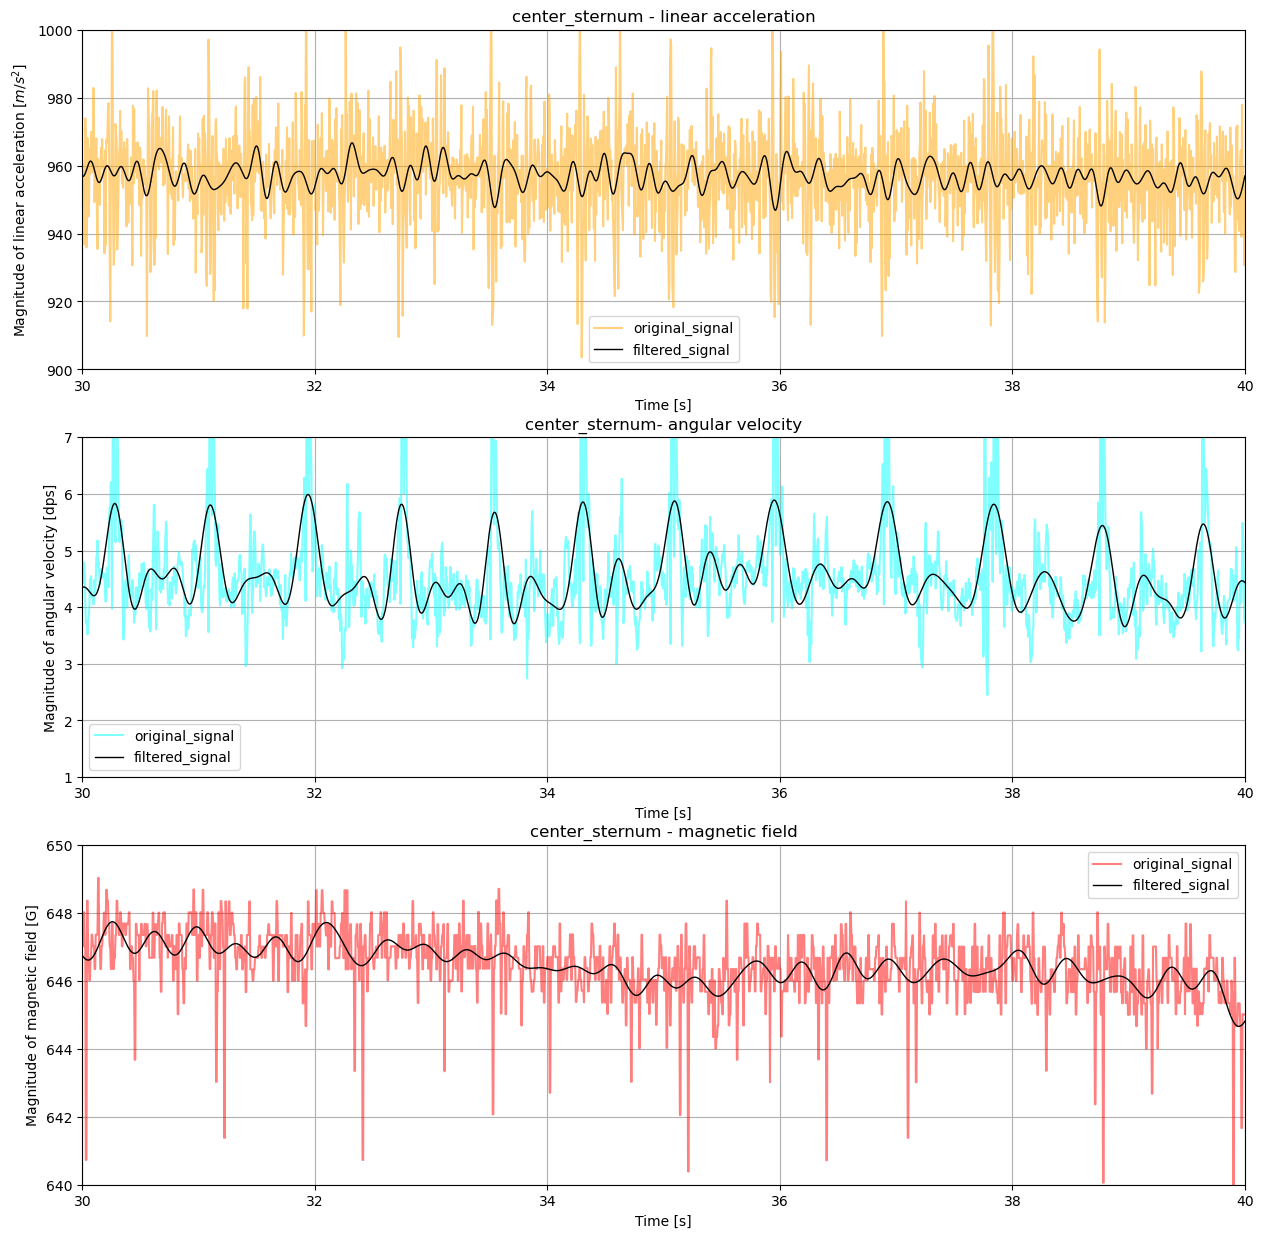

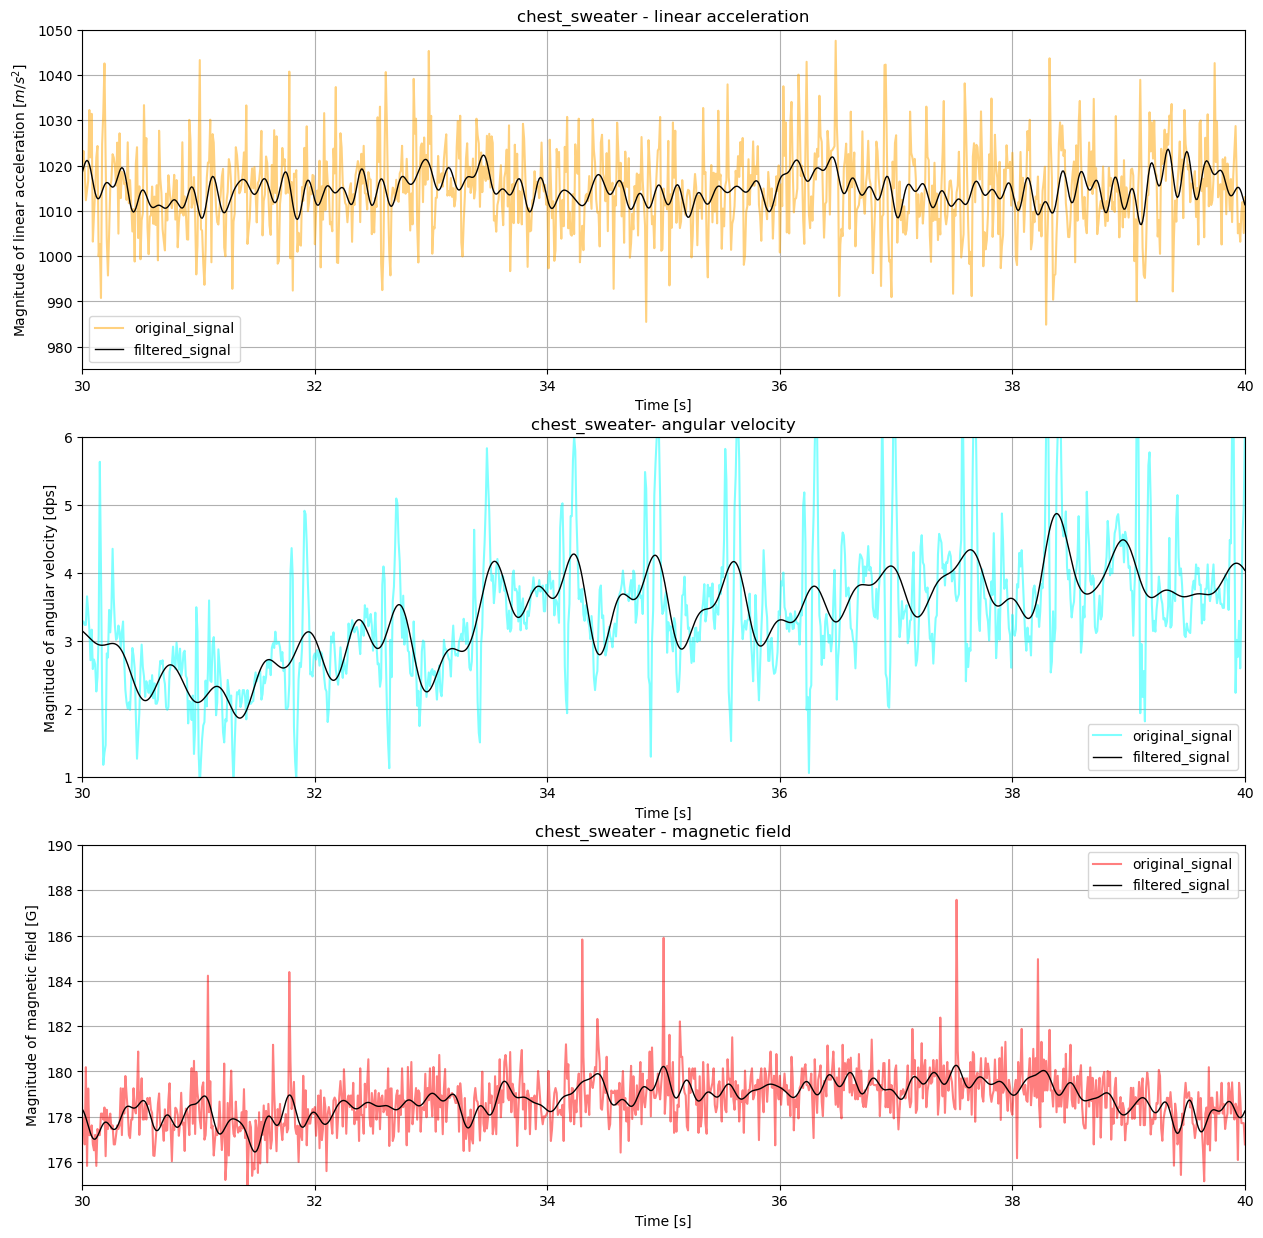

In [49]:
plot_filtered_and_original_zoom(center_sternum, filtered_signals_sternum, "center_sternum", [(900,1000),(1,7),(640,650)])
plot_filtered_and_original_zoom(chest_sweater, filtered_signals_chest, "chest_sweater",[(975,1050),(1,6),(175,190)])

We have to take into account the tradeoff already explained before. <br>
It's interesting to highlight that it's hard to remove noise in particular from the acceleration-magnitude signal (center_sternum), since if we reduce the threshold we loose a lot of information and on the other hand if we increse it too much, we retain a lot of noise components. As proof of this, see the following plot: when we increase the threshold,  respiratory and cardiac components overlap in the frequency domain and cause the overlapping of the signals in the time domain.

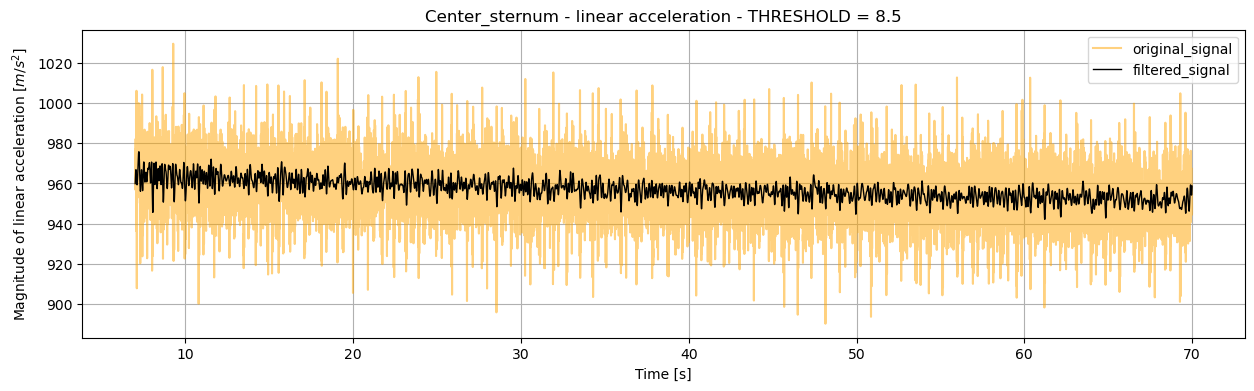

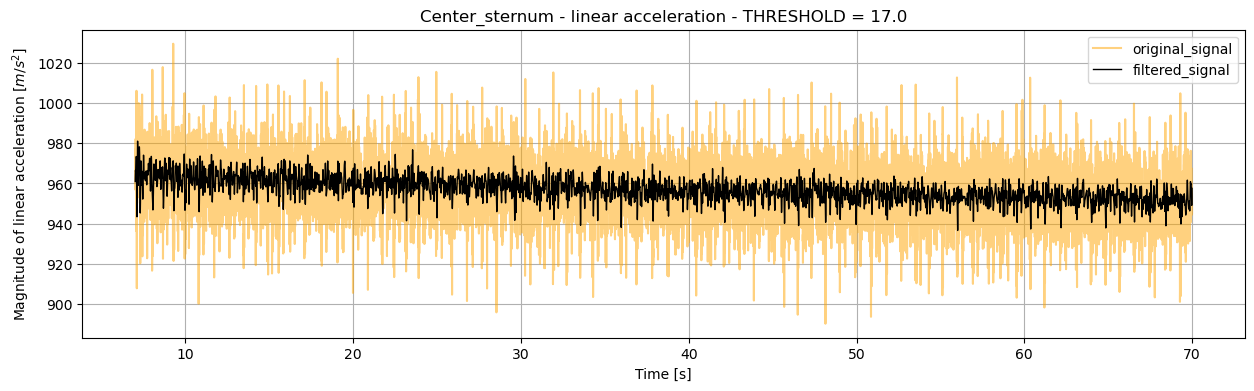

In [50]:
#before th = 8.1   
acc_thresholds = [8.5, 17] #<- for example
for th in acc_thresholds:
    acc_fft_filtered = filter(dft_sternum[0],freq_sternum[0], fSamp_sternum, peak_sternum[0], th) 
    fig, axes = plt.subplots(figsize=(15, 4))
    filtered_acc = fftpack.ifft(np.fft.ifftshift(acc_fft_filtered))
    # Plot linear acceleration
    axes.plot(center_sternum["Time"], center_sternum["Acc"], color="orange", linestyle="-", alpha=0.5, label="original_signal")
    axes.plot(center_sternum["Time"], filtered_acc, color="black", linestyle="-", linewidth=1, alpha=1, label = "filtered_signal")
    axes.set_xlabel("Time [s]")
    axes.set_ylabel("Magnitude of linear acceleration [$m/s^2$]")
    axes.grid(True)
    axes.set_title("Center_sternum - linear acceleration - THRESHOLD = %.1f" % th)
    axes.legend()


## 2nd method: Savitzky–Golay  filter 

$$Y_j = \sum\limits_{i=\frac{(1-m)}{2}}^{\frac{(m-1)}{2}}C_iy_{j+1}, \text{with} \ \frac{m+1}{2}<=j<=n-\frac{m-1}{2}$$

A Savitzky–Golay filter can be applied to a set of digital data points. It can beused to reduce high frequency noise in a signal due to its smoothing properties and reduce low frequency signal (e.g., due to offsets and slopes) using differentiation.
It's based on the convolution: for a given signal measured at _N_ points and a filter of width _w_, Savgol computes a polynomial fit of order _o_ in each filter window as the filter is moved across the signal, using least-squares. <br>

### SG filter application

### Perform ZOOM in [30,40] seconds to  choose the thresholds

We apply the filter directly to the original signal, instead of performing the FFT and then its inverse. We can choose the size of the window and the order of the polynomial fit.

In [51]:
#CENTER_STERNUM
#Acceleration
sternum_acc_filteredSG = signal.savgol_filter(center_sternum["Acc"], 125, 6)
#Velocity
sternum_vel_filteredSG = signal.savgol_filter(center_sternum["Gyro"], 115, 6)
#Magnetic field
sternum_magn_filteredSG = signal.savgol_filter(center_sternum["Magn"], 139, 6)

filtered_signals_sternumSG = [sternum_acc_filteredSG, sternum_vel_filteredSG, sternum_magn_filteredSG]

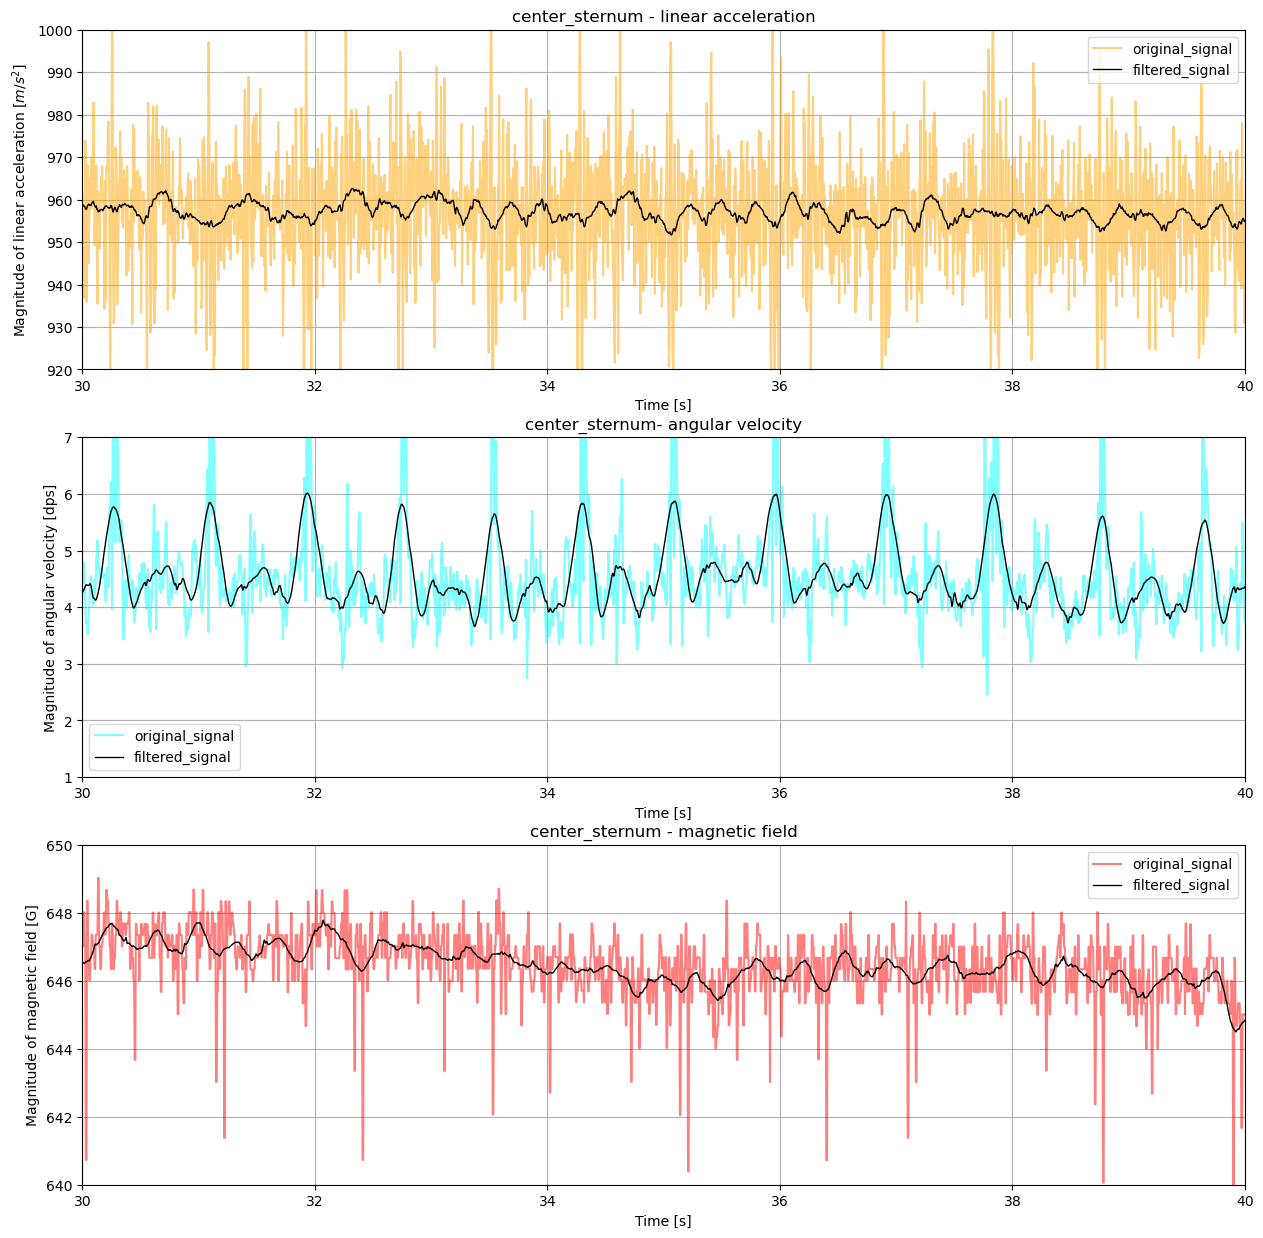

In [52]:
plot_filtered_and_original_zoom(center_sternum, filtered_signals_sternumSG, "center_sternum", [(920,1000),(1,7),(640,650)])

If we decrease the window size, we keep also noise components. If it becomes too large, we loose info.<br>
As regards the order of polynomial, if it's low it keeps only few peaks in the signal.

In [53]:
#CHEST_SWEATER
#Acceleration
chest_acc_filteredSG = signal.savgol_filter(chest_sweater["Acc"],75,6)
#Velocity
chest_vel_filteredSG =  signal.savgol_filter(chest_sweater["Gyro"],129,6)
#Magnetic field
chest_magn_filteredSG =  signal.savgol_filter(chest_sweater["Magn"],69,6)

filtered_signals_chestSG = [chest_acc_filteredSG, chest_vel_filteredSG, chest_magn_filteredSG]

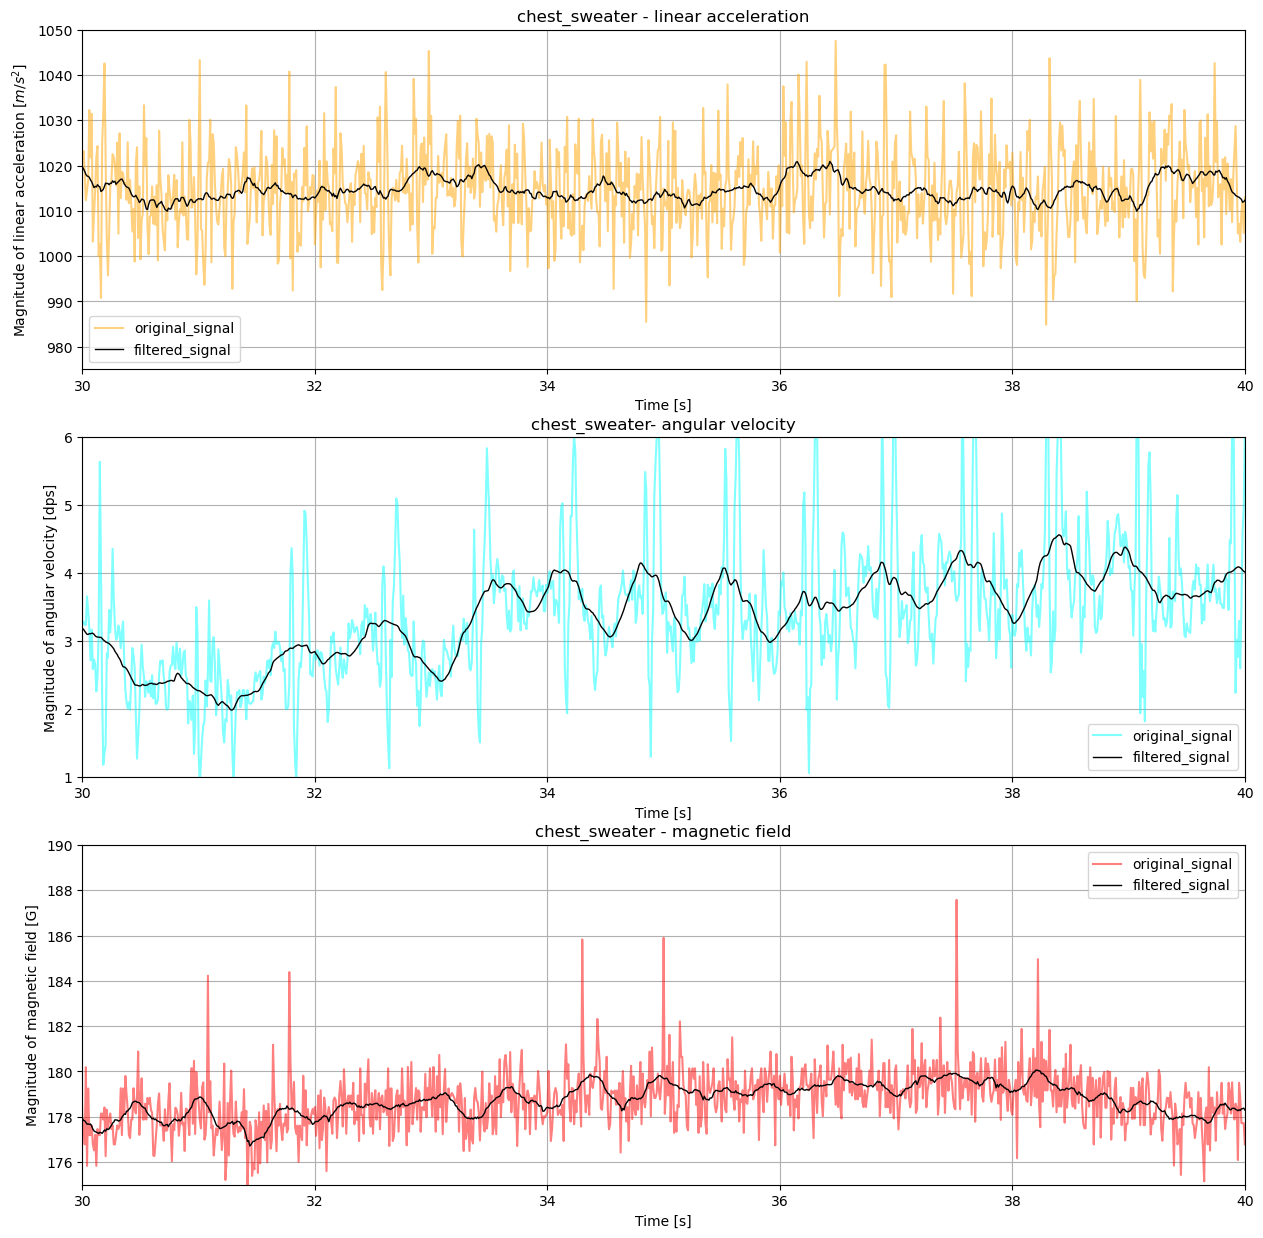

In [54]:
plot_filtered_and_original_zoom(chest_sweater, filtered_signals_chestSG, "chest_sweater",[(975,1050),(1,6),(175,190)])

### Observation: 
As a possible third filter, we could apply the moving average filter directly to the original signal.<br>
For example, if we want to filter the acceleration, the function we have to use is: _signal.medfilt(center_sternum["Acc"], w)_ where _w_ is the size of the window.<br>
The result will be similar to that of Savitzky–Golay, since the moving average is a trival example of it (where all the coefficient values are identical, with the value 1/m)

# Metrics by Elisa Borella

For consultation purposes: https://www.researchgate.net/publication/328012904_Nonintrusive_heart_rate_measurement_using_ballistocardiogram_signals_a_comparative_study

### Heart Beat Per Minute (BPM): extrapolate BPM, make an histogram of the results.

BPM for Acceleration from Sternum: 81.60 ± 19.72
BPM for Acceleration from Chest: 80.85 ± 17.22
BPM for Velocity from Sternum: 72.06 ± 11.65
BPM for Velocity from Chest: 55.83 ± 23.66
BPM for Magnetic Field from Sternum: 69.76 ± 17.31
BPM for Magnetic Field from Chest: 86.54 ± 17.87


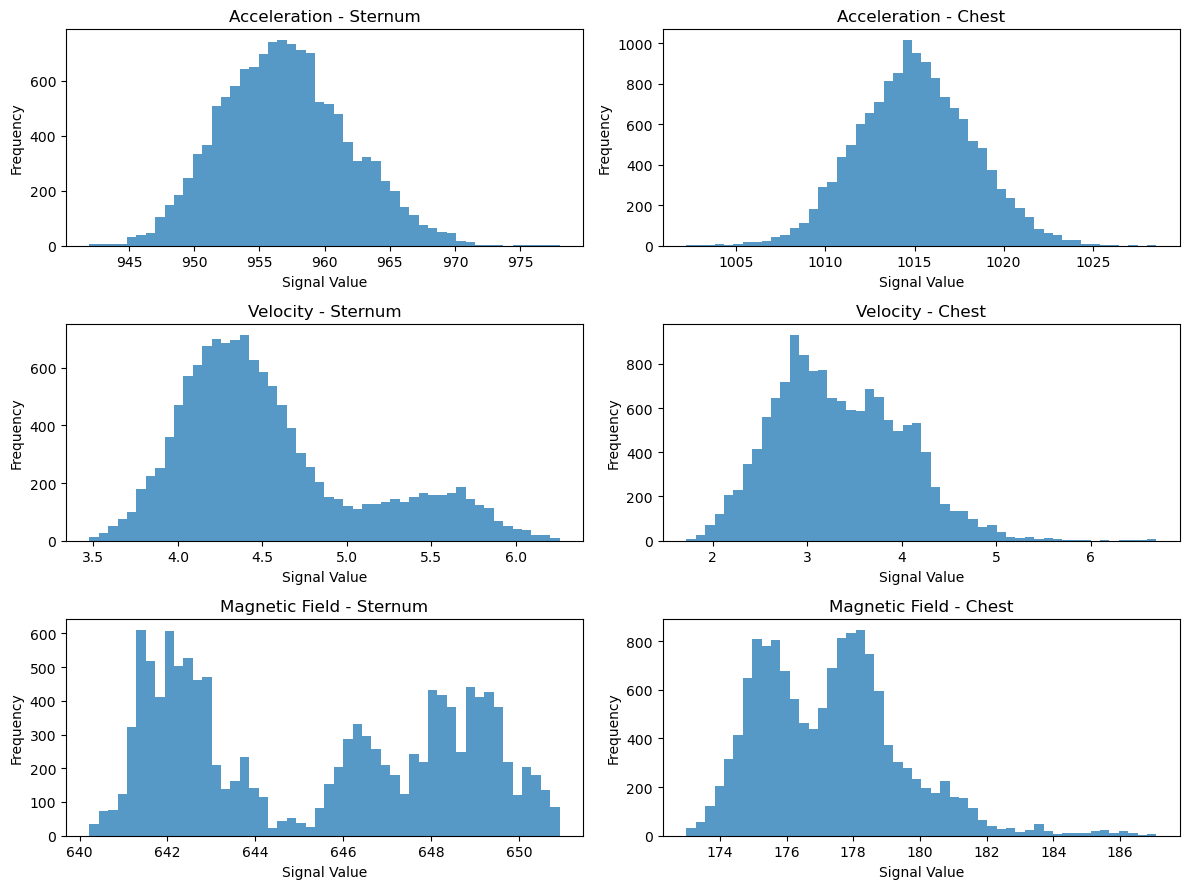

In [55]:
magnitude_signals_sternum = [np.abs(signal) for signal in filtered_signals_sternum]
magnitude_signals_chest = [np.abs(signal) for signal in filtered_signals_chest]


# Function to calculate BPM
def calculate_bpm_and_std(signal, fs):
    # Ensure signal is a 1-D array
    signal = np.asarray(signal)
    if signal.ndim != 1:
        raise ValueError("Signal must be a 1-D array")
    
    # Detect peaks
    peaks, _ = find_peaks(signal, height=np.max(signal)*0.5, distance=fs*0.5)
    if len(peaks) > 1:
        peak_intervals = np.diff(peaks) / fs
        bpm = 60 / np.mean(peak_intervals)
        bpm_std = np.std(60 / peak_intervals)  # Calculate std of BPMs
        return bpm, bpm_std
    return None, None

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
fs_sternum = 200  # Sample frequency for sternum signals
fs_chest = 100    # Sample frequency for chest signals
signal_types = ['Acceleration', 'Velocity', 'Magnetic Field']
sources = [('Sternum', magnitude_signals_sternum, fs_sternum), ('Chest', magnitude_signals_chest, fs_chest)]


# Update the plotting and BPM calculation loop
for i, signal_type in enumerate(signal_types):
    for j, (source_name, signals, fs) in enumerate(sources):
        signal = signals[i]  # Selecting the i-th signal type from current source
        
        bpm, bpm_std = calculate_bpm_and_std(signal, fs)
        if bpm is not None:
            print(f"BPM for {signal_type} from {source_name}: {bpm:.2f} ± {bpm_std:.2f}")
        else:
            print(f"BPM for {signal_type} from {source_name}: None")

        # Plot histogram of signal values
        axes[i, j].hist(signal, bins=50, alpha=0.75)
        axes[i, j].set_title(f'{signal_type} - {source_name}')
        axes[i, j].set_xlabel('Signal Value')
        axes[i, j].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### Comments on the proposed approach
Inputs of the 'calculate_bpm(signal, fs)' function:
1. signal: This is a one-dimensional numpy array representing the time-domain signal from which the heart rate (BPM) is to be calculated. The signal could be derived from various sources, such as an accelerometer, a velocity sensor, or a magnetic field sensor, and it typically represents some aspect of cardiac activity or its effects on the body.
2. 
fs: The sampling rate (in Hz) at which the signal was recorded. The sampling rate is crucial because it defines the time interval between consecutive samples in the signal. Knowing this interval allows for accurate time measurements between physiological events detected in the signal, such as heartbeats

Process:

Peak Detection: The function uses the find_peaks method from scipy.signal to identify peaks in the signal. These peaks are presumed to correspond to individual heartbeats. The height parameter for peak detection is set to 50% of the maximum signal value to avoid detecting minor fluctuations as heartbeats. The distance parameter is set to half the sampling rate, ensuring that two consecutive peaks (heartbeats) are separated by at least half a second, which is a reasonable assumption for heart rates within the physiological range.


Time Between Peaks: Once peaks are detected, the function calculates the time intervals between consecutive peaks. This is done by subtracting the indices of these peaks and dividing by the sampling rate (fs), converting index differences into seconds.



Calculating BPM: The average time interval between peaks is then used to calculate the BPM. This is achieved by taking the reciprocal of the average time interval (to get beats per second) and then multiplying by 60 to convert to beats per minute.

### Does it follow a particular distribution?

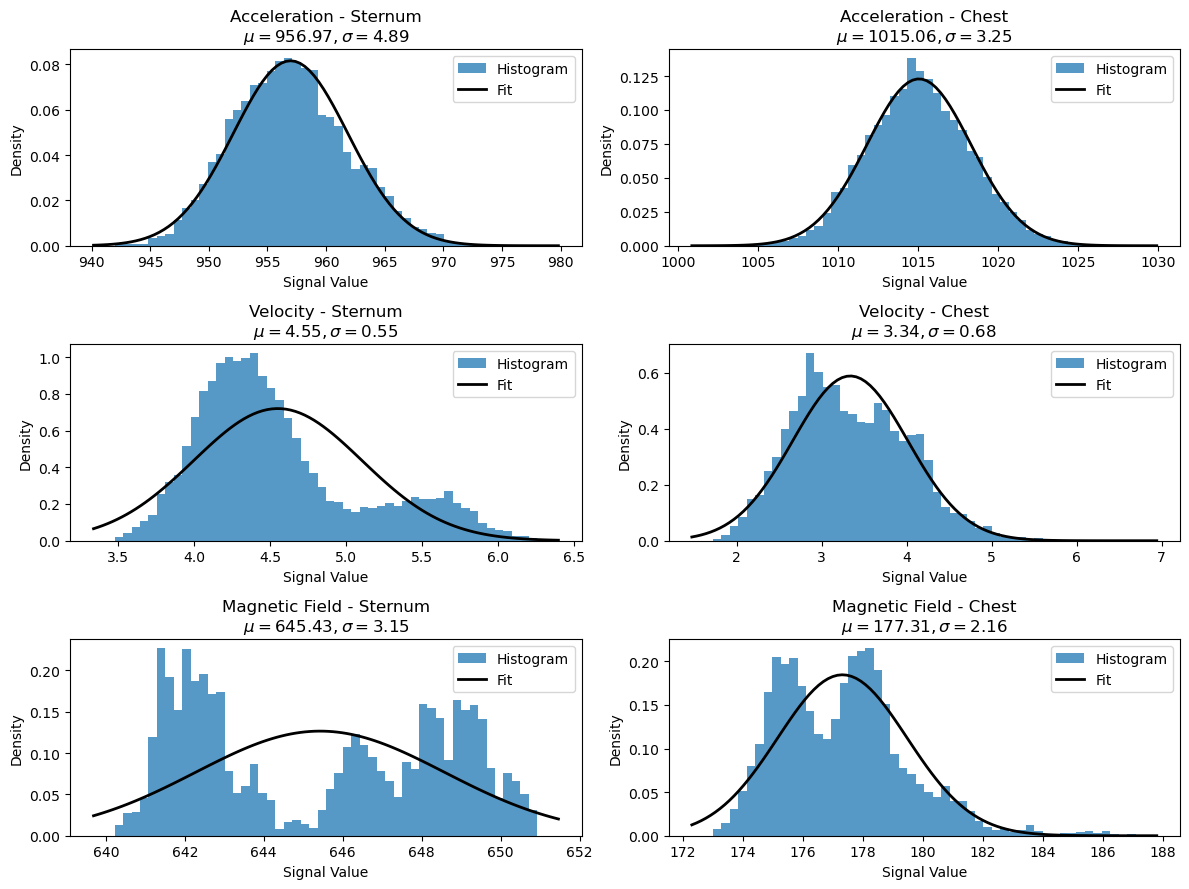

In [56]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 9))
signal_types = ['Acceleration', 'Velocity', 'Magnetic Field']
sources = [('Sternum', magnitude_signals_sternum, fs_sternum), ('Chest', magnitude_signals_chest, fs_chest)]

for i, signal_type in enumerate(signal_types):
    for j, (source_name, signals, fs) in enumerate(sources):
        signal = signals[i]  # Selecting the i-th signal type from the current source

        # Plot histogram of signal values
        n, bins, patches = axes[i, j].hist(signal, bins=50, alpha=0.75, density=True, label='Histogram')
        
        # Fit a normal distribution to the data
        mu, std = norm.fit(signal)
        
        # Plot the PDF.
        xmin, xmax = axes[i, j].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        p = norm.pdf(x, mu, std)
        
        axes[i, j].plot(x, p, 'k', linewidth=2, label='Fit')
        title = f'{signal_type} - {source_name}\n$\mu={mu:.2f}, \sigma={std:.2f}$'
        axes[i, j].set_title(title)
        axes[i, j].set_xlabel('Signal Value')
        axes[i, j].set_ylabel('Density')
        axes[i, j].legend()

plt.tight_layout()
plt.show()

### Heart Rate Variability (HRV): extrapolate HRV, explain why this parameter is important, and plot the results.

Acceleration from Sternum - SDNN: 173.12 ms, RMSSD: 238.27 ms, pNN50: 82.14%


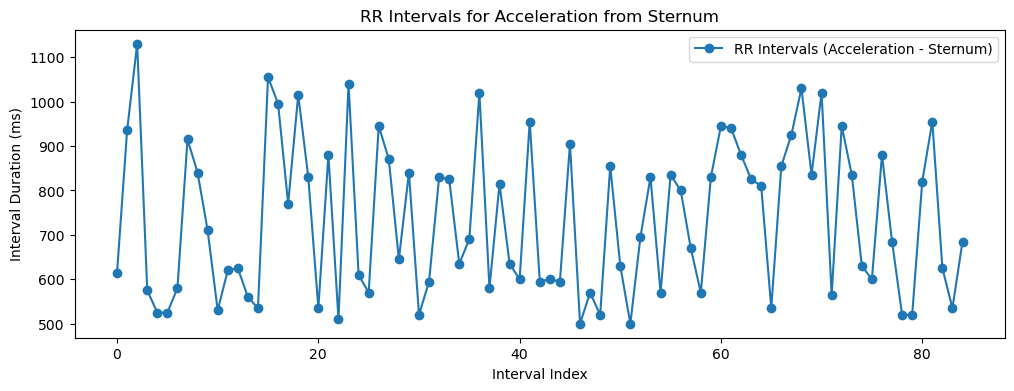

Velocity from Sternum - SDNN: 106.01 ms, RMSSD: 90.28 ms, pNN50: 33.78%


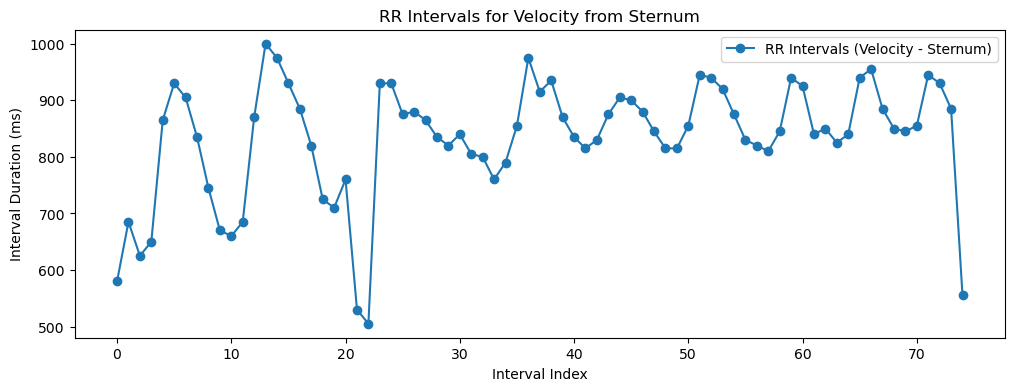

Magnetic Field from Sternum - SDNN: 217.69 ms, RMSSD: 306.72 ms, pNN50: 84.51%


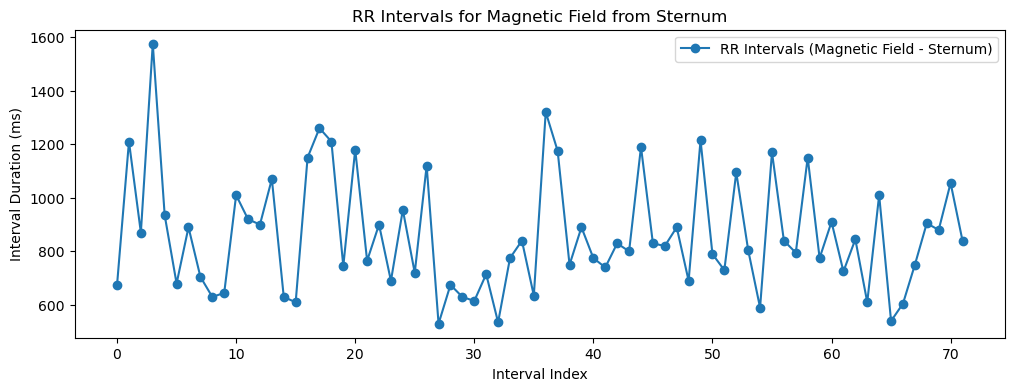

Acceleration from Chest - SDNN: 164.13 ms, RMSSD: 235.36 ms, pNN50: 80.21%


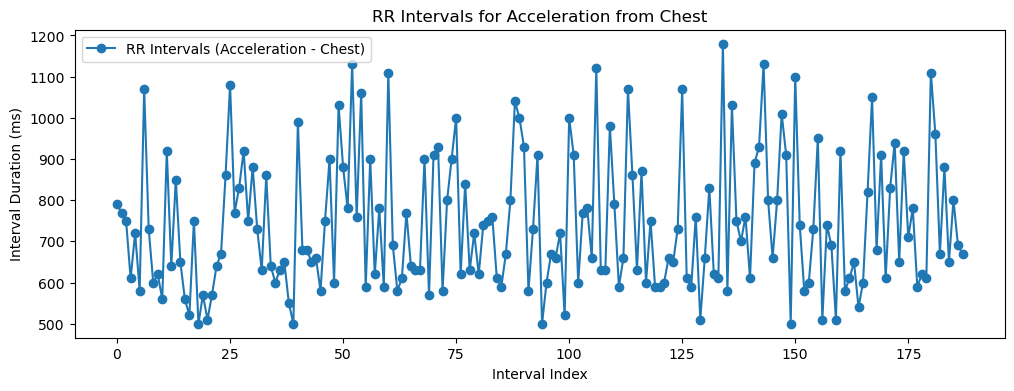

Velocity from Chest - SDNN: 1043.58 ms, RMSSD: 1409.07 ms, pNN50: 60.16%


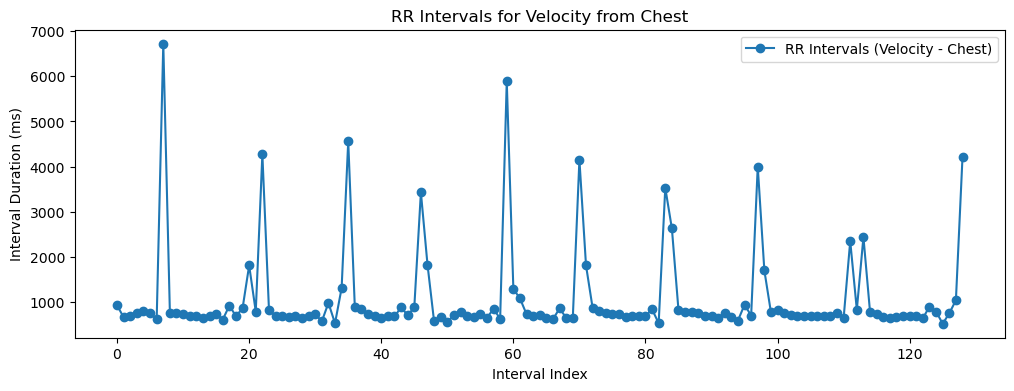

Magnetic Field from Chest - SDNN: 155.92 ms, RMSSD: 225.11 ms, pNN50: 72.50%


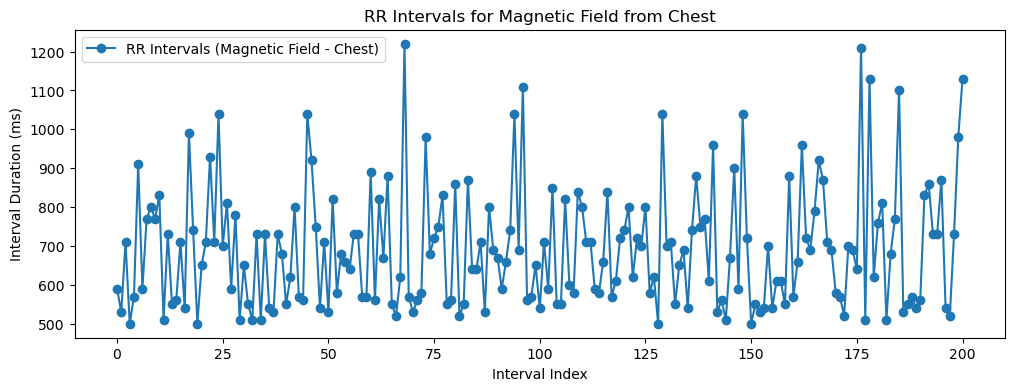

In [57]:
# Function to detect peaks and calculate RR intervals
def calculate_rr_intervals(signal, fs):
    peaks, _ = find_peaks(signal, height=np.max(signal)*0.5, distance=fs*0.5)
    if len(peaks) > 1:
        rr_intervals = np.diff(peaks) / fs * 1000  # Convert to milliseconds
        return rr_intervals, peaks
    return None, None

def calculate_hrv(rr_intervals):
    """
    Calculate HRV metrics: SDNN, RMSSD, and pNN50 from RR intervals.

    Parameters:
    - rr_intervals: list or numpy array of RR intervals in milliseconds

    Returns:
    - sdnn: Standard Deviation of NN intervals
    - rmssd: Root Mean Square of Successive Differences
    - pnn50: Percentage of differences between adjacent NN intervals that are greater than 50 ms
    """
    # Ensure rr_intervals is a numpy array
    rr_intervals = np.array(rr_intervals)

    # Calculate SDNN
    sdnn = np.std(rr_intervals, ddof=1)  # ddof=1 provides an unbiased estimator

    # Calculate RMSSD
    differences = np.diff(rr_intervals)
    squared_differences = differences ** 2
    rmssd = np.sqrt(np.mean(squared_differences))

    # Calculate pNN50
    nn50 = np.sum(np.abs(differences) > 50)
    pnn50 = (nn50 / len(differences)) * 100

    return sdnn, rmssd, pnn50


# HRV analysis for each signal
for source_name, signals, fs in [('Sternum', magnitude_signals_sternum, fs_sternum), ('Chest', magnitude_signals_chest, fs_chest)]:
    for i, signal_type in enumerate(signal_types):
        signal = signals[i]  # Select the signal based on type
        
        rr_intervals, peaks = calculate_rr_intervals(signal, fs)
        if rr_intervals is not None:
            sdnn, rmssd, pnn50 = calculate_hrv(rr_intervals)
            print(f"{signal_type} from {source_name} - SDNN: {sdnn:.2f} ms, RMSSD: {rmssd:.2f} ms, pNN50: {pnn50:.2f}%")
            
            # Plotting RR intervals
            plt.figure(figsize=(12, 4))
            plt.plot(np.arange(len(rr_intervals)), rr_intervals, '-o', label=f'RR Intervals ({signal_type} - {source_name})')
            plt.xlabel('Interval Index')
            plt.ylabel('Interval Duration (ms)')
            plt.title(f'RR Intervals for {signal_type} from {source_name}')
            plt.legend()
            plt.show()
        else:
            print(f"Not enough data for HRV analysis in {signal_type} from {source_name}.")


### Comments on the proposed approach

RR Intervals Calculation:
'calculate_rr_intervals' function: This inner function is tasked with identifying R-peaks within each signal using the find_peaks method from scipy.signal. R-peaks correspond to the heartbeats detected in the signal.
After detecting the peaks, it calculates the RR intervals, which are the time differences between consecutive R-peaks, measured in milliseconds. These intervals are crucial for HRV analysis as they reflect the time variations between heartbeats.

HRV Metrics calculation:  
The function then proceeds to calculate several HRV metrics from the RR intervals including:  
SDNN: The standard deviation of the RR intervals, reflecting overall heart rate viability. A higher SDNN value indicates greater variability, suggesting a healthy balance between the sympathetic and parasympathetic branches of the autonomic nervous system (ANS). Reduced SDNN is associated with increased cardiovascular risk and decreased autonomic function. Higher SDNN values are generally considered favorable. A typical SDNN value for healthy adults can range from about 32 to 93 milliseconds.

RMSSD: The root mean square of successive differences between RR intervals, indicating short-term variations. Higher RMSSD values are often associated with better recovery, lower stress levels, and overall improved autonomic function. For healthy adults, RMSSD values often fall in the range of 19 to 75 milliseconds

pNN50: The percentage of successive RR intervals that differ by more than 50 ms. A higher pNN50 is generally considered indicative of better vagal (parasympathetic) tone and is associated with reduced cardiovascular risk. It is particularly relevant in assessing short-term HRV. In healthy individuals, a pNN50 greater than 3% is considered normal.
These metrics provide insights into the autonomic nervous system's control over the heart rate, indicating stress, fitness levels, and potential health issues.

Sources: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/
        https://www.scirp.org/html/4-8201618_21183.htm

HRV is also influenced by lifestyle factors such as stress levels, physical fitness, and the presence of chronic health conditions. For example, athletes and physically active individuals often have higher HRV values, reflecting a robust autonomic nervous system and cardiovascular system.
HRV measures the variation in time intervals between heartbeats, which is influenced by the ANS's sympathetic and parasympathetic branches. The balance between these branches affects heart rate variability, with higher variability often indicating a healthier balance and better autonomic control over heart function.
Research has shown that reduced HRV can be an early marker for various cardiovascular diseases and conditions such as heart failure, arrhythmias, and myocardial infarction. Lower HRV is also associated with other non-cardiovascular conditions, including stress, anxiety, and depression, making it a valuable tool for early detection and monitoring of a wide range of health issues.
With the advent of wearable technology and mobile health devices, measuring HRV has become more accessible, providing an easy and non-invasive way to monitor one's health status over time. This accessibility supports regular monitoring and early intervention strategies.

# Optional algorithm by Elisa Borella & Ledia Pampagnin

### Elaborate a simple algorithm to extrapolate the heart rate even when the filter fails (e.g. look for a particular threshold...).

Acceleration from Sternum: Estimated HR = 69.53 BPM (Dominant Freq = 1.16 Hz)
Gyroscope from Sternum: Estimated HR = 69.53 BPM (Dominant Freq = 1.16 Hz)
Magnetic Field from Sternum: Estimated HR = 150.49 BPM (Dominant Freq = 2.51 Hz)
Acceleration from Chest: Estimated HR = 41.57 BPM (Dominant Freq = 0.69 Hz)
Gyroscope from Chest: Estimated HR = 81.86 BPM (Dominant Freq = 1.36 Hz)
Magnetic Field from Chest: Estimated HR = 88.72 BPM (Dominant Freq = 1.48 Hz)


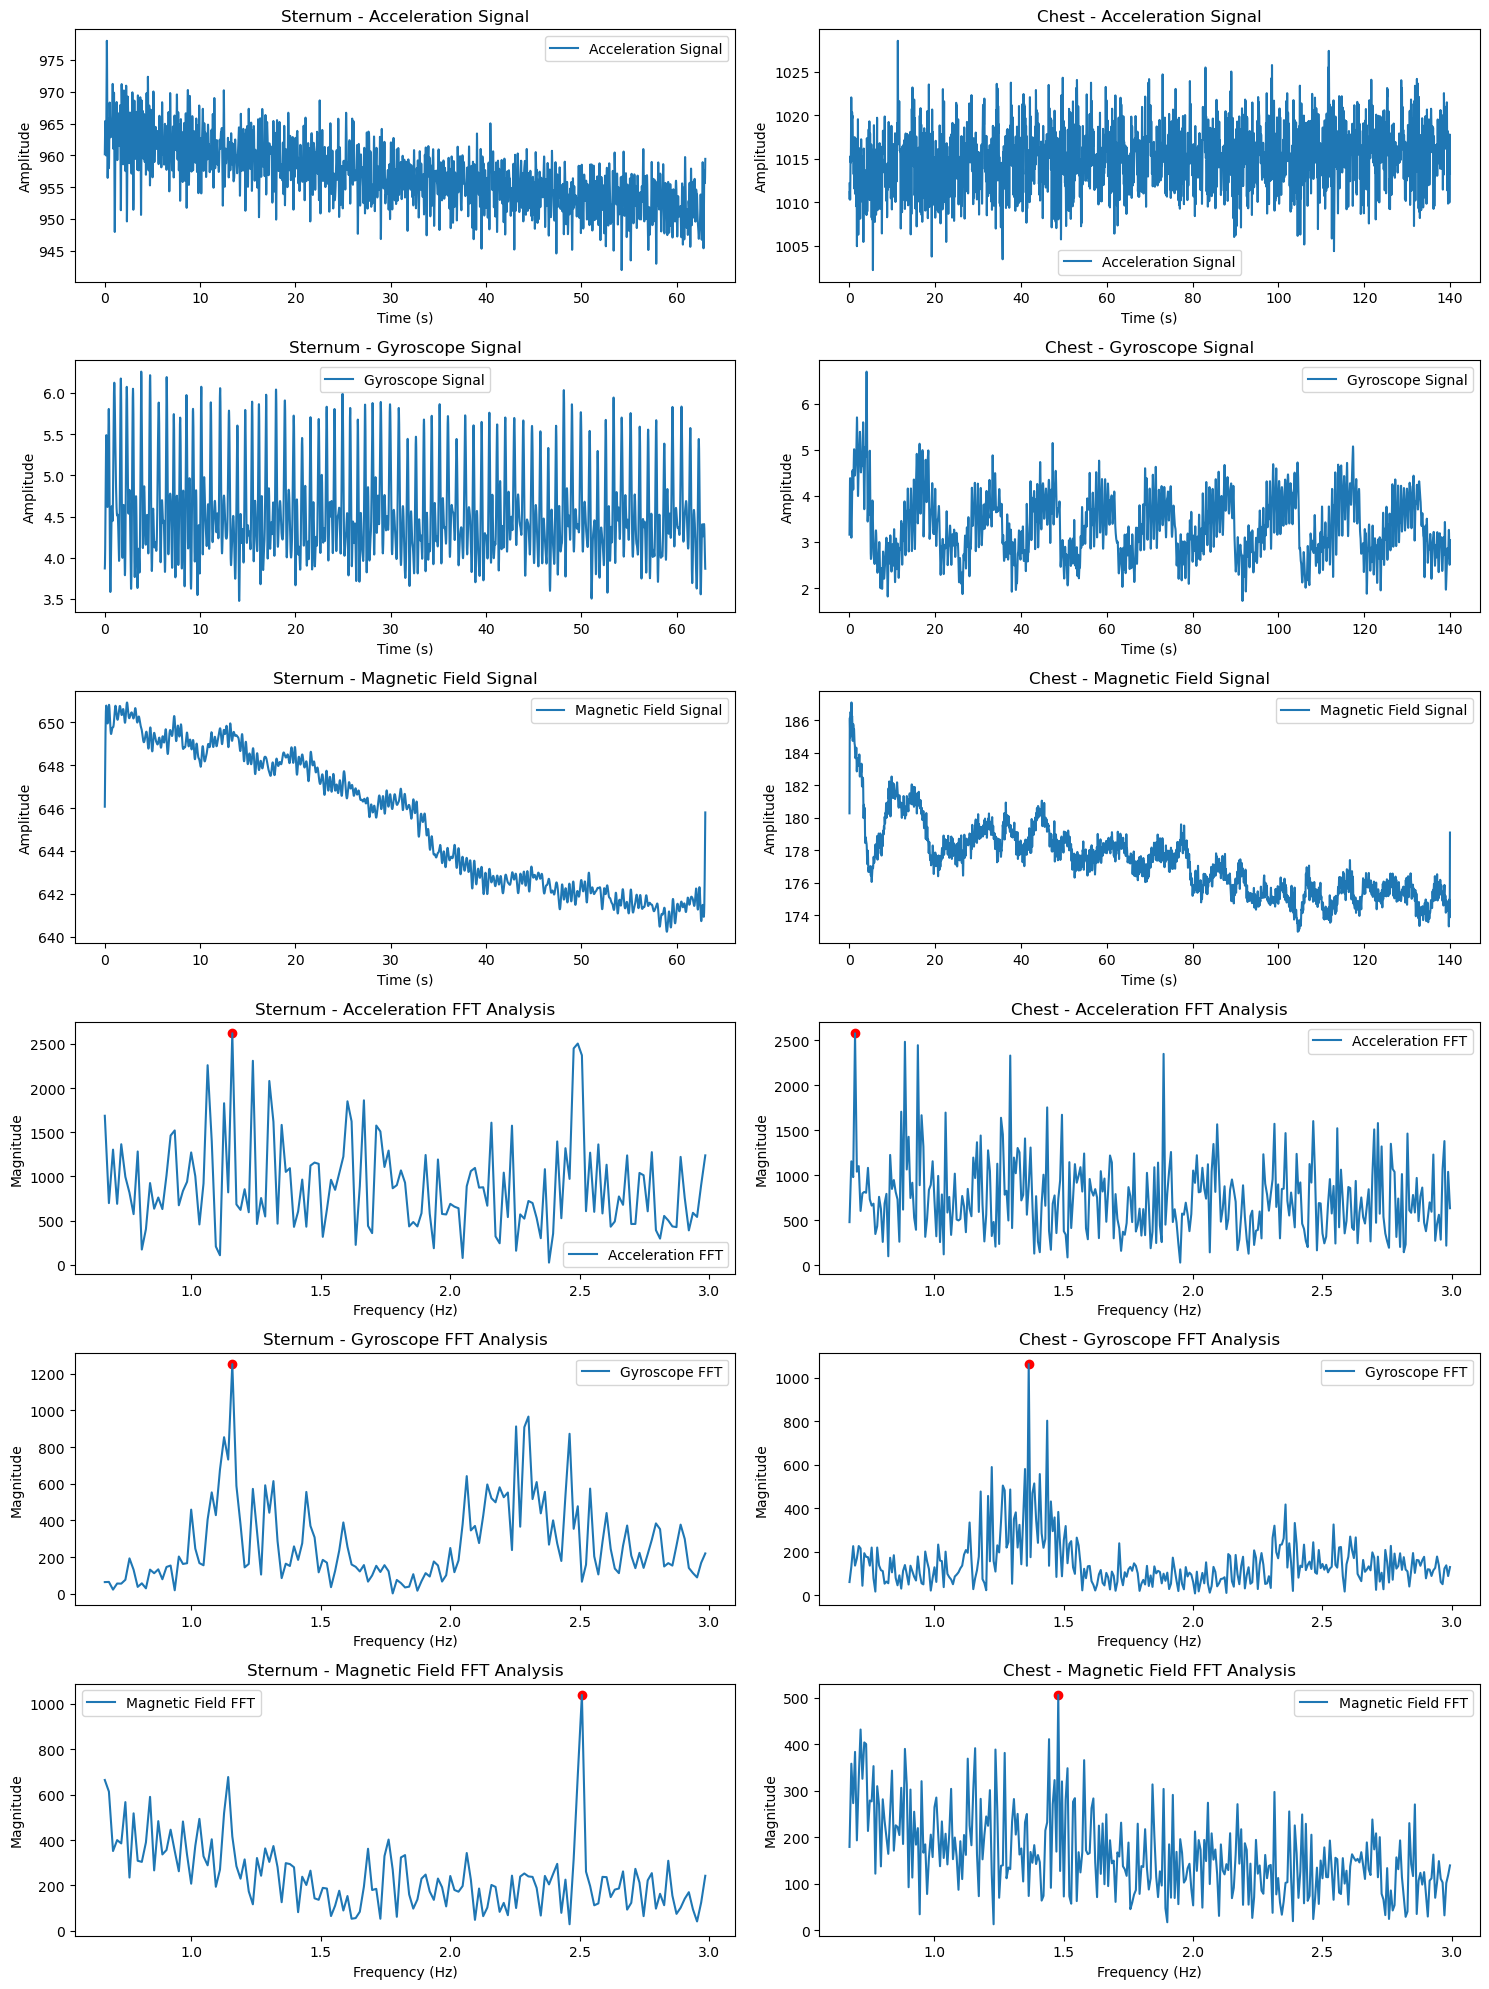

In [58]:
def estimate_heart_rate(signal, fs, expected_hr_min=40, expected_hr_max=180):
    """
    Estimate the heart rate from a given signal.
    
    Parameters:
    - signal: The signal from which to estimate the heart rate.
    - fs: The sampling frequency of the signal.
    - expected_hr_min: The minimum expected heart rate in BPM.
    - expected_hr_max: The maximum expected heart rate in BPM.
    
    Returns:
    - The estimated heart rate in BPM, or None if estimation failed.
    - The dominant frequency in Hz, or None if estimation failed.
    """
    # Convert heart rate range to frequency range (Hz)
    freq_min = expected_hr_min / 60
    freq_max = expected_hr_max / 60
    
    # Perform FFT
    fft_vals = np.fft.rfft(signal)
    fft_freq = np.fft.rfftfreq(len(signal), 1/fs)
    
    # Find indices where frequency is within expected heart rate range
    indices = np.where((fft_freq >= freq_min) & (fft_freq <= freq_max))[0]
    
    if len(indices) == 0:
        return None, None  # No frequency within the expected range
    
    # Find the peak within the expected range
    peak_freq_index = indices[np.argmax(np.abs(fft_vals[indices]))]
    dominant_freq = fft_freq[peak_freq_index]
    estimated_hr = dominant_freq * 60  # Convert back to BPM
    
    return estimated_hr, dominant_freq

# Plotting
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(15, 20))  # Adjusted for 6 rows to accommodate FFT plots
signal_types = ['Acceleration', 'Gyroscope', 'Magnetic Field']
sources = [('Sternum', magnitude_signals_sternum, fs_sternum), ('Chest', magnitude_signals_chest, fs_chest)]

expected_hr_min = 40  # Define these inside the plotting loop if they vary between signals
expected_hr_max = 180

for j, (source_name, signals, fs) in enumerate(sources):
    for i, signal in enumerate(signals):
        estimated_hr, dominant_freq = estimate_heart_rate(signal, fs, expected_hr_min, expected_hr_max)

        # Print the results
        if estimated_hr:
            print(f"{signal_types[i]} from {source_name}: Estimated HR = {estimated_hr:.2f} BPM (Dominant Freq = {dominant_freq:.2f} Hz)")
        else:
            print(f"{signal_types[i]} from {source_name}: HR estimation failed.")

        
        # Time-domain plot
        axes[i, j].plot(np.arange(len(signal)) / fs, signal, label=f"{signal_types[i]} Signal")
        axes[i, j].set_title(f'{source_name} - {signal_types[i]} Signal')
        axes[i, j].set_xlabel('Time (s)')
        axes[i, j].set_ylabel('Amplitude')
        axes[i, j].legend()

        # Frequency-domain plot
        fft_vals = np.fft.rfft(signal)
        fft_freq = np.fft.rfftfreq(len(signal), 1/fs)
        indices = (fft_freq >= expected_hr_min / 60) & (fft_freq <= expected_hr_max / 60)

        axes[i + 3, j].plot(fft_freq[indices], np.abs(fft_vals)[indices], label=f"{signal_types[i]} FFT")
        if estimated_hr:
            peak_freq_index = np.argmax(np.abs(fft_vals[indices]))
            axes[i + 3, j].scatter(fft_freq[indices][peak_freq_index], np.abs(fft_vals)[indices][peak_freq_index], color='red')  # Red dot for dominant frequency
        axes[i + 3, j].set_title(f'{source_name} - {signal_types[i]} FFT Analysis')
        axes[i + 3, j].set_xlabel('Frequency (Hz)')
        axes[i + 3, j].set_ylabel('Magnitude')
        axes[i + 3, j].legend()

plt.tight_layout()
plt.show()

Purpose: To estimate the heart rate from a given signal by identifying the dominant frequency within a specified range that corresponds to expected human heart rate limits (in beats per minute, BPM).

Parameters:  
signal: The input signal from which to estimate the heart rate.  
fs: The sampling frequency of the signal.  
expected_hr_min: Minimum expected heart rate in BPM.  
expected_hr_max: Maximum expected heart rate in BPM.  
Process:  
Converts the expected heart rate range from BPM to Hz (frequency range).  
Performs an FFT on the signal to transform it into the frequency domain.  
Searches for the dominant frequency within the expected heart rate range.  
Calculates the estimated heart rate by converting the dominant frequency back to BPM.  
Returns: The estimated heart rate in BPM and the dominant frequency in Hz.  

Iterates over each source ("Sternum" and "Chest"), processing each signal type (Acceleration, Gyroscope, Magnetic Field).
For each signal, it estimates the heart rate using the previously described function.
Prints the estimated heart rate and dominant frequency for each signal.
Plots the original signal in the time domain and its FFT in the frequency domain, highlighting the dominant frequency with a red dot if the heart rate estimation is successful.

In [59]:
def process_dataframe_2(df):
    frequency = df["Log Freq"].iloc[0]
    columns_to_delete = ["Log Mode", "Log Freq", "Timestamp"]
    df = df.drop(columns=columns_to_delete)
    df.insert(0, 'Time', None)
    df.insert(1, 'Norm_combined', None)
    
    # rewrite time values
    time_offset = 1 / frequency # time unit = 1 / frequency
    
    previous_value = 0
    
    for i, value in enumerate(df["Time"]):
        if i == 0:
            # first time value set to 0
            df.at[i, "Time"] = 0
        else:
            df.at[i, "Time"] = previous_value + time_offset
    
        previous_value = df.at[i, "Time"]
    
    #perform data --> we compute tha magnitudes of the vectors  
    acc_norm = np.sqrt(df["AccX"]**2 + df["AccY"]**2 + df["AccZ"]**2)
    acc_norm_rounded = round(acc_norm, 2)
    g_norm = np.sqrt(df["GyroX"]**2 + df["GyroY"]**2 + df["GyroZ"]**2)
    g_norm_rounded = round(g_norm, 2)
    
    df['Norm_combined'] = g_norm_rounded / np.linalg.norm(g_norm_rounded) + acc_norm_rounded / np.linalg.norm(acc_norm_rounded)
        
    columns_to_delete = ["GyroX", "GyroY", "GyroZ"]
    df = df.drop(columns=columns_to_delete)
        
    columns_to_delete = ["AccX", "AccY", "AccZ"]
    df = df.drop(columns=columns_to_delete)
    
    columns_to_delete = ["MagnX", "MagnY", "MagnZ"]
    df = df.drop(columns=columns_to_delete)
    
    columns_to_delete = ["qw", "qi", "qj", "qk"]
    df = df.drop(columns=columns_to_delete)
    
    return df

In [60]:
file = 'center_sternum.txt'
center_sternum = pd.read_csv(file, delimiter="\t")

#file = '1_Stave_supine_static.txt'
file = '4_Chest_sweater.txt'
#file = "3_Subject_sitting_chair.txt"
chest_sweater = pd.read_csv(file, delimiter="\t")

In [61]:
center_sternum = process_dataframe_2(center_sternum)
chest_sweater = process_dataframe_2(chest_sweater)

In [62]:
center_sternum = select_time_wnd(center_sternum, 7, 70)
chest_sweater = select_time_wnd(chest_sweater, 5, 145)

In [63]:
center_sternum

Time  Norm_combined
1401    7.005       0.009253
1402     7.01       0.009144
1403    7.015       0.009251
1404     7.02       0.009293
1405    7.025       0.008972
...       ...            ...
13995  69.975       0.009133
13996   69.98       0.009162
13997  69.985       0.009196
13998   69.99       0.009272
13999  69.995       0.009086

[12599 rows x 2 columns]

In [64]:
chest_sweater

Time  Norm_combined
501      5.01       0.013308
502      5.02       0.013010
503      5.03       0.014254
504      5.04       0.013868
505      5.05       0.013035
...       ...            ...
14495  144.95       0.011937
14496  144.96       0.012482
14497  144.97       0.012320
14498  144.98       0.011908
14499  144.99       0.011816

[13999 rows x 2 columns]

Text(0.5, 1.0, 'Chest sweater - Combination of data')

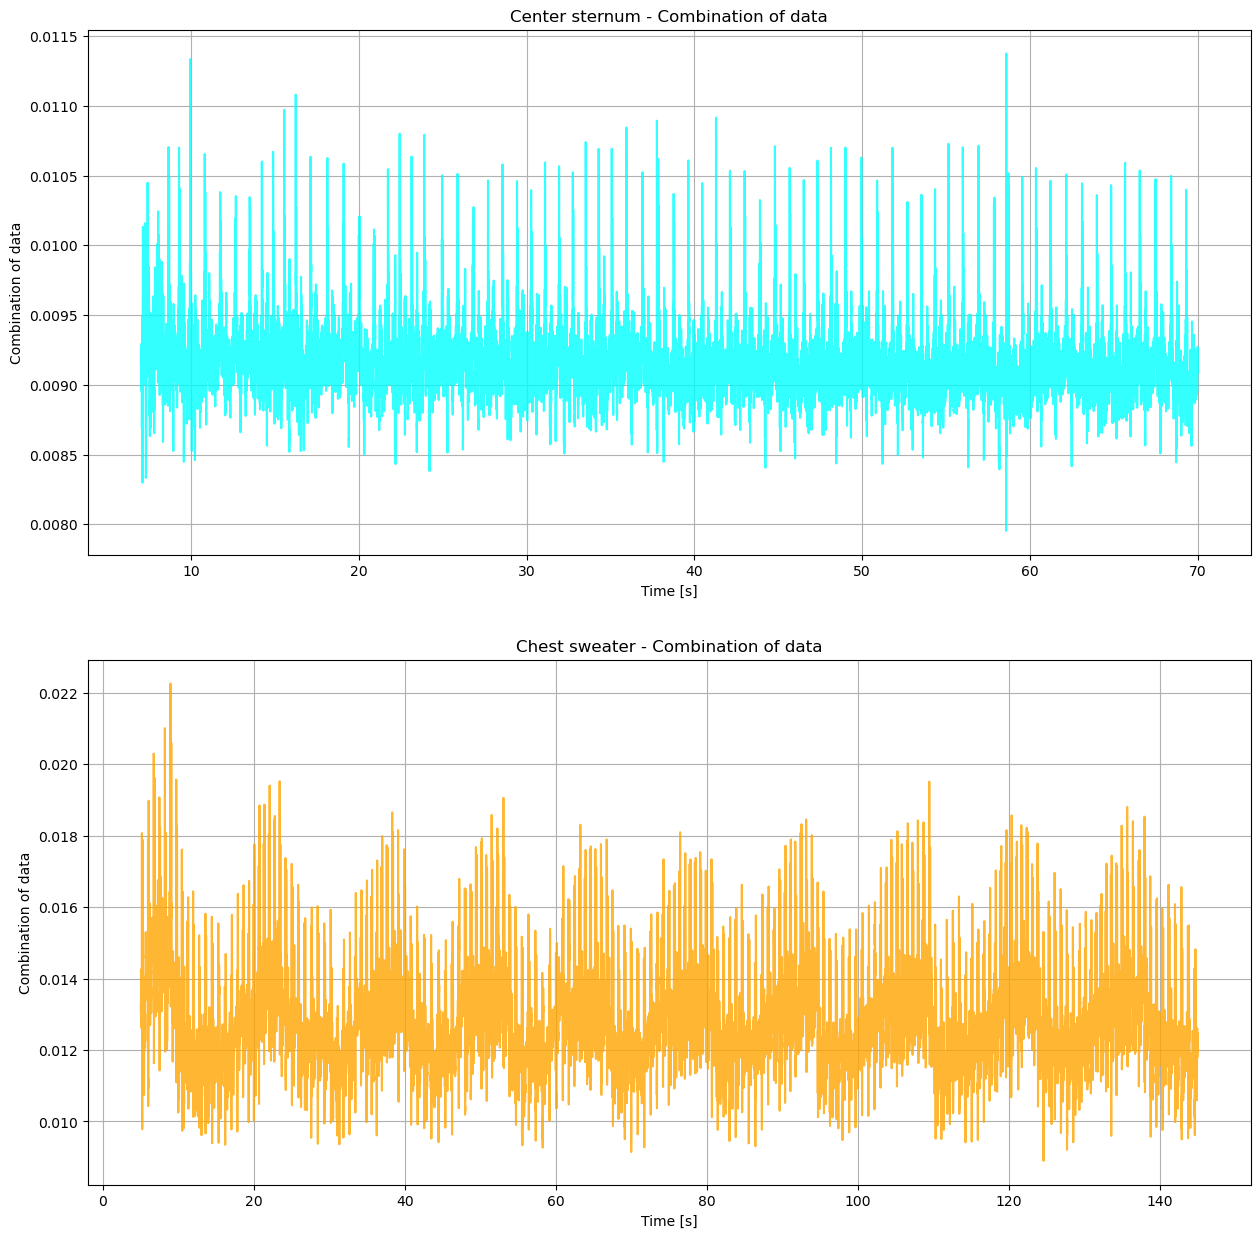

In [65]:
fig, axes = plt.subplots(2,1, figsize=(15, 15))

axes[0].plot(center_sternum["Time"], center_sternum["Norm_combined"], color="cyan", linestyle="-", alpha=0.8)
axes[0].set_xlabel("Time [s]")
axes[0].set_ylabel("Combination of data")
axes[0].grid(True)
axes[0].set_title("Center sternum - Combination of data")

axes[1].plot(chest_sweater["Time"], chest_sweater["Norm_combined"], color="orange", linestyle="-", alpha=0.8)
axes[1].set_xlabel("Time [s]")
axes[1].set_ylabel("Combination of data")
axes[1].grid(True)
axes[1].set_title("Chest sweater - Combination of data")

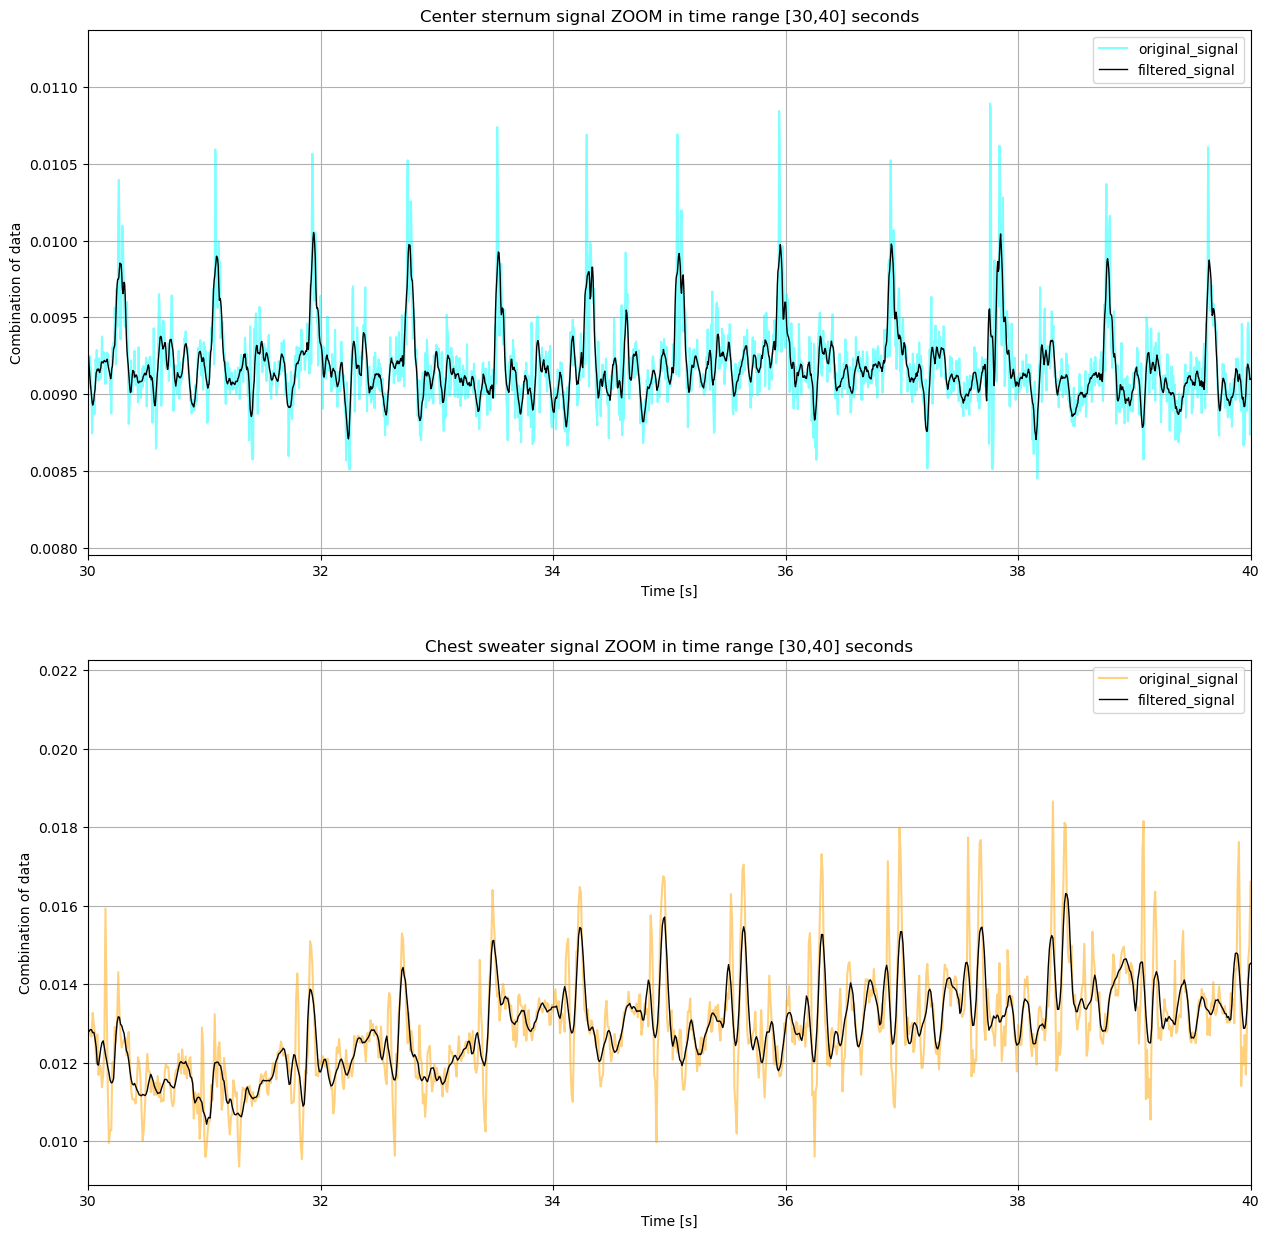

In [66]:
from scipy.signal import savgol_filter
sternum_filteredSG = savgol_filter(center_sternum["Norm_combined"], 15, 3)
chest_filteredSG = savgol_filter(chest_sweater["Norm_combined"], 15, 3)

fig, axes = plt.subplots(2, 1, figsize=(15, 15))

# Plot linear acceleration
axes[0].plot(center_sternum["Time"], center_sternum["Norm_combined"], color="cyan", linestyle="-", alpha=0.5, label="original_signal")
axes[0].plot(center_sternum["Time"], sternum_filteredSG, color="black", linestyle="-", linewidth=1, alpha=1, label = "filtered_signal")
axes[0].set_xlabel("Time [s]")
axes[0].set_xlim(30,40)
axes[0].set_ylim(center_sternum["Norm_combined"].min(),center_sternum["Norm_combined"].max())
axes[0].set_ylabel("Combination of data")
axes[0].grid(True)
axes[0].set_title("Center sternum signal ZOOM in time range [30,40] seconds")
axes[0].legend()

# Plot angular velocity
axes[1].plot(chest_sweater["Time"], chest_sweater["Norm_combined"], color="orange", linestyle="-", alpha=0.5, label="original_signal")
axes[1].plot(chest_sweater["Time"], chest_filteredSG, color="black", linestyle="-", linewidth=1, alpha=1, label = "filtered_signal")
axes[1].set_xlabel("Time [s]")
axes[1].set_xlim(30,40)
axes[1].set_ylim(chest_sweater["Norm_combined"].min(),chest_sweater["Norm_combined"].max())
axes[1].set_ylabel("Combination of data") # dps: degree per second (equal to omega/second)
axes[1].grid(True)
axes[1].set_title("Chest sweater signal ZOOM in time range [30,40] seconds")
axes[1].legend()

In [67]:
bpm, bpm_std = calculate_bpm_and_std(sternum_filteredSG, fs_sternum)
if bpm is not None:
    print(f"BPM from Center sternum: {bpm:.2f} ± {bpm_std:.2f}")
else:
    print(f"BPM from Center sternum: None")

bpm, bpm_std = calculate_bpm_and_std(chest_filteredSG, fs_chest)
if bpm is not None:
    print(f"BPM from Chest sweater: {bpm:.2f} ± {bpm_std:.2f}")
else:
    print(f"BPM from Chest sweater: None")

BPM from Center sternum: 71.60 ± 10.17
BPM from Chest sweater: 77.88 ± 10.75


## Conclusion

The first challenging task has been to select the data to perform the analysis, since we had little knowledge regarding BCG signal processing. The goal was estimate the heart rate, by using linear acceleration and angular velocity; however we've decided to investigate also the behaviour of the magnetic field since we wanted to see if the strength of the magnetic field helped us to get more accurate results. <br>

Another issue has been understanding the representation of data in the 2 file "_center_sternum_" and "_chest_sweater_": in fact, two configuration files have been provided but we haven't understood how calibration tables could have been used for the analysis. We've also looked in the site of the MuSe sensor and we've only found the specific measurement units used for the three magnitudes (acceleration, velocity, magnetic field), reported also in the files (line _"configuration"_). Actually, the MuSe website talks about _MPE_, which is a feature implemented into their sensors that is responsible for automatically calibrate itself continuously in order to always retrieve updated data with true values. There are two main aspects about the calibration of the sensors: the user can decide the _configuration_, which consists in varying received data according to predefined parameters, and then there is the actual calibration, which would happen continuously with real sensors. However, even after deep search into the website and the user's manual we have found no information as to how these calibration values are then implemented by the sensors and therefore we have decided to skip the calibration step. Anyway, it is important to notice that in order to obtain accurate results it is vital to implement also the information regarding calibration, as it gives more insight on how to interpret the data in the right way (for example there could be a bias we did not know about).
<br>

We have chosen a proper time window trying to not consider the initial and final values, affected by noise that we suppose is due to the mount and the dismount of the sensor to the chest or sternum. As both datasets describe, the user is lying still so we would expect all the signals to have small variations: the only periods of time in which this is not true are at the beginning and the end of the experiment and this is what brought us to the decision made.
<br>
It's important to specify that in the first case (_center_sternum_ data) the subject was lying supine for sure and the sensor was applied to his sternum. As regards the second dataset (_chest_sweater_) we don't know the position of the subject, we only know that the sensor was placed on his chest directly on a sweater. <br>

To perform the next steps of the analysis, we've also had to decide if consider only some particular axis or some combination of them. We've computed the PCA analysis and we got the following results:
- Center_sternum
For linear acceleration and magnetic field, the highest % of the total variability (around 94%) is due to the component X. For the angular velocity, if we keep only the x component we retain only 60% of total variability, so all the 3 dimensions contribute to the variability. 
- Chest_sweater
For all dimensions, if we keep the components X and Y we retain the 90% of total variability.

<br>
Based on the results obtained, we should have selected only some components for each size, of each file. To simplify the analysis, we decided to calculate the modulus of the three vectors and keep that. In this way we have maintained the "contribution" of each component: in fact, it is simply a matter of adding the squares of the three values and calculating the square root of the sum.
<br>

After deciding which axes, or combination of them (as we did) to take, we delved into the study of the signals in the time domain and in the frequency domain. After having computed many statistical metrics, we have seen and also shown above that the mean, or better the RMS (as it is more robust to noise with respect to the mean), and the standard deviation were among the best metrics to describe data. This can be understood also by the graphs with these metrics shown on them. By computing the correlation coefficients we were able to determine that there was no correlation among the features. In order to have a more robust computation, this check was done both with Pearson and Spearman method.
Instead, as regards the frequency domain, by computing the Fast Fourier Transform we have been able to understand which were the frequencies that mostly affected the signals, even though the presence of noise was very much noticeable.
<br>

In order to estimate the heartbeat it was first necessary to filter the signals to eliminate the noise. Knowing the shape that the BGC signal of a healthy patient should have and observing the frequency spectrum, we decided to apply a bandpass filter. <br>
The spectrum of all three signals presented peaks corresponding to the information of our interest. Initially, we tried to keep only the highest peaks and cancel all the other frequencies: as we expected, this approach was too drastic and canceled out too much information in addition to the noise, completely distorting the shape of the signal. <br>
Therefore we have created a bandpass filter that keeps all the frequencies that are distant from the peak frequency within a certain threshold. <br>
The thresholds have been chosen considering the trade off between the loss of information and the noise removal: if we tried to extend the range of allowed frequencies, a lot of artifacts appeared in the plot. <br>
To compare the 2 files, we can say that in both of them the best result has been obtained with the angular velocity: the filtered signal seems very similar to what we expected as BGC signal. There's a specific pattern and we can recognize a periodicity of peaks.
<br>
As a second approach we've used a Savitzky-Golay filter, a more complicated and accurate version of the moving average filter, and we've applied it directly to the original signal, without the need to calculate the FFT. 
<br>

We expected that, for example, ballistocardiogram (BCG) artifacts occur because of the cardiac pulse-related movement of the scalp electrodes inside the magnetic field. The results confirm that the amplitude of the BCG artefact is a function of the static magnetic field strength. Moreover, the spatial variability of the BCG artefact substantially increased at higher magnetic field strengths.

Heart Rate Variability (HRV) is a way to measure how much the time between heartbeats changes. It shows how well our body's autopilot system for the heart is working. When HRV is higher, it usually means our body's systems are balanced and working well. Things like stress, fitness, and health issues can affect HRV. There are some numbers we use to check HRV, like SDNN, RMSSD, and pNN50, which help us understand if HRV is good or not.
HRV is influenced by things like how active we are and if we have any health problems. For example, people who exercise a lot usually have higher HRV, which is a sign of a healthy heart. On the other hand, lower HRV can sometimes mean there might be heart problems or other health issues like stress or anxiety.
Nowadays, with devices like smartwatches, we can easily measure HRV. This helps us keep track of our health and catch any problems early on.
In conclusion, the results obtained are in line with those consulted in the literatures.